In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.keras.datasets.mnist

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
class Dataset:
    def __init__(self, train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True):
        self.train_img = train_images
        self.train_labels = train_labels
        self.shuffle = shuffle
        self.projection_data_path = projection_data_path
        self.metadata_tsv = '%s/metadata.tsv' % projection_data_path
        self.sprite = '%s/sprite_train_img.png' % projection_data_path
        if self.shuffle:
            idx = np.arange(len(self.train_img))
            np.random.shuffle(idx)
            self.train_img = self.train_img[idx]
            self.train_labels = self.train_labels[idx]
        
        whole_train = len(train_images)
        num_validation_samples = int(whole_train*validation)
        num_train_sample = whole_train - num_validation_samples
        
        self.train_img = self.train_img[:num_train_sample,:,:]
        self.train_img = self.prepare_data(self.train_img)
        self.train_labels = self.train_labels[:num_train_sample]
        
        self.test_img = self.prepare_data(test_images)
        self.test_labels = test_labels
        
        if not validation == 0.0:
            self.validation_labels = self.train_labels[num_train_sample+1:]
            self.validation_img = self.train_img[num_train_sample+1:,:,:]
            self.validation_img = self.prepare_data(self.validation_img)        
            if len(self.train_img.shape)==3:
                new_shape = self.validation_img.shape + (1,)
                self.validation_img = self.validation_img.reshape(new_shape)

        
        if len(self.train_img.shape)==3:
            new_shape = self.train_img.shape + (1,)
            self.train_img = self.train_img.reshape(new_shape)
            new_shape = self.test_img.shape + (1,)
            self.test_img = self.test_img.reshape(new_shape)
        
        self.data_shape = self.train_img.shape
        
    def normalize(self, images):
        # Normalize.
        max_value = np.amax(images)
        post = images/max_value
        return post
    
    # Function to pre-process the data.
    def prepare_data(self, images):
        post_images = self.normalize(images)
        return post_images
    
    def batches(self, batch_size):
        n_batches = self.train_img.shape[0]//batch_size
        for index in range(0, n_batches):
            x = self.train_img[index:index+batch_size, :, :, :]
            y = self.train_labels[index:index+batch_size]
            yield (x, y)

    def random_test(self):
        idx = np.arange(len(self.test_img))
        np.random.shuffle(idx)
        return [self.test_img[idx[0], :, :]]
    
    def random_train(self):
        idx = np.arange(len(self.train_img))
        np.random.shuffle(idx)
        return [self.train_img[idx[0], :, :]]
    
    def create_sprite_image(self, images):
        if os.path.isfile(self.sprite):
            os.remove(self.sprite)

        img_h = images.shape[1]
        img_w = images.shape[2]
        n_plots = int(np.ceil(np.sqrt(images.shape[0])))
        spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
        for i in range(n_plots):
            for j in range(n_plots):
                this_filter = i * n_plots + j
                if this_filter < images.shape[0]:
                    this_img = images[this_filter]
                    spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = this_img
        plt.imsave(self.sprite, spriteimage,cmap='gray')

    def create_tsv_file(self, img_labels):
        if os.path.isfile(self.metadata_tsv):
            os.remove(self.metadata_tsv)
        
        with open(self.metadata_tsv,'w') as f:
            f.write("Index\tLabel\n")
            for index,label in enumerate(img_labels):
                f.write("%d\t%d\n" % (index,label))

In [4]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim, cmap):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, 0]
        plt.imshow(img, cmap=cmap)
    plt.show()

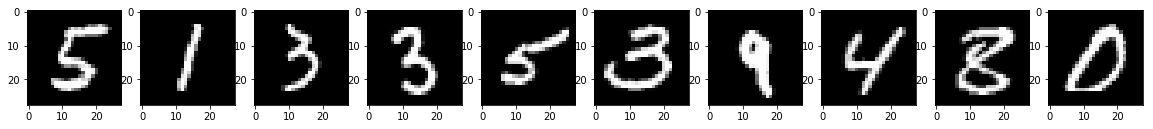

In [5]:
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
data = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

plot_images(plt_num=10, images=data.train_img, dim=20, cmap='gray')

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [49]:
def discriminator(images, reuse, alpha, use_bn=True):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Padding = 'Same' -> H_new = H_old // Stride
        
        # First Conv layer: 
        net = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='c1')
        net = leakyReLU(net, alpha)
        
        # Second Conv layer: 
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='c2')
        if use_bn: net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)

        net = tf.layers.flatten(net, name='flatten')

        # Dense Layer.
        net = tf.layers.dense(net, 1024, activation=None)
        if use_bn: net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        
        # Dense Layer.
        logits = tf.layers.dense(net, 1, activation=None)
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [50]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully
        net = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        
        # Fully
        net = tf.layers.dense(inputs=net, units=128*7*7, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        
        net = tf.reshape(net, (-1, 7, 7, 128))
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='c1')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='c2')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        
        # Conv
        logits = tf.layers.conv2d_transpose(inputs=net, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), 
                                            name='logits')
        output = tf.nn.sigmoid(logits, name='output')
        
        return output

In [51]:
def show_generated(session, output_fake, n_images, z_input, image_type):
    cmap = None if image_type == 'RGB' else 'gray'
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    
    gen_samples *= 255.
    
    plot_images(plt_num=n_images, images=gen_samples, dim=10, cmap=cmap)    

In [56]:
def loss(real_images, z_input, out_channel_dim, alpha, batch_size, gp_coeff, use_bn):
    
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(fake_images, False, alpha, use_bn) 
    output_real, logits_real = discriminator(real_images, True, alpha, use_bn)
    
    # Calculating X hat.
    epsilon = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0, dtype=tf.float32, name='epsilon')
    x_gp = real_images*(1-epsilon) + fake_images*epsilon
    output_gp, logits_gp = discriminator(x_gp, True, alpha, use_bn)
    
    # Calculating Gradient Penalty.
    grad_gp = tf.gradients(logits_gp, x_gp)
    l2_grad_gp = tf.sqrt(tf.reduce_sum(tf.square(grad_gp), axis=[1, 2, 3]))
    grad_penalty= tf.reduce_sum(tf.square(l2_grad_gp-1.0))
    
    # Discriminator loss.
    loss_dis_real = tf.reduce_mean(logits_real)
    loss_dis_fake = tf.reduce_mean(logits_fake)
    loss_dis = (-loss_dis_real + loss_dis_fake) + (gp_coeff*grad_penalty)

    # Generator loss.
    # This is where we implement -log[D(G(z))] instead log[1-D(G(z))].
    # Recall the implementation of cross-entropy, sign already in. 
    loss_gen = -loss_dis_fake
    
    return loss_dis, loss_gen

#### Defining new cost function according to WGAN. 
Loss(Lpr, Lpg) = Max-w ( Ex~pr[fw(x)] - Ez~pg(z)[fw(Gtheta(z))] )  
Generator would want to find the theta parameters that minimizes the cost of moving the distributions.
Discriminator/Critic wants to find the w parameters that approximate better the Wassertein distance. Find maximum 
of the moving the distribution Pg to Pr.

In [57]:
def optimization(loss_dis, loss_gen, learning_rate, beta_1, beta_2):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_discriminator = tf.train.AdamOptimizer(learning_rate, beta_1, beta_2).minimize(loss_dis , var_list=discriminator_variables)
        train_generator = tf.train.AdamOptimizer(learning_rate, beta_1, beta_2).minimize(loss_gen, var_list=generator_variables)
        
    return train_generator, train_discriminator

In [58]:
def train(epochs, batch_size, z_dim, learning_rate, dataset, image_type, alpha, beta_1, beta_2, n_critic, gp_coeff, use_bn):
    
    # Dataset information.
    dataset_size, image_width, image_height, image_channels = dataset.data_shape

    # Inputs.    
    real_images, z_input, learning_rate_input = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Loss.
    loss_dis, loss_gen = loss(real_images, z_input, image_channels, alpha, batch_size, gp_coeff, use_bn)
    
    # Optimizers.
    train_generator, train_discriminator = optimization(loss_dis, loss_gen, learning_rate_input, beta_1, beta_2)

    # Sampling generator.    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    losses = list()
    run_epochs = 0
    show_epochs = 100
    print_epochs = 10
    n_images = 10
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs+1):
            get_batches = data.batches(batch_size)
            for batch_images, batch_labels in get_batches:
                
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}
                
                # Update critic and clip gradients.
                session.run(train_discriminator, feed_dict=feed_dict)
                
                # Update generator after n_critic updates from discriminator.
                if run_epochs%n_critic :
                    session.run(train_generator, feed_dict=feed_dict)
               
                # Print losses and Generate samples.
                if run_epochs%print_epochs==0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % 
                          (epoch, epochs, np.round(epoch_loss_gen, 3), np.round(epoch_loss_dis, 3)))
                if run_epochs%show_epochs == 0:
                    show_generated(session, output_gen, n_images, z_input, image_type)
                run_epochs+=1


Epochs 0/10: Generator Loss: 0.073. Discriminator Loss: 1.389


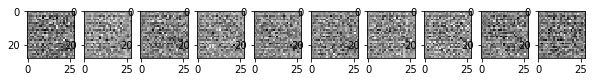

Epochs 0/10: Generator Loss: 1.054. Discriminator Loss: -1.166


Epochs 0/10: Generator Loss: 1.22. Discriminator Loss: -1.448


Epochs 0/10: Generator Loss: 0.902. Discriminator Loss: -1.316


Epochs 0/10: Generator Loss: 0.474. Discriminator Loss: -1.01


Epochs 0/10: Generator Loss: 0.578. Discriminator Loss: -1.07


Epochs 0/10: Generator Loss: 0.318. Discriminator Loss: -0.944


Epochs 0/10: Generator Loss: 0.197. Discriminator Loss: -0.842


Epochs 0/10: Generator Loss: 0.116. Discriminator Loss: -0.74


Epochs 0/10: Generator Loss: 0.143. Discriminator Loss: -0.701


Epochs 0/10: Generator Loss: 0.039. Discriminator Loss: -0.64


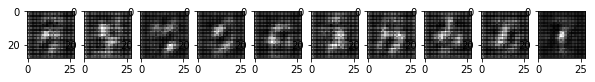

Epochs 0/10: Generator Loss: -0.04. Discriminator Loss: -0.581


Epochs 0/10: Generator Loss: -0.172. Discriminator Loss: -0.481


Epochs 0/10: Generator Loss: -0.069. Discriminator Loss: -0.404


Epochs 0/10: Generator Loss: -0.266. Discriminator Loss: -0.377


Epochs 0/10: Generator Loss: -0.337. Discriminator Loss: -0.303


Epochs 0/10: Generator Loss: -0.337. Discriminator Loss: -0.388


Epochs 0/10: Generator Loss: -0.39. Discriminator Loss: -0.393


Epochs 0/10: Generator Loss: -0.588. Discriminator Loss: -0.338


Epochs 0/10: Generator Loss: -0.784. Discriminator Loss: -0.37


Epochs 0/10: Generator Loss: -0.419. Discriminator Loss: -0.364


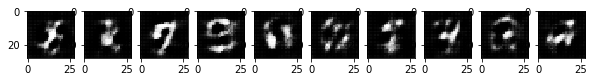

Epochs 0/10: Generator Loss: -0.593. Discriminator Loss: -0.338


Epochs 0/10: Generator Loss: -0.612. Discriminator Loss: -0.286


Epochs 0/10: Generator Loss: -0.83. Discriminator Loss: -0.317


Epochs 0/10: Generator Loss: -0.716. Discriminator Loss: -0.321


Epochs 0/10: Generator Loss: -0.689. Discriminator Loss: -0.318


Epochs 0/10: Generator Loss: -0.87. Discriminator Loss: -0.307


Epochs 0/10: Generator Loss: -0.736. Discriminator Loss: -0.324


Epochs 0/10: Generator Loss: -0.791. Discriminator Loss: -0.319


Epochs 0/10: Generator Loss: -0.917. Discriminator Loss: -0.303


Epochs 0/10: Generator Loss: -0.947. Discriminator Loss: -0.28


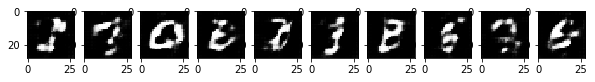

Epochs 0/10: Generator Loss: -0.975. Discriminator Loss: -0.278


Epochs 0/10: Generator Loss: -1.121. Discriminator Loss: -0.225


Epochs 0/10: Generator Loss: -0.845. Discriminator Loss: -0.228


Epochs 0/10: Generator Loss: -1.062. Discriminator Loss: -0.226


Epochs 0/10: Generator Loss: -1.167. Discriminator Loss: -0.249


Epochs 0/10: Generator Loss: -1.095. Discriminator Loss: -0.273


Epochs 0/10: Generator Loss: -1.27. Discriminator Loss: -0.195


Epochs 0/10: Generator Loss: -1.027. Discriminator Loss: -0.249


Epochs 0/10: Generator Loss: -0.88. Discriminator Loss: -0.296


Epochs 0/10: Generator Loss: -0.913. Discriminator Loss: -0.246


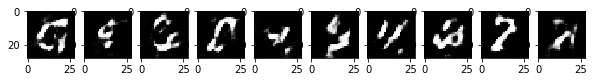

Epochs 0/10: Generator Loss: -1.11. Discriminator Loss: -0.273


Epochs 0/10: Generator Loss: -1.146. Discriminator Loss: -0.24


Epochs 0/10: Generator Loss: -1.045. Discriminator Loss: -0.3


Epochs 0/10: Generator Loss: -1.079. Discriminator Loss: -0.237


Epochs 0/10: Generator Loss: -1.05. Discriminator Loss: -0.266


Epochs 0/10: Generator Loss: -1.065. Discriminator Loss: -0.242


Epochs 0/10: Generator Loss: -1.047. Discriminator Loss: -0.054


Epochs 0/10: Generator Loss: -1.147. Discriminator Loss: -0.236


Epochs 0/10: Generator Loss: -1.104. Discriminator Loss: -0.224


Epochs 0/10: Generator Loss: -1.231. Discriminator Loss: -0.284


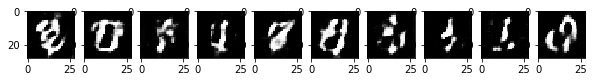

Epochs 0/10: Generator Loss: -1.014. Discriminator Loss: -0.243


Epochs 0/10: Generator Loss: -0.825. Discriminator Loss: -0.281


Epochs 0/10: Generator Loss: -1.078. Discriminator Loss: -0.293


Epochs 0/10: Generator Loss: -0.82. Discriminator Loss: -0.163


Epochs 0/10: Generator Loss: -1.046. Discriminator Loss: -0.277


Epochs 0/10: Generator Loss: -1.087. Discriminator Loss: -0.267


Epochs 0/10: Generator Loss: -0.983. Discriminator Loss: -0.294


Epochs 0/10: Generator Loss: -0.91. Discriminator Loss: -0.256


Epochs 0/10: Generator Loss: -1.014. Discriminator Loss: -0.223


Epochs 0/10: Generator Loss: -0.833. Discriminator Loss: -0.169


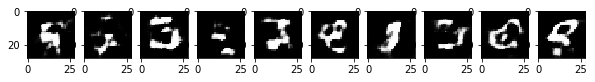

Epochs 0/10: Generator Loss: -0.872. Discriminator Loss: -0.254


Epochs 0/10: Generator Loss: -0.94. Discriminator Loss: -0.22


Epochs 0/10: Generator Loss: -0.962. Discriminator Loss: -0.272


Epochs 0/10: Generator Loss: -1.179. Discriminator Loss: -0.253


Epochs 0/10: Generator Loss: -1.074. Discriminator Loss: -0.216


Epochs 0/10: Generator Loss: -0.776. Discriminator Loss: -0.273


Epochs 0/10: Generator Loss: -0.733. Discriminator Loss: -0.262


Epochs 0/10: Generator Loss: -0.61. Discriminator Loss: -0.279


Epochs 0/10: Generator Loss: -0.942. Discriminator Loss: -0.321


Epochs 0/10: Generator Loss: -0.628. Discriminator Loss: -0.293


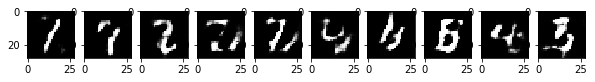

Epochs 0/10: Generator Loss: -0.783. Discriminator Loss: -0.279


Epochs 0/10: Generator Loss: -0.838. Discriminator Loss: -0.267


Epochs 0/10: Generator Loss: -0.997. Discriminator Loss: -0.257


Epochs 0/10: Generator Loss: -0.865. Discriminator Loss: -0.306


Epochs 0/10: Generator Loss: -1.147. Discriminator Loss: -0.259


Epochs 0/10: Generator Loss: -1.006. Discriminator Loss: -0.25


Epochs 0/10: Generator Loss: -0.9. Discriminator Loss: -0.274


Epochs 0/10: Generator Loss: -0.992. Discriminator Loss: -0.254


Epochs 0/10: Generator Loss: -1.018. Discriminator Loss: -0.251


Epochs 0/10: Generator Loss: -0.893. Discriminator Loss: -0.258


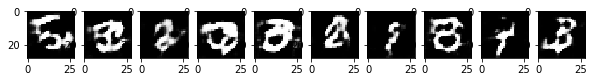

Epochs 0/10: Generator Loss: -0.594. Discriminator Loss: -0.228


Epochs 0/10: Generator Loss: -0.785. Discriminator Loss: -0.299


Epochs 0/10: Generator Loss: -0.6. Discriminator Loss: -0.278


Epochs 0/10: Generator Loss: -0.803. Discriminator Loss: -0.276


Epochs 0/10: Generator Loss: -0.571. Discriminator Loss: -0.295


Epochs 0/10: Generator Loss: -0.962. Discriminator Loss: -0.194


Epochs 0/10: Generator Loss: -0.654. Discriminator Loss: -0.175


Epochs 0/10: Generator Loss: -0.783. Discriminator Loss: -0.277


Epochs 0/10: Generator Loss: -0.608. Discriminator Loss: -0.174


Epochs 0/10: Generator Loss: -0.602. Discriminator Loss: -0.297


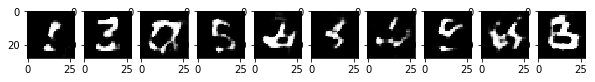

Epochs 0/10: Generator Loss: -0.826. Discriminator Loss: -0.284


Epochs 0/10: Generator Loss: -0.387. Discriminator Loss: -0.295


Epochs 0/10: Generator Loss: -0.627. Discriminator Loss: -0.303


Epochs 0/10: Generator Loss: -0.572. Discriminator Loss: -0.326


Epochs 0/10: Generator Loss: -0.754. Discriminator Loss: -0.277


Epochs 0/10: Generator Loss: -0.67. Discriminator Loss: -0.228


Epochs 0/10: Generator Loss: -0.951. Discriminator Loss: -0.307


Epochs 0/10: Generator Loss: -0.636. Discriminator Loss: -0.173


Epochs 0/10: Generator Loss: -0.772. Discriminator Loss: -0.276


Epochs 0/10: Generator Loss: -0.859. Discriminator Loss: -0.296


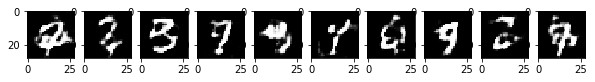

Epochs 0/10: Generator Loss: -0.78. Discriminator Loss: -0.255


Epochs 0/10: Generator Loss: -0.523. Discriminator Loss: -0.242


Epochs 0/10: Generator Loss: -0.482. Discriminator Loss: -0.074


Epochs 0/10: Generator Loss: -0.727. Discriminator Loss: -0.243


Epochs 0/10: Generator Loss: -0.709. Discriminator Loss: -0.154


Epochs 0/10: Generator Loss: -0.592. Discriminator Loss: -0.264


Epochs 0/10: Generator Loss: -0.524. Discriminator Loss: -0.292


Epochs 0/10: Generator Loss: -0.653. Discriminator Loss: -0.277


Epochs 0/10: Generator Loss: -0.803. Discriminator Loss: -0.235


Epochs 0/10: Generator Loss: -0.635. Discriminator Loss: -0.298


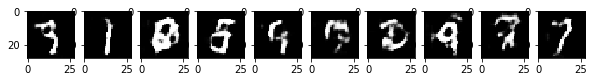

Epochs 0/10: Generator Loss: -0.823. Discriminator Loss: -0.247


Epochs 0/10: Generator Loss: -0.63. Discriminator Loss: -0.224


Epochs 0/10: Generator Loss: -1.24. Discriminator Loss: -0.232


Epochs 0/10: Generator Loss: -0.771. Discriminator Loss: -0.206


Epochs 0/10: Generator Loss: -0.736. Discriminator Loss: -0.185


Epochs 0/10: Generator Loss: -0.816. Discriminator Loss: -0.273


Epochs 0/10: Generator Loss: -0.877. Discriminator Loss: -0.271


Epochs 0/10: Generator Loss: -0.925. Discriminator Loss: -0.132


Epochs 0/10: Generator Loss: -1.281. Discriminator Loss: -0.234


Epochs 0/10: Generator Loss: -0.754. Discriminator Loss: -0.174


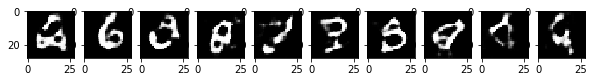

Epochs 0/10: Generator Loss: -0.656. Discriminator Loss: -0.271


Epochs 0/10: Generator Loss: -0.591. Discriminator Loss: -0.252


Epochs 0/10: Generator Loss: -0.893. Discriminator Loss: -0.193


Epochs 0/10: Generator Loss: -0.756. Discriminator Loss: -0.307


Epochs 0/10: Generator Loss: -0.721. Discriminator Loss: -0.303


Epochs 0/10: Generator Loss: -0.532. Discriminator Loss: -0.238


Epochs 0/10: Generator Loss: -0.709. Discriminator Loss: -0.296


Epochs 0/10: Generator Loss: -0.943. Discriminator Loss: -0.162


Epochs 0/10: Generator Loss: -0.877. Discriminator Loss: -0.25


Epochs 0/10: Generator Loss: -0.928. Discriminator Loss: -0.073


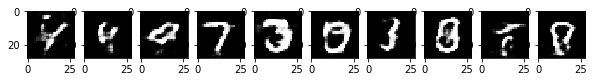

Epochs 0/10: Generator Loss: -0.949. Discriminator Loss: -0.227


Epochs 0/10: Generator Loss: -0.907. Discriminator Loss: -0.171


Epochs 0/10: Generator Loss: -1.101. Discriminator Loss: -0.22


Epochs 0/10: Generator Loss: -0.946. Discriminator Loss: -0.262


Epochs 0/10: Generator Loss: -0.828. Discriminator Loss: -0.331


Epochs 0/10: Generator Loss: -0.704. Discriminator Loss: -0.251


Epochs 0/10: Generator Loss: -0.549. Discriminator Loss: -0.246


Epochs 0/10: Generator Loss: -0.625. Discriminator Loss: -0.254


Epochs 0/10: Generator Loss: -0.708. Discriminator Loss: -0.218


Epochs 0/10: Generator Loss: -0.495. Discriminator Loss: -0.2


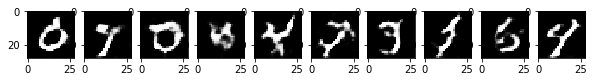

Epochs 0/10: Generator Loss: -0.797. Discriminator Loss: -0.229


Epochs 0/10: Generator Loss: -0.693. Discriminator Loss: -0.213


Epochs 0/10: Generator Loss: -0.575. Discriminator Loss: -0.232


Epochs 0/10: Generator Loss: -0.776. Discriminator Loss: -0.252


Epochs 0/10: Generator Loss: -1.022. Discriminator Loss: -0.274


Epochs 0/10: Generator Loss: -0.95. Discriminator Loss: -0.345


Epochs 0/10: Generator Loss: -0.822. Discriminator Loss: -0.298


Epochs 0/10: Generator Loss: -0.92. Discriminator Loss: -0.245


Epochs 0/10: Generator Loss: -0.809. Discriminator Loss: -0.249


Epochs 0/10: Generator Loss: -0.697. Discriminator Loss: -0.23


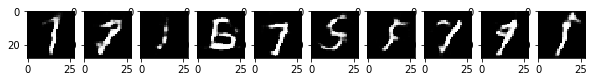

Epochs 0/10: Generator Loss: -0.707. Discriminator Loss: -0.214


Epochs 0/10: Generator Loss: -0.83. Discriminator Loss: -0.245


Epochs 0/10: Generator Loss: -0.841. Discriminator Loss: -0.204


Epochs 0/10: Generator Loss: -1.033. Discriminator Loss: -0.229


Epochs 0/10: Generator Loss: -0.927. Discriminator Loss: -0.182


Epochs 0/10: Generator Loss: -0.765. Discriminator Loss: -0.274


Epochs 0/10: Generator Loss: -0.888. Discriminator Loss: -0.198


Epochs 0/10: Generator Loss: -0.917. Discriminator Loss: -0.198


Epochs 0/10: Generator Loss: -1.049. Discriminator Loss: -0.257


Epochs 0/10: Generator Loss: -0.972. Discriminator Loss: -0.278


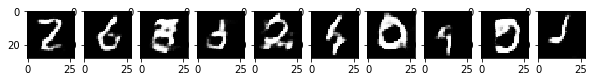

Epochs 0/10: Generator Loss: -0.946. Discriminator Loss: -0.305


Epochs 0/10: Generator Loss: -0.791. Discriminator Loss: -0.235


Epochs 0/10: Generator Loss: -0.879. Discriminator Loss: -0.212


Epochs 0/10: Generator Loss: -1.017. Discriminator Loss: -0.255


Epochs 0/10: Generator Loss: -1.139. Discriminator Loss: -0.197


Epochs 0/10: Generator Loss: -0.659. Discriminator Loss: -0.21


Epochs 0/10: Generator Loss: -0.864. Discriminator Loss: -0.263


Epochs 0/10: Generator Loss: -0.855. Discriminator Loss: -0.184


Epochs 0/10: Generator Loss: -0.662. Discriminator Loss: -0.196


Epochs 0/10: Generator Loss: -0.988. Discriminator Loss: -0.213


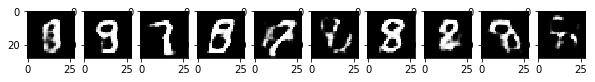

Epochs 0/10: Generator Loss: -1.002. Discriminator Loss: -0.201


Epochs 0/10: Generator Loss: -0.919. Discriminator Loss: -0.125


Epochs 0/10: Generator Loss: -0.997. Discriminator Loss: -0.165


Epochs 0/10: Generator Loss: -0.998. Discriminator Loss: -0.099


Epochs 0/10: Generator Loss: -0.934. Discriminator Loss: -0.156


Epochs 0/10: Generator Loss: -0.949. Discriminator Loss: -0.173


Epochs 0/10: Generator Loss: -0.98. Discriminator Loss: -0.248


Epochs 0/10: Generator Loss: -0.827. Discriminator Loss: -0.174


Epochs 0/10: Generator Loss: -0.583. Discriminator Loss: -0.176


Epochs 0/10: Generator Loss: -1.006. Discriminator Loss: -0.255


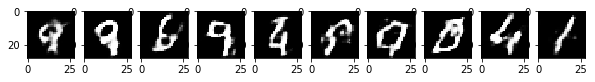

Epochs 0/10: Generator Loss: -1.097. Discriminator Loss: -0.213


Epochs 0/10: Generator Loss: -1.108. Discriminator Loss: -0.064


Epochs 0/10: Generator Loss: -0.721. Discriminator Loss: -0.141


Epochs 0/10: Generator Loss: -1.059. Discriminator Loss: -0.228


Epochs 0/10: Generator Loss: -0.953. Discriminator Loss: -0.118


Epochs 0/10: Generator Loss: -1.012. Discriminator Loss: -0.214


Epochs 0/10: Generator Loss: -1.245. Discriminator Loss: -0.259


Epochs 1/10: Generator Loss: -0.79. Discriminator Loss: -0.14


Epochs 1/10: Generator Loss: -1.2. Discriminator Loss: -0.162


Epochs 1/10: Generator Loss: -1.22. Discriminator Loss: -0.171


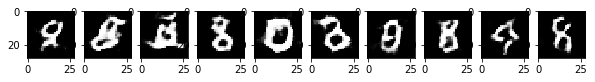

Epochs 1/10: Generator Loss: -1.395. Discriminator Loss: -0.194


Epochs 1/10: Generator Loss: -0.879. Discriminator Loss: -0.187


Epochs 1/10: Generator Loss: -0.933. Discriminator Loss: -0.275


Epochs 1/10: Generator Loss: -0.839. Discriminator Loss: -0.262


Epochs 1/10: Generator Loss: -0.725. Discriminator Loss: -0.125


Epochs 1/10: Generator Loss: -0.89. Discriminator Loss: -0.259


Epochs 1/10: Generator Loss: -0.963. Discriminator Loss: -0.241


Epochs 1/10: Generator Loss: -0.87. Discriminator Loss: -0.226


Epochs 1/10: Generator Loss: -0.977. Discriminator Loss: -0.203


Epochs 1/10: Generator Loss: -0.995. Discriminator Loss: -0.23


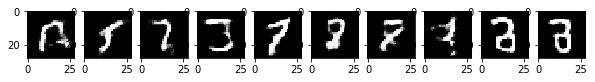

Epochs 1/10: Generator Loss: -1.142. Discriminator Loss: -0.216


Epochs 1/10: Generator Loss: -1.141. Discriminator Loss: -0.251


Epochs 1/10: Generator Loss: -0.992. Discriminator Loss: -0.211


Epochs 1/10: Generator Loss: -1.001. Discriminator Loss: -0.178


Epochs 1/10: Generator Loss: -0.973. Discriminator Loss: -0.161


Epochs 1/10: Generator Loss: -0.87. Discriminator Loss: -0.215


Epochs 1/10: Generator Loss: -0.909. Discriminator Loss: -0.134


Epochs 1/10: Generator Loss: -0.947. Discriminator Loss: -0.142


Epochs 1/10: Generator Loss: -0.832. Discriminator Loss: -0.25


Epochs 1/10: Generator Loss: -1.035. Discriminator Loss: -0.233


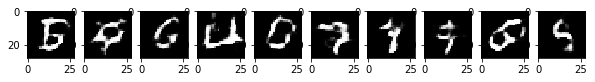

Epochs 1/10: Generator Loss: -0.89. Discriminator Loss: -0.243


Epochs 1/10: Generator Loss: -0.479. Discriminator Loss: -0.159


Epochs 1/10: Generator Loss: -0.86. Discriminator Loss: -0.22


Epochs 1/10: Generator Loss: -0.806. Discriminator Loss: -0.235


Epochs 1/10: Generator Loss: -1.045. Discriminator Loss: -0.265


Epochs 1/10: Generator Loss: -0.895. Discriminator Loss: -0.249


Epochs 1/10: Generator Loss: -1.121. Discriminator Loss: -0.167


Epochs 1/10: Generator Loss: -0.822. Discriminator Loss: -0.202


Epochs 1/10: Generator Loss: -0.749. Discriminator Loss: -0.169


Epochs 1/10: Generator Loss: -0.665. Discriminator Loss: -0.194


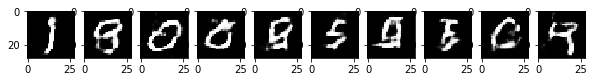

Epochs 1/10: Generator Loss: -0.556. Discriminator Loss: -0.147


Epochs 1/10: Generator Loss: -0.957. Discriminator Loss: -0.207


Epochs 1/10: Generator Loss: -0.842. Discriminator Loss: -0.234


Epochs 1/10: Generator Loss: -0.777. Discriminator Loss: -0.235


Epochs 1/10: Generator Loss: -0.712. Discriminator Loss: -0.279


Epochs 1/10: Generator Loss: -0.812. Discriminator Loss: -0.226


Epochs 1/10: Generator Loss: -0.745. Discriminator Loss: -0.179


Epochs 1/10: Generator Loss: -0.889. Discriminator Loss: -0.186


Epochs 1/10: Generator Loss: -0.777. Discriminator Loss: -0.237


Epochs 1/10: Generator Loss: -0.947. Discriminator Loss: -0.194


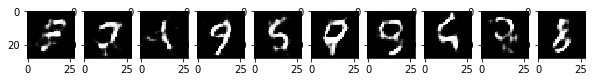

Epochs 1/10: Generator Loss: -0.959. Discriminator Loss: -0.231


Epochs 1/10: Generator Loss: -0.886. Discriminator Loss: -0.261


Epochs 1/10: Generator Loss: -0.803. Discriminator Loss: -0.188


Epochs 1/10: Generator Loss: -0.819. Discriminator Loss: -0.142


Epochs 1/10: Generator Loss: -0.818. Discriminator Loss: -0.171


Epochs 1/10: Generator Loss: -0.691. Discriminator Loss: -0.211


Epochs 1/10: Generator Loss: -1.092. Discriminator Loss: -0.205


Epochs 1/10: Generator Loss: -0.788. Discriminator Loss: -0.278


Epochs 1/10: Generator Loss: -0.94. Discriminator Loss: -0.219


Epochs 1/10: Generator Loss: -1.276. Discriminator Loss: -0.203


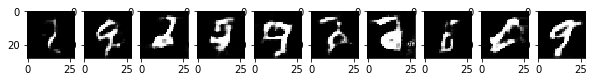

Epochs 1/10: Generator Loss: -0.763. Discriminator Loss: -0.233


Epochs 1/10: Generator Loss: -0.76. Discriminator Loss: -0.25


Epochs 1/10: Generator Loss: -0.564. Discriminator Loss: -0.159


Epochs 1/10: Generator Loss: -0.835. Discriminator Loss: -0.236


Epochs 1/10: Generator Loss: -0.872. Discriminator Loss: -0.245


Epochs 1/10: Generator Loss: -1.288. Discriminator Loss: -0.244


Epochs 1/10: Generator Loss: -0.871. Discriminator Loss: -0.217


Epochs 1/10: Generator Loss: -0.772. Discriminator Loss: -0.13


Epochs 1/10: Generator Loss: -0.769. Discriminator Loss: -0.195


Epochs 1/10: Generator Loss: -0.869. Discriminator Loss: -0.18


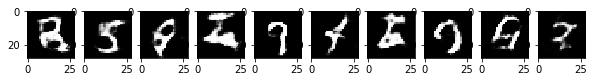

Epochs 1/10: Generator Loss: -0.942. Discriminator Loss: -0.151


Epochs 1/10: Generator Loss: -0.799. Discriminator Loss: -0.2


Epochs 1/10: Generator Loss: -0.625. Discriminator Loss: -0.288


Epochs 1/10: Generator Loss: -0.896. Discriminator Loss: -0.263


Epochs 1/10: Generator Loss: -0.776. Discriminator Loss: -0.185


Epochs 1/10: Generator Loss: -0.764. Discriminator Loss: -0.221


Epochs 1/10: Generator Loss: -0.676. Discriminator Loss: -0.274


Epochs 1/10: Generator Loss: -0.636. Discriminator Loss: -0.33


Epochs 1/10: Generator Loss: -0.582. Discriminator Loss: -0.183


Epochs 1/10: Generator Loss: -0.927. Discriminator Loss: -0.211


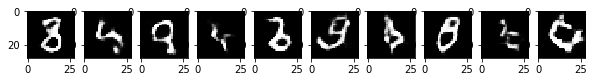

Epochs 1/10: Generator Loss: -0.953. Discriminator Loss: -0.203


Epochs 1/10: Generator Loss: -0.675. Discriminator Loss: -0.236


Epochs 1/10: Generator Loss: -0.687. Discriminator Loss: -0.169


Epochs 1/10: Generator Loss: -0.817. Discriminator Loss: -0.196


Epochs 1/10: Generator Loss: -1.375. Discriminator Loss: -0.195


Epochs 1/10: Generator Loss: -0.954. Discriminator Loss: -0.193


Epochs 1/10: Generator Loss: -0.866. Discriminator Loss: -0.238


Epochs 1/10: Generator Loss: -0.895. Discriminator Loss: -0.168


Epochs 1/10: Generator Loss: -0.85. Discriminator Loss: -0.208


Epochs 1/10: Generator Loss: -0.728. Discriminator Loss: -0.218


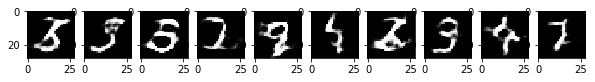

Epochs 1/10: Generator Loss: -0.697. Discriminator Loss: -0.239


Epochs 1/10: Generator Loss: -0.889. Discriminator Loss: -0.257


Epochs 1/10: Generator Loss: -0.813. Discriminator Loss: -0.221


Epochs 1/10: Generator Loss: -0.503. Discriminator Loss: -0.313


Epochs 1/10: Generator Loss: -0.593. Discriminator Loss: -0.245


Epochs 1/10: Generator Loss: -0.772. Discriminator Loss: -0.199


Epochs 1/10: Generator Loss: -0.439. Discriminator Loss: -0.168


Epochs 1/10: Generator Loss: -0.636. Discriminator Loss: -0.263


Epochs 1/10: Generator Loss: -0.842. Discriminator Loss: -0.099


Epochs 1/10: Generator Loss: -0.705. Discriminator Loss: -0.206


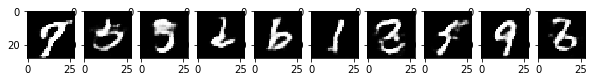

Epochs 1/10: Generator Loss: -0.667. Discriminator Loss: -0.193


Epochs 1/10: Generator Loss: -0.528. Discriminator Loss: -0.244


Epochs 1/10: Generator Loss: -0.785. Discriminator Loss: -0.248


Epochs 1/10: Generator Loss: -1.005. Discriminator Loss: -0.268


Epochs 1/10: Generator Loss: -0.798. Discriminator Loss: -0.212


Epochs 1/10: Generator Loss: -1.019. Discriminator Loss: -0.226


Epochs 1/10: Generator Loss: -0.969. Discriminator Loss: -0.188


Epochs 1/10: Generator Loss: -0.758. Discriminator Loss: -0.263


Epochs 1/10: Generator Loss: -0.446. Discriminator Loss: -0.137


Epochs 1/10: Generator Loss: -0.856. Discriminator Loss: -0.174


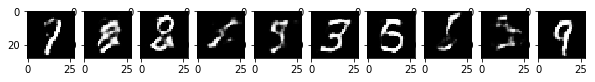

Epochs 1/10: Generator Loss: -1.043. Discriminator Loss: -0.172


Epochs 1/10: Generator Loss: -0.909. Discriminator Loss: -0.18


Epochs 1/10: Generator Loss: -0.627. Discriminator Loss: -0.217


Epochs 1/10: Generator Loss: -0.765. Discriminator Loss: -0.269


Epochs 1/10: Generator Loss: -1.152. Discriminator Loss: -0.223


Epochs 1/10: Generator Loss: 0.016. Discriminator Loss: -0.159


Epochs 1/10: Generator Loss: -0.841. Discriminator Loss: -0.197


Epochs 1/10: Generator Loss: -0.762. Discriminator Loss: -0.254


Epochs 1/10: Generator Loss: -0.718. Discriminator Loss: -0.236


Epochs 1/10: Generator Loss: -0.742. Discriminator Loss: -0.273


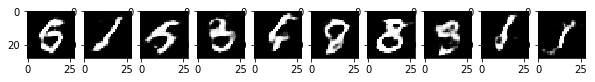

Epochs 1/10: Generator Loss: -0.663. Discriminator Loss: -0.227


Epochs 1/10: Generator Loss: -0.883. Discriminator Loss: -0.253


Epochs 1/10: Generator Loss: -0.723. Discriminator Loss: -0.166


Epochs 1/10: Generator Loss: -0.742. Discriminator Loss: -0.167


Epochs 1/10: Generator Loss: -0.875. Discriminator Loss: -0.224


Epochs 1/10: Generator Loss: -0.953. Discriminator Loss: -0.242


Epochs 1/10: Generator Loss: -0.887. Discriminator Loss: -0.198


Epochs 1/10: Generator Loss: -1.099. Discriminator Loss: -0.17


Epochs 1/10: Generator Loss: -0.818. Discriminator Loss: -0.223


Epochs 1/10: Generator Loss: -0.986. Discriminator Loss: -0.226


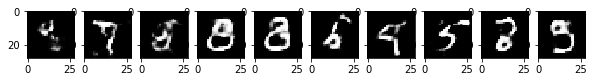

Epochs 1/10: Generator Loss: -0.876. Discriminator Loss: -0.212


Epochs 1/10: Generator Loss: -0.739. Discriminator Loss: -0.29


Epochs 1/10: Generator Loss: -1.194. Discriminator Loss: -0.295


Epochs 1/10: Generator Loss: -1.033. Discriminator Loss: -0.307


Epochs 1/10: Generator Loss: -0.923. Discriminator Loss: -0.255


Epochs 1/10: Generator Loss: -0.839. Discriminator Loss: -0.242


Epochs 1/10: Generator Loss: -1.146. Discriminator Loss: -0.192


Epochs 1/10: Generator Loss: -0.927. Discriminator Loss: -0.208


Epochs 1/10: Generator Loss: -0.915. Discriminator Loss: -0.219


Epochs 1/10: Generator Loss: -1.036. Discriminator Loss: -0.18


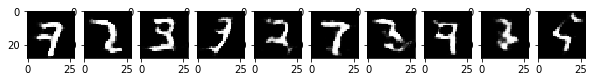

Epochs 1/10: Generator Loss: -0.76. Discriminator Loss: -0.25


Epochs 1/10: Generator Loss: -0.643. Discriminator Loss: -0.343


Epochs 1/10: Generator Loss: -1.075. Discriminator Loss: -0.279


Epochs 1/10: Generator Loss: -0.827. Discriminator Loss: -0.238


Epochs 1/10: Generator Loss: -0.548. Discriminator Loss: -0.149


Epochs 1/10: Generator Loss: -0.824. Discriminator Loss: -0.255


Epochs 1/10: Generator Loss: -0.739. Discriminator Loss: -0.217


Epochs 1/10: Generator Loss: -0.653. Discriminator Loss: -0.232


Epochs 1/10: Generator Loss: -0.726. Discriminator Loss: -0.245


Epochs 1/10: Generator Loss: -1.058. Discriminator Loss: -0.155


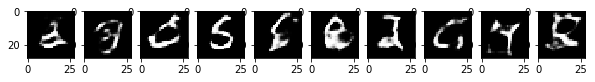

Epochs 1/10: Generator Loss: -0.958. Discriminator Loss: -0.213


Epochs 1/10: Generator Loss: -1.004. Discriminator Loss: -0.234


Epochs 1/10: Generator Loss: -0.877. Discriminator Loss: -0.282


Epochs 1/10: Generator Loss: -0.985. Discriminator Loss: -0.335


Epochs 1/10: Generator Loss: -0.867. Discriminator Loss: -0.174


Epochs 1/10: Generator Loss: -0.669. Discriminator Loss: -0.207


Epochs 1/10: Generator Loss: -0.813. Discriminator Loss: -0.234


Epochs 1/10: Generator Loss: -0.95. Discriminator Loss: -0.274


Epochs 1/10: Generator Loss: -1.019. Discriminator Loss: -0.244


Epochs 1/10: Generator Loss: -1.086. Discriminator Loss: -0.202


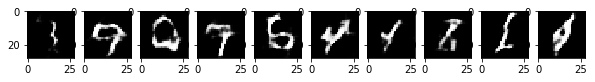

Epochs 1/10: Generator Loss: -0.998. Discriminator Loss: -0.17


Epochs 1/10: Generator Loss: -0.94. Discriminator Loss: -0.225


Epochs 1/10: Generator Loss: -1.061. Discriminator Loss: -0.259


Epochs 1/10: Generator Loss: -1.148. Discriminator Loss: -0.168


Epochs 1/10: Generator Loss: -1.138. Discriminator Loss: -0.219


Epochs 1/10: Generator Loss: -1.027. Discriminator Loss: -0.216


Epochs 1/10: Generator Loss: -0.994. Discriminator Loss: -0.217


Epochs 1/10: Generator Loss: -1.021. Discriminator Loss: -0.281


Epochs 1/10: Generator Loss: -1.103. Discriminator Loss: -0.277


Epochs 1/10: Generator Loss: -1.073. Discriminator Loss: -0.272


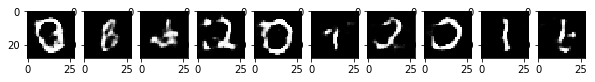

Epochs 1/10: Generator Loss: -0.861. Discriminator Loss: -0.246


Epochs 1/10: Generator Loss: -1.097. Discriminator Loss: -0.19


Epochs 1/10: Generator Loss: -1.322. Discriminator Loss: -0.266


Epochs 1/10: Generator Loss: -0.764. Discriminator Loss: -0.276


Epochs 1/10: Generator Loss: -0.757. Discriminator Loss: -0.228


Epochs 1/10: Generator Loss: -1.047. Discriminator Loss: -0.158


Epochs 1/10: Generator Loss: -1.195. Discriminator Loss: -0.26


Epochs 1/10: Generator Loss: -0.819. Discriminator Loss: -0.189


Epochs 1/10: Generator Loss: -0.859. Discriminator Loss: -0.202


Epochs 1/10: Generator Loss: -1.201. Discriminator Loss: -0.163


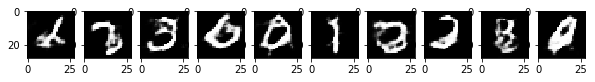

Epochs 1/10: Generator Loss: -1.185. Discriminator Loss: -0.243


Epochs 1/10: Generator Loss: -0.981. Discriminator Loss: -0.16


Epochs 1/10: Generator Loss: -0.993. Discriminator Loss: -0.184


Epochs 1/10: Generator Loss: -0.709. Discriminator Loss: -0.252


Epochs 1/10: Generator Loss: -1.026. Discriminator Loss: -0.221


Epochs 1/10: Generator Loss: -1.474. Discriminator Loss: -0.102


Epochs 1/10: Generator Loss: -0.565. Discriminator Loss: -0.172


Epochs 1/10: Generator Loss: -1.153. Discriminator Loss: -0.241


Epochs 1/10: Generator Loss: -1.08. Discriminator Loss: -0.213


Epochs 1/10: Generator Loss: -0.903. Discriminator Loss: -0.255


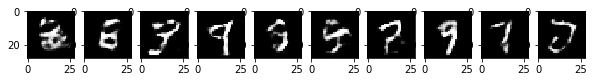

Epochs 1/10: Generator Loss: -0.835. Discriminator Loss: -0.196


Epochs 1/10: Generator Loss: -1.081. Discriminator Loss: -0.219


Epochs 1/10: Generator Loss: -1.108. Discriminator Loss: -0.2


Epochs 1/10: Generator Loss: -0.911. Discriminator Loss: -0.214


Epochs 2/10: Generator Loss: -0.65. Discriminator Loss: -0.064


Epochs 2/10: Generator Loss: -1.12. Discriminator Loss: -0.182


Epochs 2/10: Generator Loss: -0.971. Discriminator Loss: -0.222


Epochs 2/10: Generator Loss: -0.646. Discriminator Loss: -0.221


Epochs 2/10: Generator Loss: -1.098. Discriminator Loss: -0.245


Epochs 2/10: Generator Loss: -0.75. Discriminator Loss: -0.252


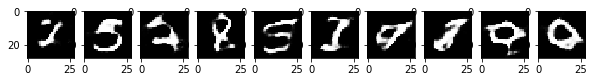

Epochs 2/10: Generator Loss: -0.929. Discriminator Loss: -0.273


Epochs 2/10: Generator Loss: -0.651. Discriminator Loss: -0.323


Epochs 2/10: Generator Loss: -0.504. Discriminator Loss: -0.236


Epochs 2/10: Generator Loss: -0.578. Discriminator Loss: -0.199


Epochs 2/10: Generator Loss: -0.861. Discriminator Loss: -0.199


Epochs 2/10: Generator Loss: -0.767. Discriminator Loss: -0.204


Epochs 2/10: Generator Loss: -0.912. Discriminator Loss: -0.239


Epochs 2/10: Generator Loss: -0.567. Discriminator Loss: -0.245


Epochs 2/10: Generator Loss: -1.135. Discriminator Loss: -0.226


Epochs 2/10: Generator Loss: -0.816. Discriminator Loss: -0.269


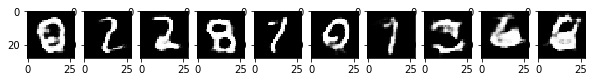

Epochs 2/10: Generator Loss: -0.941. Discriminator Loss: -0.177


Epochs 2/10: Generator Loss: -0.933. Discriminator Loss: -0.227


Epochs 2/10: Generator Loss: -0.821. Discriminator Loss: -0.214


Epochs 2/10: Generator Loss: -1.122. Discriminator Loss: -0.231


Epochs 2/10: Generator Loss: -0.712. Discriminator Loss: -0.248


Epochs 2/10: Generator Loss: -0.882. Discriminator Loss: -0.226


Epochs 2/10: Generator Loss: -0.793. Discriminator Loss: -0.256


Epochs 2/10: Generator Loss: -0.927. Discriminator Loss: -0.291


Epochs 2/10: Generator Loss: -0.74. Discriminator Loss: -0.252


Epochs 2/10: Generator Loss: -0.936. Discriminator Loss: -0.221


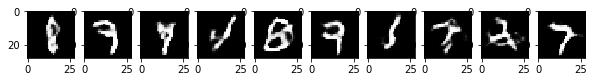

Epochs 2/10: Generator Loss: -0.908. Discriminator Loss: -0.236


Epochs 2/10: Generator Loss: -0.887. Discriminator Loss: -0.237


Epochs 2/10: Generator Loss: -1.068. Discriminator Loss: -0.212


Epochs 2/10: Generator Loss: -0.817. Discriminator Loss: -0.256


Epochs 2/10: Generator Loss: -0.878. Discriminator Loss: -0.209


Epochs 2/10: Generator Loss: -0.586. Discriminator Loss: -0.179


Epochs 2/10: Generator Loss: -0.921. Discriminator Loss: -0.184


Epochs 2/10: Generator Loss: -0.705. Discriminator Loss: -0.222


Epochs 2/10: Generator Loss: -0.718. Discriminator Loss: -0.145


Epochs 2/10: Generator Loss: -0.701. Discriminator Loss: -0.24


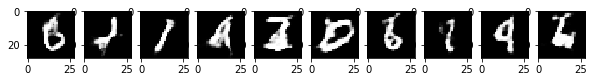

Epochs 2/10: Generator Loss: -1.22. Discriminator Loss: -0.259


Epochs 2/10: Generator Loss: -1.128. Discriminator Loss: -0.219


Epochs 2/10: Generator Loss: -0.912. Discriminator Loss: -0.234


Epochs 2/10: Generator Loss: -1.093. Discriminator Loss: -0.184


Epochs 2/10: Generator Loss: -0.979. Discriminator Loss: -0.234


Epochs 2/10: Generator Loss: -0.839. Discriminator Loss: -0.221


Epochs 2/10: Generator Loss: -1.094. Discriminator Loss: -0.221


Epochs 2/10: Generator Loss: -0.764. Discriminator Loss: -0.257


Epochs 2/10: Generator Loss: -0.83. Discriminator Loss: -0.302


Epochs 2/10: Generator Loss: -0.734. Discriminator Loss: -0.19


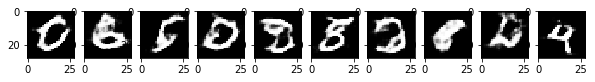

Epochs 2/10: Generator Loss: -0.77. Discriminator Loss: -0.188


Epochs 2/10: Generator Loss: -0.778. Discriminator Loss: -0.217


Epochs 2/10: Generator Loss: -0.955. Discriminator Loss: -0.162


Epochs 2/10: Generator Loss: -1.065. Discriminator Loss: -0.134


Epochs 2/10: Generator Loss: -0.925. Discriminator Loss: -0.285


Epochs 2/10: Generator Loss: -1.198. Discriminator Loss: -0.241


Epochs 2/10: Generator Loss: -1.097. Discriminator Loss: -0.127


Epochs 2/10: Generator Loss: -0.954. Discriminator Loss: -0.235


Epochs 2/10: Generator Loss: -1.033. Discriminator Loss: -0.192


Epochs 2/10: Generator Loss: -1.154. Discriminator Loss: -0.206


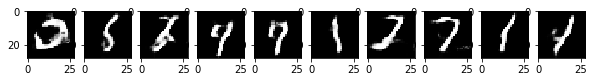

Epochs 2/10: Generator Loss: -0.851. Discriminator Loss: -0.218


Epochs 2/10: Generator Loss: -1.104. Discriminator Loss: -0.22


Epochs 2/10: Generator Loss: -1.029. Discriminator Loss: -0.204


Epochs 2/10: Generator Loss: -0.853. Discriminator Loss: -0.184


Epochs 2/10: Generator Loss: -1.213. Discriminator Loss: -0.152


Epochs 2/10: Generator Loss: -0.894. Discriminator Loss: -0.206


Epochs 2/10: Generator Loss: -1.014. Discriminator Loss: -0.208


Epochs 2/10: Generator Loss: -1.101. Discriminator Loss: -0.207


Epochs 2/10: Generator Loss: -0.982. Discriminator Loss: -0.221


Epochs 2/10: Generator Loss: -1.16. Discriminator Loss: -0.185


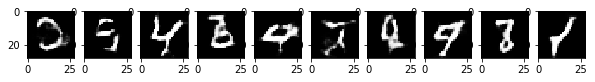

Epochs 2/10: Generator Loss: -0.902. Discriminator Loss: -0.166


Epochs 2/10: Generator Loss: -1.139. Discriminator Loss: -0.241


Epochs 2/10: Generator Loss: -0.924. Discriminator Loss: -0.234


Epochs 2/10: Generator Loss: -1.184. Discriminator Loss: -0.277


Epochs 2/10: Generator Loss: -0.756. Discriminator Loss: -0.243


Epochs 2/10: Generator Loss: -1.111. Discriminator Loss: -0.272


Epochs 2/10: Generator Loss: -0.765. Discriminator Loss: -0.214


Epochs 2/10: Generator Loss: -0.89. Discriminator Loss: -0.173


Epochs 2/10: Generator Loss: -0.962. Discriminator Loss: -0.184


Epochs 2/10: Generator Loss: -0.883. Discriminator Loss: -0.213


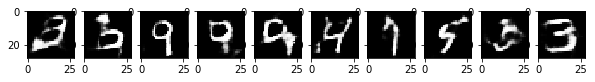

Epochs 2/10: Generator Loss: -1.217. Discriminator Loss: -0.2


Epochs 2/10: Generator Loss: -1.161. Discriminator Loss: -0.19


Epochs 2/10: Generator Loss: -1.373. Discriminator Loss: -0.247


Epochs 2/10: Generator Loss: -1.226. Discriminator Loss: -0.166


Epochs 2/10: Generator Loss: -1.029. Discriminator Loss: -0.265


Epochs 2/10: Generator Loss: -1.015. Discriminator Loss: -0.236


Epochs 2/10: Generator Loss: -1.009. Discriminator Loss: -0.244


Epochs 2/10: Generator Loss: -0.997. Discriminator Loss: -0.256


Epochs 2/10: Generator Loss: -0.972. Discriminator Loss: -0.189


Epochs 2/10: Generator Loss: -0.928. Discriminator Loss: -0.236


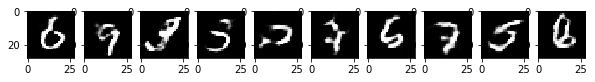

Epochs 2/10: Generator Loss: -1.059. Discriminator Loss: -0.169


Epochs 2/10: Generator Loss: -0.968. Discriminator Loss: -0.256


Epochs 2/10: Generator Loss: -0.976. Discriminator Loss: -0.246


Epochs 2/10: Generator Loss: -0.827. Discriminator Loss: -0.183


Epochs 2/10: Generator Loss: -0.92. Discriminator Loss: -0.268


Epochs 2/10: Generator Loss: -1.067. Discriminator Loss: -0.199


Epochs 2/10: Generator Loss: -0.641. Discriminator Loss: -0.186


Epochs 2/10: Generator Loss: -1.204. Discriminator Loss: -0.234


Epochs 2/10: Generator Loss: -1.019. Discriminator Loss: -0.266


Epochs 2/10: Generator Loss: -0.77. Discriminator Loss: -0.311


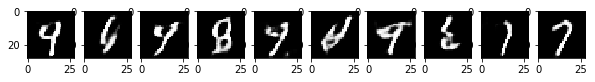

Epochs 2/10: Generator Loss: -1.112. Discriminator Loss: -0.235


Epochs 2/10: Generator Loss: -1.037. Discriminator Loss: -0.218


Epochs 2/10: Generator Loss: -1.124. Discriminator Loss: -0.227


Epochs 2/10: Generator Loss: -1.166. Discriminator Loss: -0.249


Epochs 2/10: Generator Loss: -1.081. Discriminator Loss: -0.26


Epochs 2/10: Generator Loss: -1.37. Discriminator Loss: -0.225


Epochs 2/10: Generator Loss: -1.212. Discriminator Loss: -0.216


Epochs 2/10: Generator Loss: -1.12. Discriminator Loss: -0.21


Epochs 2/10: Generator Loss: -1.197. Discriminator Loss: -0.201


Epochs 2/10: Generator Loss: -1.089. Discriminator Loss: -0.134


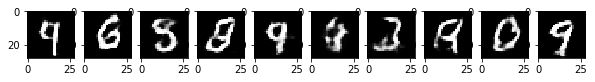

Epochs 2/10: Generator Loss: -0.834. Discriminator Loss: -0.216


Epochs 2/10: Generator Loss: -1.015. Discriminator Loss: -0.287


Epochs 2/10: Generator Loss: -0.843. Discriminator Loss: -0.117


Epochs 2/10: Generator Loss: -0.814. Discriminator Loss: -0.202


Epochs 2/10: Generator Loss: -0.55. Discriminator Loss: -0.268


Epochs 2/10: Generator Loss: -1.089. Discriminator Loss: -0.301


Epochs 2/10: Generator Loss: -0.998. Discriminator Loss: -0.227


Epochs 2/10: Generator Loss: -0.883. Discriminator Loss: -0.124


Epochs 2/10: Generator Loss: -0.945. Discriminator Loss: -0.207


Epochs 2/10: Generator Loss: -0.732. Discriminator Loss: -0.186


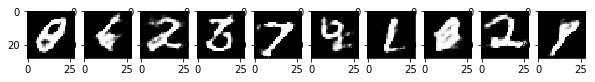

Epochs 2/10: Generator Loss: -1.082. Discriminator Loss: -0.188


Epochs 2/10: Generator Loss: -0.901. Discriminator Loss: -0.221


Epochs 2/10: Generator Loss: -1.028. Discriminator Loss: -0.24


Epochs 2/10: Generator Loss: -0.886. Discriminator Loss: -0.242


Epochs 2/10: Generator Loss: -0.901. Discriminator Loss: -0.153


Epochs 2/10: Generator Loss: -1.03. Discriminator Loss: -0.238


Epochs 2/10: Generator Loss: -0.974. Discriminator Loss: -0.193


Epochs 2/10: Generator Loss: -1.094. Discriminator Loss: -0.208


Epochs 2/10: Generator Loss: -1.012. Discriminator Loss: -0.249


Epochs 2/10: Generator Loss: -0.933. Discriminator Loss: -0.293


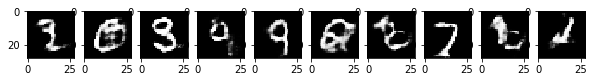

Epochs 2/10: Generator Loss: -0.976. Discriminator Loss: -0.285


Epochs 2/10: Generator Loss: -1.242. Discriminator Loss: -0.242


Epochs 2/10: Generator Loss: -1.11. Discriminator Loss: -0.175


Epochs 2/10: Generator Loss: -0.859. Discriminator Loss: -0.224


Epochs 2/10: Generator Loss: -1.099. Discriminator Loss: -0.189


Epochs 2/10: Generator Loss: -1.089. Discriminator Loss: -0.102


Epochs 2/10: Generator Loss: -0.812. Discriminator Loss: -0.134


Epochs 2/10: Generator Loss: -1.04. Discriminator Loss: -0.174


Epochs 2/10: Generator Loss: -1.33. Discriminator Loss: -0.268


Epochs 2/10: Generator Loss: -0.932. Discriminator Loss: -0.328


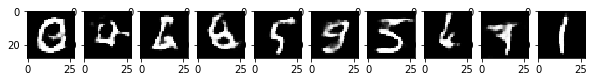

Epochs 2/10: Generator Loss: -0.959. Discriminator Loss: -0.17


Epochs 2/10: Generator Loss: -0.946. Discriminator Loss: -0.237


Epochs 2/10: Generator Loss: -0.919. Discriminator Loss: -0.256


Epochs 2/10: Generator Loss: -0.591. Discriminator Loss: -0.2


Epochs 2/10: Generator Loss: -0.832. Discriminator Loss: -0.205


Epochs 2/10: Generator Loss: -0.739. Discriminator Loss: -0.215


Epochs 2/10: Generator Loss: -1.11. Discriminator Loss: -0.217


Epochs 2/10: Generator Loss: -0.915. Discriminator Loss: -0.213


Epochs 2/10: Generator Loss: -1.443. Discriminator Loss: -0.19


Epochs 2/10: Generator Loss: -1.029. Discriminator Loss: -0.226


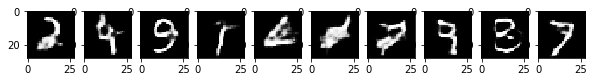

Epochs 2/10: Generator Loss: -0.983. Discriminator Loss: -0.25


Epochs 2/10: Generator Loss: -1.088. Discriminator Loss: -0.338


Epochs 2/10: Generator Loss: -1.181. Discriminator Loss: -0.287


Epochs 2/10: Generator Loss: -0.819. Discriminator Loss: -0.2


Epochs 2/10: Generator Loss: -0.876. Discriminator Loss: -0.238


Epochs 2/10: Generator Loss: -0.959. Discriminator Loss: -0.206


Epochs 2/10: Generator Loss: -1.07. Discriminator Loss: -0.218


Epochs 2/10: Generator Loss: -1.223. Discriminator Loss: -0.21


Epochs 2/10: Generator Loss: -1.346. Discriminator Loss: -0.208


Epochs 2/10: Generator Loss: -0.958. Discriminator Loss: -0.2


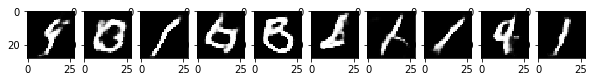

Epochs 2/10: Generator Loss: -0.91. Discriminator Loss: -0.245


Epochs 2/10: Generator Loss: -0.931. Discriminator Loss: -0.185


Epochs 2/10: Generator Loss: -1.275. Discriminator Loss: -0.215


Epochs 2/10: Generator Loss: -1.063. Discriminator Loss: -0.21


Epochs 2/10: Generator Loss: -0.984. Discriminator Loss: -0.257


Epochs 2/10: Generator Loss: -0.732. Discriminator Loss: -0.322


Epochs 2/10: Generator Loss: -0.596. Discriminator Loss: -0.311


Epochs 2/10: Generator Loss: -1.149. Discriminator Loss: -0.229


Epochs 2/10: Generator Loss: -1.39. Discriminator Loss: -0.208


Epochs 2/10: Generator Loss: -1.007. Discriminator Loss: -0.226


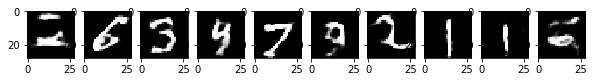

Epochs 2/10: Generator Loss: -1.127. Discriminator Loss: -0.342


Epochs 2/10: Generator Loss: -1.11. Discriminator Loss: -0.254


Epochs 2/10: Generator Loss: -1.08. Discriminator Loss: -0.147


Epochs 2/10: Generator Loss: -0.879. Discriminator Loss: -0.194


Epochs 2/10: Generator Loss: -1.432. Discriminator Loss: -0.2


Epochs 2/10: Generator Loss: -1.051. Discriminator Loss: -0.207


Epochs 2/10: Generator Loss: -1.018. Discriminator Loss: -0.169


Epochs 2/10: Generator Loss: -1.213. Discriminator Loss: -0.237


Epochs 2/10: Generator Loss: -0.907. Discriminator Loss: -0.18


Epochs 2/10: Generator Loss: -1.135. Discriminator Loss: -0.18


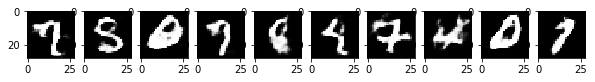

Epochs 2/10: Generator Loss: -0.956. Discriminator Loss: -0.183


Epochs 2/10: Generator Loss: -0.796. Discriminator Loss: -0.307


Epochs 2/10: Generator Loss: -0.829. Discriminator Loss: -0.231


Epochs 2/10: Generator Loss: -1.325. Discriminator Loss: -0.178


Epochs 2/10: Generator Loss: -1.236. Discriminator Loss: -0.297


Epochs 2/10: Generator Loss: -0.871. Discriminator Loss: -0.215


Epochs 2/10: Generator Loss: -1.062. Discriminator Loss: -0.208


Epochs 2/10: Generator Loss: -1.103. Discriminator Loss: -0.235


Epochs 2/10: Generator Loss: -1.098. Discriminator Loss: -0.216


Epochs 2/10: Generator Loss: -0.984. Discriminator Loss: -0.199


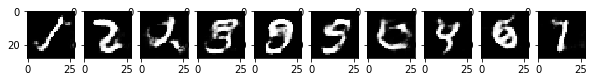

Epochs 2/10: Generator Loss: -1.206. Discriminator Loss: -0.206


Epochs 2/10: Generator Loss: -0.715. Discriminator Loss: -0.192


Epochs 3/10: Generator Loss: -0.726. Discriminator Loss: -0.09


Epochs 3/10: Generator Loss: -1.269. Discriminator Loss: -0.171


Epochs 3/10: Generator Loss: -1.079. Discriminator Loss: -0.177


Epochs 3/10: Generator Loss: -0.875. Discriminator Loss: -0.132


Epochs 3/10: Generator Loss: -0.682. Discriminator Loss: -0.236


Epochs 3/10: Generator Loss: -0.726. Discriminator Loss: -0.244


Epochs 3/10: Generator Loss: -0.724. Discriminator Loss: -0.228


Epochs 3/10: Generator Loss: -0.726. Discriminator Loss: -0.264


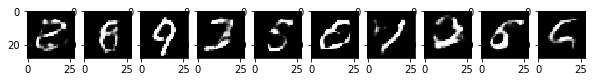

Epochs 3/10: Generator Loss: -0.592. Discriminator Loss: -0.243


Epochs 3/10: Generator Loss: -0.846. Discriminator Loss: -0.233


Epochs 3/10: Generator Loss: -0.384. Discriminator Loss: -0.214


Epochs 3/10: Generator Loss: -0.856. Discriminator Loss: -0.172


Epochs 3/10: Generator Loss: -0.747. Discriminator Loss: -0.226


Epochs 3/10: Generator Loss: -0.832. Discriminator Loss: -0.162


Epochs 3/10: Generator Loss: -0.708. Discriminator Loss: -0.268


Epochs 3/10: Generator Loss: -0.91. Discriminator Loss: -0.215


Epochs 3/10: Generator Loss: -0.804. Discriminator Loss: -0.185


Epochs 3/10: Generator Loss: -0.954. Discriminator Loss: -0.113


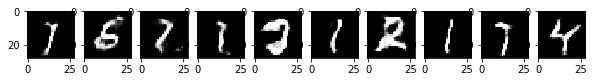

Epochs 3/10: Generator Loss: -1.066. Discriminator Loss: -0.168


Epochs 3/10: Generator Loss: -0.869. Discriminator Loss: -0.271


Epochs 3/10: Generator Loss: -0.928. Discriminator Loss: -0.246


Epochs 3/10: Generator Loss: -0.698. Discriminator Loss: -0.303


Epochs 3/10: Generator Loss: -0.828. Discriminator Loss: -0.226


Epochs 3/10: Generator Loss: -0.957. Discriminator Loss: -0.256


Epochs 3/10: Generator Loss: -0.736. Discriminator Loss: -0.196


Epochs 3/10: Generator Loss: -0.852. Discriminator Loss: -0.17


Epochs 3/10: Generator Loss: -0.789. Discriminator Loss: -0.22


Epochs 3/10: Generator Loss: -0.929. Discriminator Loss: -0.253


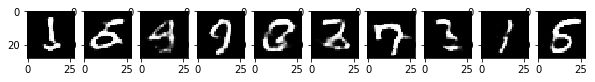

Epochs 3/10: Generator Loss: -0.948. Discriminator Loss: -0.26


Epochs 3/10: Generator Loss: -1.01. Discriminator Loss: -0.197


Epochs 3/10: Generator Loss: -0.79. Discriminator Loss: -0.218


Epochs 3/10: Generator Loss: -0.785. Discriminator Loss: -0.224


Epochs 3/10: Generator Loss: -0.803. Discriminator Loss: -0.24


Epochs 3/10: Generator Loss: -0.616. Discriminator Loss: -0.171


Epochs 3/10: Generator Loss: -0.979. Discriminator Loss: -0.194


Epochs 3/10: Generator Loss: -0.901. Discriminator Loss: -0.21


Epochs 3/10: Generator Loss: -0.892. Discriminator Loss: -0.222


Epochs 3/10: Generator Loss: -0.888. Discriminator Loss: -0.265


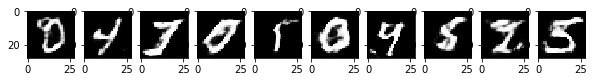

Epochs 3/10: Generator Loss: -1.111. Discriminator Loss: -0.225


Epochs 3/10: Generator Loss: -0.908. Discriminator Loss: -0.196


Epochs 3/10: Generator Loss: -1.315. Discriminator Loss: -0.076


Epochs 3/10: Generator Loss: -0.862. Discriminator Loss: -0.189


Epochs 3/10: Generator Loss: -0.712. Discriminator Loss: -0.206


Epochs 3/10: Generator Loss: -0.882. Discriminator Loss: -0.251


Epochs 3/10: Generator Loss: -0.78. Discriminator Loss: -0.257


Epochs 3/10: Generator Loss: -0.793. Discriminator Loss: -0.195


Epochs 3/10: Generator Loss: -1.054. Discriminator Loss: -0.231


Epochs 3/10: Generator Loss: -0.854. Discriminator Loss: -0.156


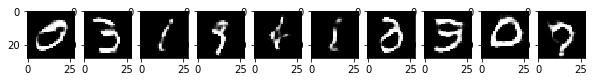

Epochs 3/10: Generator Loss: -0.689. Discriminator Loss: -0.21


Epochs 3/10: Generator Loss: -1.053. Discriminator Loss: -0.254


Epochs 3/10: Generator Loss: -1.17. Discriminator Loss: -0.224


Epochs 3/10: Generator Loss: -1.058. Discriminator Loss: -0.152


Epochs 3/10: Generator Loss: -1.286. Discriminator Loss: -0.199


Epochs 3/10: Generator Loss: -0.753. Discriminator Loss: -0.243


Epochs 3/10: Generator Loss: -0.958. Discriminator Loss: -0.235


Epochs 3/10: Generator Loss: -0.807. Discriminator Loss: -0.225


Epochs 3/10: Generator Loss: -0.806. Discriminator Loss: -0.239


Epochs 3/10: Generator Loss: -0.897. Discriminator Loss: -0.248


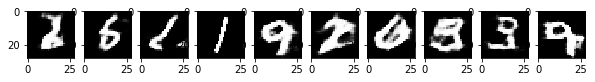

Epochs 3/10: Generator Loss: -0.841. Discriminator Loss: -0.209


Epochs 3/10: Generator Loss: -0.888. Discriminator Loss: -0.178


Epochs 3/10: Generator Loss: -0.807. Discriminator Loss: -0.164


Epochs 3/10: Generator Loss: -1.181. Discriminator Loss: -0.176


Epochs 3/10: Generator Loss: -0.813. Discriminator Loss: -0.192


Epochs 3/10: Generator Loss: -1.402. Discriminator Loss: -0.215


Epochs 3/10: Generator Loss: -0.706. Discriminator Loss: -0.204


Epochs 3/10: Generator Loss: -1.149. Discriminator Loss: -0.162


Epochs 3/10: Generator Loss: -0.622. Discriminator Loss: -0.235


Epochs 3/10: Generator Loss: -1.093. Discriminator Loss: -0.224


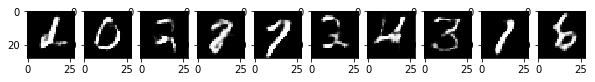

Epochs 3/10: Generator Loss: -0.883. Discriminator Loss: -0.183


Epochs 3/10: Generator Loss: -0.646. Discriminator Loss: -0.27


Epochs 3/10: Generator Loss: -0.888. Discriminator Loss: -0.299


Epochs 3/10: Generator Loss: -0.591. Discriminator Loss: -0.246


Epochs 3/10: Generator Loss: -0.716. Discriminator Loss: -0.22


Epochs 3/10: Generator Loss: -1.005. Discriminator Loss: -0.212


Epochs 3/10: Generator Loss: -0.692. Discriminator Loss: -0.234


Epochs 3/10: Generator Loss: -0.831. Discriminator Loss: -0.194


Epochs 3/10: Generator Loss: -0.692. Discriminator Loss: -0.237


Epochs 3/10: Generator Loss: -0.859. Discriminator Loss: -0.227


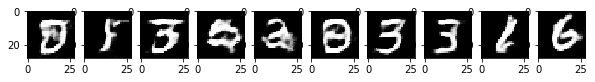

Epochs 3/10: Generator Loss: -0.93. Discriminator Loss: -0.17


Epochs 3/10: Generator Loss: -0.897. Discriminator Loss: -0.233


Epochs 3/10: Generator Loss: -0.992. Discriminator Loss: -0.134


Epochs 3/10: Generator Loss: -0.919. Discriminator Loss: -0.205


Epochs 3/10: Generator Loss: -0.86. Discriminator Loss: -0.208


Epochs 3/10: Generator Loss: -0.814. Discriminator Loss: -0.295


Epochs 3/10: Generator Loss: -1.136. Discriminator Loss: -0.203


Epochs 3/10: Generator Loss: -0.926. Discriminator Loss: -0.25


Epochs 3/10: Generator Loss: -0.87. Discriminator Loss: -0.277


Epochs 3/10: Generator Loss: -0.921. Discriminator Loss: -0.264


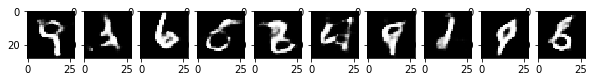

Epochs 3/10: Generator Loss: -0.808. Discriminator Loss: -0.2


Epochs 3/10: Generator Loss: -0.606. Discriminator Loss: -0.198


Epochs 3/10: Generator Loss: -0.399. Discriminator Loss: -0.255


Epochs 3/10: Generator Loss: -0.613. Discriminator Loss: -0.232


Epochs 3/10: Generator Loss: -1.132. Discriminator Loss: -0.271


Epochs 3/10: Generator Loss: -0.601. Discriminator Loss: -0.174


Epochs 3/10: Generator Loss: -0.954. Discriminator Loss: -0.292


Epochs 3/10: Generator Loss: -0.76. Discriminator Loss: -0.251


Epochs 3/10: Generator Loss: -1.005. Discriminator Loss: -0.231


Epochs 3/10: Generator Loss: -0.751. Discriminator Loss: -0.256


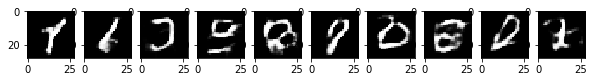

Epochs 3/10: Generator Loss: -1.116. Discriminator Loss: -0.205


Epochs 3/10: Generator Loss: -0.944. Discriminator Loss: -0.26


Epochs 3/10: Generator Loss: -1.094. Discriminator Loss: -0.215


Epochs 3/10: Generator Loss: -1.107. Discriminator Loss: -0.156


Epochs 3/10: Generator Loss: -1.097. Discriminator Loss: -0.223


Epochs 3/10: Generator Loss: -1.026. Discriminator Loss: -0.212


Epochs 3/10: Generator Loss: -1.043. Discriminator Loss: -0.162


Epochs 3/10: Generator Loss: -0.648. Discriminator Loss: -0.168


Epochs 3/10: Generator Loss: -0.792. Discriminator Loss: -0.253


Epochs 3/10: Generator Loss: -0.535. Discriminator Loss: -0.27


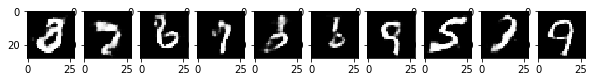

Epochs 3/10: Generator Loss: -0.607. Discriminator Loss: -0.228


Epochs 3/10: Generator Loss: -1.083. Discriminator Loss: -0.228


Epochs 3/10: Generator Loss: -1.157. Discriminator Loss: -0.243


Epochs 3/10: Generator Loss: -0.886. Discriminator Loss: -0.273


Epochs 3/10: Generator Loss: -0.86. Discriminator Loss: -0.232


Epochs 3/10: Generator Loss: -0.794. Discriminator Loss: -0.231


Epochs 3/10: Generator Loss: -0.88. Discriminator Loss: -0.212


Epochs 3/10: Generator Loss: -0.665. Discriminator Loss: -0.222


Epochs 3/10: Generator Loss: -1.074. Discriminator Loss: -0.175


Epochs 3/10: Generator Loss: -0.988. Discriminator Loss: -0.215


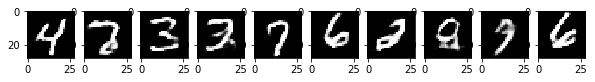

Epochs 3/10: Generator Loss: -0.926. Discriminator Loss: -0.196


Epochs 3/10: Generator Loss: -0.957. Discriminator Loss: -0.173


Epochs 3/10: Generator Loss: -0.868. Discriminator Loss: -0.257


Epochs 3/10: Generator Loss: -1.052. Discriminator Loss: -0.258


Epochs 3/10: Generator Loss: -1.013. Discriminator Loss: -0.232


Epochs 3/10: Generator Loss: -0.93. Discriminator Loss: -0.262


Epochs 3/10: Generator Loss: -0.728. Discriminator Loss: -0.216


Epochs 3/10: Generator Loss: -0.85. Discriminator Loss: -0.324


Epochs 3/10: Generator Loss: -0.859. Discriminator Loss: -0.352


Epochs 3/10: Generator Loss: -0.653. Discriminator Loss: -0.236


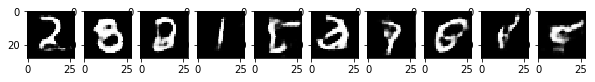

Epochs 3/10: Generator Loss: -0.942. Discriminator Loss: -0.211


Epochs 3/10: Generator Loss: -0.891. Discriminator Loss: -0.205


Epochs 3/10: Generator Loss: -0.462. Discriminator Loss: -0.18


Epochs 3/10: Generator Loss: -0.942. Discriminator Loss: -0.155


Epochs 3/10: Generator Loss: -0.969. Discriminator Loss: -0.173


Epochs 3/10: Generator Loss: -0.661. Discriminator Loss: -0.257


Epochs 3/10: Generator Loss: -0.856. Discriminator Loss: -0.305


Epochs 3/10: Generator Loss: -0.921. Discriminator Loss: -0.35


Epochs 3/10: Generator Loss: -0.66. Discriminator Loss: -0.252


Epochs 3/10: Generator Loss: -0.871. Discriminator Loss: -0.268


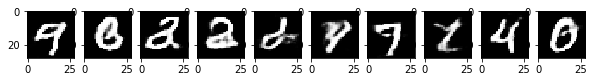

Epochs 3/10: Generator Loss: -0.809. Discriminator Loss: -0.242


Epochs 3/10: Generator Loss: -0.7. Discriminator Loss: -0.21


Epochs 3/10: Generator Loss: -0.631. Discriminator Loss: -0.2


Epochs 3/10: Generator Loss: -0.725. Discriminator Loss: -0.219


Epochs 3/10: Generator Loss: -0.867. Discriminator Loss: -0.183


Epochs 3/10: Generator Loss: -1.004. Discriminator Loss: -0.211


Epochs 3/10: Generator Loss: -0.99. Discriminator Loss: -0.172


Epochs 3/10: Generator Loss: -0.806. Discriminator Loss: -0.199


Epochs 3/10: Generator Loss: -0.915. Discriminator Loss: -0.277


Epochs 3/10: Generator Loss: -0.626. Discriminator Loss: -0.271


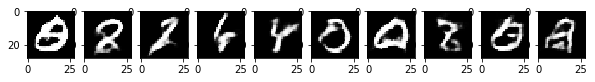

Epochs 3/10: Generator Loss: -0.865. Discriminator Loss: -0.16


Epochs 3/10: Generator Loss: -0.928. Discriminator Loss: -0.204


Epochs 3/10: Generator Loss: -1.087. Discriminator Loss: -0.275


Epochs 3/10: Generator Loss: -0.838. Discriminator Loss: -0.241


Epochs 3/10: Generator Loss: -0.843. Discriminator Loss: -0.164


Epochs 3/10: Generator Loss: -0.989. Discriminator Loss: -0.23


Epochs 3/10: Generator Loss: -0.874. Discriminator Loss: -0.195


Epochs 3/10: Generator Loss: -1.003. Discriminator Loss: -0.206


Epochs 3/10: Generator Loss: -0.831. Discriminator Loss: -0.289


Epochs 3/10: Generator Loss: -0.99. Discriminator Loss: -0.231


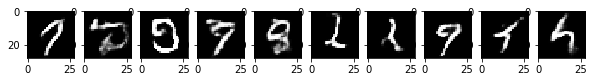

Epochs 3/10: Generator Loss: -0.928. Discriminator Loss: -0.249


Epochs 3/10: Generator Loss: -0.972. Discriminator Loss: -0.265


Epochs 3/10: Generator Loss: -0.965. Discriminator Loss: -0.312


Epochs 3/10: Generator Loss: -0.824. Discriminator Loss: -0.279


Epochs 3/10: Generator Loss: -0.792. Discriminator Loss: -0.317


Epochs 3/10: Generator Loss: -0.836. Discriminator Loss: -0.23


Epochs 3/10: Generator Loss: -1.052. Discriminator Loss: -0.195


Epochs 3/10: Generator Loss: -1.098. Discriminator Loss: -0.357


Epochs 3/10: Generator Loss: -0.89. Discriminator Loss: -0.294


Epochs 3/10: Generator Loss: -0.966. Discriminator Loss: -0.123


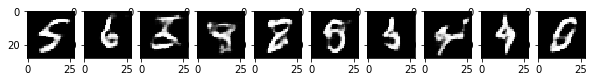

Epochs 3/10: Generator Loss: -1.112. Discriminator Loss: -0.203


Epochs 3/10: Generator Loss: -1.494. Discriminator Loss: -0.104


Epochs 3/10: Generator Loss: -1.177. Discriminator Loss: -0.171


Epochs 3/10: Generator Loss: -1.268. Discriminator Loss: -0.211


Epochs 3/10: Generator Loss: -0.809. Discriminator Loss: -0.219


Epochs 3/10: Generator Loss: -1.26. Discriminator Loss: -0.217


Epochs 3/10: Generator Loss: -0.808. Discriminator Loss: -0.105


Epochs 3/10: Generator Loss: -0.581. Discriminator Loss: -0.177


Epochs 3/10: Generator Loss: -0.799. Discriminator Loss: -0.231


Epochs 3/10: Generator Loss: -0.88. Discriminator Loss: -0.221


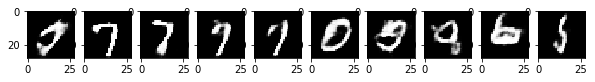

Epochs 3/10: Generator Loss: -0.937. Discriminator Loss: -0.139


Epochs 3/10: Generator Loss: -0.801. Discriminator Loss: -0.166


Epochs 3/10: Generator Loss: -0.839. Discriminator Loss: -0.272


Epochs 3/10: Generator Loss: -0.882. Discriminator Loss: -0.198


Epochs 3/10: Generator Loss: -0.804. Discriminator Loss: -0.23


Epochs 3/10: Generator Loss: -0.779. Discriminator Loss: -0.203


Epochs 3/10: Generator Loss: -1.181. Discriminator Loss: -0.177


Epochs 3/10: Generator Loss: -0.895. Discriminator Loss: -0.144


Epochs 3/10: Generator Loss: -0.772. Discriminator Loss: -0.162


Epochs 4/10: Generator Loss: -0.849. Discriminator Loss: -0.031


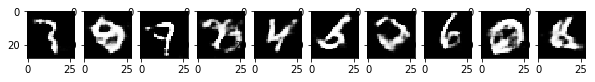

Epochs 4/10: Generator Loss: -0.999. Discriminator Loss: -0.193


Epochs 4/10: Generator Loss: -1.073. Discriminator Loss: -0.174


Epochs 4/10: Generator Loss: -0.63. Discriminator Loss: -0.187


Epochs 4/10: Generator Loss: -1.011. Discriminator Loss: -0.202


Epochs 4/10: Generator Loss: -0.367. Discriminator Loss: -0.271


Epochs 4/10: Generator Loss: -0.605. Discriminator Loss: -0.294


Epochs 4/10: Generator Loss: -0.54. Discriminator Loss: -0.273


Epochs 4/10: Generator Loss: -0.468. Discriminator Loss: -0.239


Epochs 4/10: Generator Loss: -0.23. Discriminator Loss: -0.278


Epochs 4/10: Generator Loss: -0.889. Discriminator Loss: -0.224


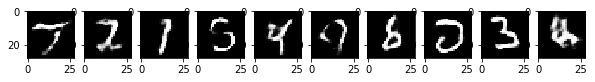

Epochs 4/10: Generator Loss: -0.153. Discriminator Loss: -0.18


Epochs 4/10: Generator Loss: -0.846. Discriminator Loss: -0.215


Epochs 4/10: Generator Loss: -0.188. Discriminator Loss: -0.198


Epochs 4/10: Generator Loss: -0.671. Discriminator Loss: -0.233


Epochs 4/10: Generator Loss: -0.327. Discriminator Loss: -0.218


Epochs 4/10: Generator Loss: -0.676. Discriminator Loss: -0.185


Epochs 4/10: Generator Loss: -0.575. Discriminator Loss: -0.19


Epochs 4/10: Generator Loss: -0.955. Discriminator Loss: -0.183


Epochs 4/10: Generator Loss: -0.883. Discriminator Loss: -0.198


Epochs 4/10: Generator Loss: -0.398. Discriminator Loss: -0.245


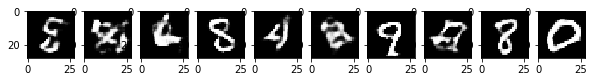

Epochs 4/10: Generator Loss: -0.83. Discriminator Loss: -0.305


Epochs 4/10: Generator Loss: -0.346. Discriminator Loss: -0.256


Epochs 4/10: Generator Loss: -0.597. Discriminator Loss: -0.323


Epochs 4/10: Generator Loss: -0.265. Discriminator Loss: -0.306


Epochs 4/10: Generator Loss: -0.465. Discriminator Loss: -0.193


Epochs 4/10: Generator Loss: -0.517. Discriminator Loss: -0.221


Epochs 4/10: Generator Loss: -0.685. Discriminator Loss: -0.227


Epochs 4/10: Generator Loss: -0.593. Discriminator Loss: -0.253


Epochs 4/10: Generator Loss: -0.542. Discriminator Loss: -0.269


Epochs 4/10: Generator Loss: -0.814. Discriminator Loss: -0.199


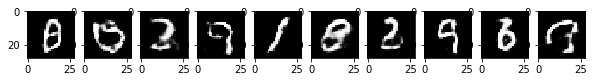

Epochs 4/10: Generator Loss: -0.433. Discriminator Loss: -0.184


Epochs 4/10: Generator Loss: -0.475. Discriminator Loss: -0.184


Epochs 4/10: Generator Loss: -0.11. Discriminator Loss: -0.233


Epochs 4/10: Generator Loss: -0.614. Discriminator Loss: -0.167


Epochs 4/10: Generator Loss: -0.465. Discriminator Loss: -0.199


Epochs 4/10: Generator Loss: -0.652. Discriminator Loss: -0.292


Epochs 4/10: Generator Loss: -0.973. Discriminator Loss: -0.242


Epochs 4/10: Generator Loss: -0.888. Discriminator Loss: -0.299


Epochs 4/10: Generator Loss: -0.764. Discriminator Loss: -0.191


Epochs 4/10: Generator Loss: -0.946. Discriminator Loss: -0.118


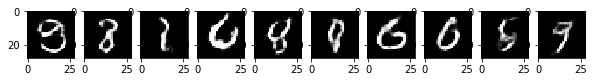

Epochs 4/10: Generator Loss: -0.688. Discriminator Loss: -0.169


Epochs 4/10: Generator Loss: -0.717. Discriminator Loss: -0.118


Epochs 4/10: Generator Loss: -0.418. Discriminator Loss: -0.238


Epochs 4/10: Generator Loss: -0.505. Discriminator Loss: -0.301


Epochs 4/10: Generator Loss: -0.287. Discriminator Loss: -0.22


Epochs 4/10: Generator Loss: -0.479. Discriminator Loss: -0.238


Epochs 4/10: Generator Loss: -0.438. Discriminator Loss: -0.18


Epochs 4/10: Generator Loss: -0.693. Discriminator Loss: -0.192


Epochs 4/10: Generator Loss: -0.507. Discriminator Loss: -0.19


Epochs 4/10: Generator Loss: -0.352. Discriminator Loss: -0.176


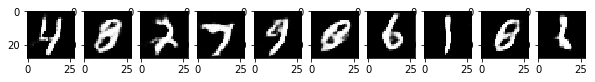

Epochs 4/10: Generator Loss: -0.476. Discriminator Loss: -0.166


Epochs 4/10: Generator Loss: -0.589. Discriminator Loss: -0.211


Epochs 4/10: Generator Loss: -0.374. Discriminator Loss: -0.251


Epochs 4/10: Generator Loss: -0.454. Discriminator Loss: -0.217


Epochs 4/10: Generator Loss: -0.503. Discriminator Loss: -0.241


Epochs 4/10: Generator Loss: -0.286. Discriminator Loss: -0.235


Epochs 4/10: Generator Loss: -0.323. Discriminator Loss: -0.232


Epochs 4/10: Generator Loss: -0.37. Discriminator Loss: -0.212


Epochs 4/10: Generator Loss: -0.599. Discriminator Loss: -0.201


Epochs 4/10: Generator Loss: -0.426. Discriminator Loss: -0.22


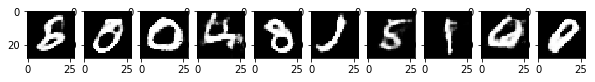

Epochs 4/10: Generator Loss: -0.399. Discriminator Loss: -0.14


Epochs 4/10: Generator Loss: -0.766. Discriminator Loss: -0.148


Epochs 4/10: Generator Loss: -0.64. Discriminator Loss: -0.211


Epochs 4/10: Generator Loss: -0.721. Discriminator Loss: -0.178


Epochs 4/10: Generator Loss: -0.669. Discriminator Loss: -0.204


Epochs 4/10: Generator Loss: -0.668. Discriminator Loss: -0.142


Epochs 4/10: Generator Loss: -0.717. Discriminator Loss: -0.233


Epochs 4/10: Generator Loss: -0.661. Discriminator Loss: -0.227


Epochs 4/10: Generator Loss: -0.88. Discriminator Loss: -0.245


Epochs 4/10: Generator Loss: -0.363. Discriminator Loss: -0.246


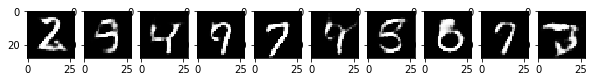

Epochs 4/10: Generator Loss: -0.583. Discriminator Loss: -0.257


Epochs 4/10: Generator Loss: -0.415. Discriminator Loss: -0.196


Epochs 4/10: Generator Loss: -0.251. Discriminator Loss: -0.221


Epochs 4/10: Generator Loss: -0.417. Discriminator Loss: -0.214


Epochs 4/10: Generator Loss: -0.523. Discriminator Loss: -0.228


Epochs 4/10: Generator Loss: -0.772. Discriminator Loss: -0.245


Epochs 4/10: Generator Loss: -0.519. Discriminator Loss: -0.216


Epochs 4/10: Generator Loss: -0.803. Discriminator Loss: -0.196


Epochs 4/10: Generator Loss: -0.578. Discriminator Loss: -0.232


Epochs 4/10: Generator Loss: -0.443. Discriminator Loss: -0.223


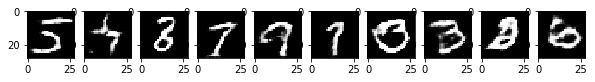

Epochs 4/10: Generator Loss: -0.603. Discriminator Loss: -0.238


Epochs 4/10: Generator Loss: -0.553. Discriminator Loss: -0.257


Epochs 4/10: Generator Loss: -0.628. Discriminator Loss: -0.239


Epochs 4/10: Generator Loss: -0.619. Discriminator Loss: -0.194


Epochs 4/10: Generator Loss: -0.695. Discriminator Loss: -0.227


Epochs 4/10: Generator Loss: -0.726. Discriminator Loss: -0.23


Epochs 4/10: Generator Loss: -0.66. Discriminator Loss: -0.251


Epochs 4/10: Generator Loss: -0.613. Discriminator Loss: -0.218


Epochs 4/10: Generator Loss: -0.508. Discriminator Loss: -0.174


Epochs 4/10: Generator Loss: -0.472. Discriminator Loss: -0.225


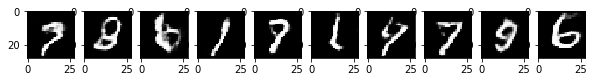

Epochs 4/10: Generator Loss: -0.447. Discriminator Loss: -0.148


Epochs 4/10: Generator Loss: -0.544. Discriminator Loss: -0.233


Epochs 4/10: Generator Loss: -0.724. Discriminator Loss: -0.245


Epochs 4/10: Generator Loss: -0.558. Discriminator Loss: -0.243


Epochs 4/10: Generator Loss: -0.501. Discriminator Loss: -0.305


Epochs 4/10: Generator Loss: -0.564. Discriminator Loss: -0.29


Epochs 4/10: Generator Loss: -0.468. Discriminator Loss: -0.221


Epochs 4/10: Generator Loss: -0.509. Discriminator Loss: -0.219


Epochs 4/10: Generator Loss: -0.819. Discriminator Loss: -0.263


Epochs 4/10: Generator Loss: -0.909. Discriminator Loss: -0.221


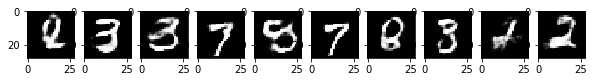

Epochs 4/10: Generator Loss: -1.052. Discriminator Loss: -0.225


Epochs 4/10: Generator Loss: -0.815. Discriminator Loss: -0.19


Epochs 4/10: Generator Loss: -0.739. Discriminator Loss: -0.186


Epochs 4/10: Generator Loss: -0.803. Discriminator Loss: -0.198


Epochs 4/10: Generator Loss: -0.634. Discriminator Loss: -0.125


Epochs 4/10: Generator Loss: -0.32. Discriminator Loss: -0.205


Epochs 4/10: Generator Loss: -0.426. Discriminator Loss: -0.259


Epochs 4/10: Generator Loss: -0.16. Discriminator Loss: -0.226


Epochs 4/10: Generator Loss: -0.456. Discriminator Loss: -0.254


Epochs 4/10: Generator Loss: -0.434. Discriminator Loss: -0.229


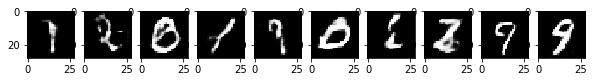

Epochs 4/10: Generator Loss: -0.71. Discriminator Loss: -0.26


Epochs 4/10: Generator Loss: -0.51. Discriminator Loss: -0.236


Epochs 4/10: Generator Loss: -0.496. Discriminator Loss: -0.217


Epochs 4/10: Generator Loss: -0.17. Discriminator Loss: -0.182


Epochs 4/10: Generator Loss: -0.709. Discriminator Loss: -0.173


Epochs 4/10: Generator Loss: -0.557. Discriminator Loss: -0.219


Epochs 4/10: Generator Loss: -0.647. Discriminator Loss: -0.222


Epochs 4/10: Generator Loss: -0.627. Discriminator Loss: -0.201


Epochs 4/10: Generator Loss: -0.946. Discriminator Loss: -0.147


Epochs 4/10: Generator Loss: -0.463. Discriminator Loss: -0.234


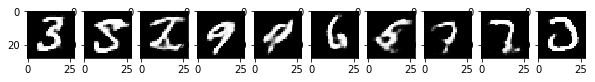

Epochs 4/10: Generator Loss: -0.716. Discriminator Loss: -0.222


Epochs 4/10: Generator Loss: -0.446. Discriminator Loss: -0.225


Epochs 4/10: Generator Loss: -0.65. Discriminator Loss: -0.247


Epochs 4/10: Generator Loss: -0.469. Discriminator Loss: -0.252


Epochs 4/10: Generator Loss: -0.335. Discriminator Loss: -0.275


Epochs 4/10: Generator Loss: -0.35. Discriminator Loss: -0.287


Epochs 4/10: Generator Loss: -0.317. Discriminator Loss: -0.261


Epochs 4/10: Generator Loss: -0.38. Discriminator Loss: -0.233


Epochs 4/10: Generator Loss: -0.077. Discriminator Loss: -0.262


Epochs 4/10: Generator Loss: -0.228. Discriminator Loss: -0.227


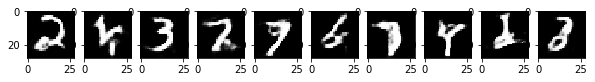

Epochs 4/10: Generator Loss: -0.209. Discriminator Loss: -0.117


Epochs 4/10: Generator Loss: -0.365. Discriminator Loss: -0.125


Epochs 4/10: Generator Loss: -0.612. Discriminator Loss: -0.228


Epochs 4/10: Generator Loss: -0.741. Discriminator Loss: -0.323


Epochs 4/10: Generator Loss: -0.646. Discriminator Loss: -0.343


Epochs 4/10: Generator Loss: -0.708. Discriminator Loss: -0.229


Epochs 4/10: Generator Loss: -0.863. Discriminator Loss: -0.204


Epochs 4/10: Generator Loss: -0.462. Discriminator Loss: -0.226


Epochs 4/10: Generator Loss: -0.294. Discriminator Loss: -0.205


Epochs 4/10: Generator Loss: -0.601. Discriminator Loss: -0.247


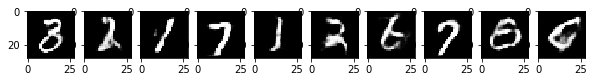

Epochs 4/10: Generator Loss: -0.39. Discriminator Loss: -0.177


Epochs 4/10: Generator Loss: -0.376. Discriminator Loss: -0.195


Epochs 4/10: Generator Loss: -0.45. Discriminator Loss: -0.218


Epochs 4/10: Generator Loss: -0.737. Discriminator Loss: -0.265


Epochs 4/10: Generator Loss: -0.607. Discriminator Loss: -0.184


Epochs 4/10: Generator Loss: -0.501. Discriminator Loss: -0.312


Epochs 4/10: Generator Loss: -0.595. Discriminator Loss: -0.272


Epochs 4/10: Generator Loss: -0.372. Discriminator Loss: -0.205


Epochs 4/10: Generator Loss: -0.314. Discriminator Loss: -0.222


Epochs 4/10: Generator Loss: -0.236. Discriminator Loss: -0.264


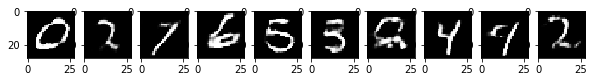

Epochs 4/10: Generator Loss: -0.351. Discriminator Loss: -0.263


Epochs 4/10: Generator Loss: -0.408. Discriminator Loss: -0.21


Epochs 4/10: Generator Loss: -0.507. Discriminator Loss: -0.175


Epochs 4/10: Generator Loss: -0.631. Discriminator Loss: -0.258


Epochs 4/10: Generator Loss: -0.302. Discriminator Loss: -0.231


Epochs 4/10: Generator Loss: -0.172. Discriminator Loss: -0.215


Epochs 4/10: Generator Loss: 0.044. Discriminator Loss: -0.199


Epochs 4/10: Generator Loss: -0.431. Discriminator Loss: -0.207


Epochs 4/10: Generator Loss: -0.205. Discriminator Loss: -0.188


Epochs 4/10: Generator Loss: -0.357. Discriminator Loss: -0.266


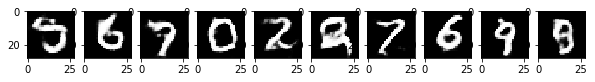

Epochs 4/10: Generator Loss: -0.108. Discriminator Loss: -0.278


Epochs 4/10: Generator Loss: 0.213. Discriminator Loss: -0.324


Epochs 4/10: Generator Loss: -0.007. Discriminator Loss: -0.271


Epochs 4/10: Generator Loss: -0.044. Discriminator Loss: -0.194


Epochs 4/10: Generator Loss: -0.481. Discriminator Loss: -0.253


Epochs 4/10: Generator Loss: -0.509. Discriminator Loss: -0.275


Epochs 4/10: Generator Loss: -0.521. Discriminator Loss: -0.282


Epochs 4/10: Generator Loss: -0.418. Discriminator Loss: -0.232


Epochs 4/10: Generator Loss: -0.36. Discriminator Loss: -0.183


Epochs 4/10: Generator Loss: -0.846. Discriminator Loss: -0.216


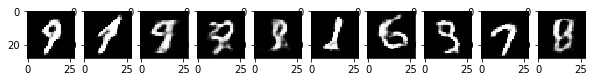

Epochs 4/10: Generator Loss: -0.49. Discriminator Loss: -0.191


Epochs 4/10: Generator Loss: -0.639. Discriminator Loss: -0.235


Epochs 4/10: Generator Loss: -0.44. Discriminator Loss: -0.256


Epochs 4/10: Generator Loss: -0.273. Discriminator Loss: -0.236


Epochs 4/10: Generator Loss: -0.228. Discriminator Loss: -0.171


Epochs 4/10: Generator Loss: -0.469. Discriminator Loss: -0.175


Epochs 4/10: Generator Loss: -0.16. Discriminator Loss: -0.297


Epochs 4/10: Generator Loss: 0.321. Discriminator Loss: -0.269


Epochs 4/10: Generator Loss: -0.661. Discriminator Loss: -0.119


Epochs 4/10: Generator Loss: -0.142. Discriminator Loss: -0.219


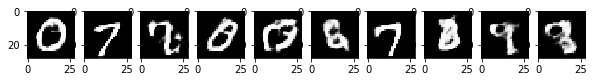

Epochs 4/10: Generator Loss: -0.323. Discriminator Loss: -0.224


Epochs 4/10: Generator Loss: -0.414. Discriminator Loss: -0.218


Epochs 4/10: Generator Loss: -0.3. Discriminator Loss: -0.182


Epochs 4/10: Generator Loss: -0.535. Discriminator Loss: -0.208


Epochs 4/10: Generator Loss: -0.376. Discriminator Loss: -0.16


Epochs 4/10: Generator Loss: -0.474. Discriminator Loss: -0.214


Epochs 4/10: Generator Loss: -0.202. Discriminator Loss: -0.243


Epochs 5/10: Generator Loss: 0.185. Discriminator Loss: -0.147


Epochs 5/10: Generator Loss: -0.805. Discriminator Loss: -0.191


Epochs 5/10: Generator Loss: -0.091. Discriminator Loss: -0.173


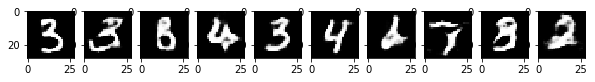

Epochs 5/10: Generator Loss: -0.586. Discriminator Loss: -0.202


Epochs 5/10: Generator Loss: -0.155. Discriminator Loss: -0.219


Epochs 5/10: Generator Loss: -0.268. Discriminator Loss: -0.243


Epochs 5/10: Generator Loss: -0.209. Discriminator Loss: -0.222


Epochs 5/10: Generator Loss: -0.062. Discriminator Loss: -0.251


Epochs 5/10: Generator Loss: -0.093. Discriminator Loss: -0.239


Epochs 5/10: Generator Loss: -0.186. Discriminator Loss: -0.229


Epochs 5/10: Generator Loss: 0.02. Discriminator Loss: -0.173


Epochs 5/10: Generator Loss: -0.345. Discriminator Loss: -0.176


Epochs 5/10: Generator Loss: -0.057. Discriminator Loss: -0.21


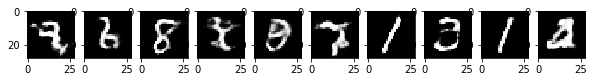

Epochs 5/10: Generator Loss: 0.027. Discriminator Loss: -0.144


Epochs 5/10: Generator Loss: -0.187. Discriminator Loss: -0.176


Epochs 5/10: Generator Loss: -0.11. Discriminator Loss: -0.237


Epochs 5/10: Generator Loss: -0.187. Discriminator Loss: -0.143


Epochs 5/10: Generator Loss: -0.433. Discriminator Loss: -0.24


Epochs 5/10: Generator Loss: -0.329. Discriminator Loss: -0.126


Epochs 5/10: Generator Loss: -0.228. Discriminator Loss: -0.242


Epochs 5/10: Generator Loss: -0.108. Discriminator Loss: -0.246


Epochs 5/10: Generator Loss: -0.092. Discriminator Loss: -0.232


Epochs 5/10: Generator Loss: -0.057. Discriminator Loss: -0.244


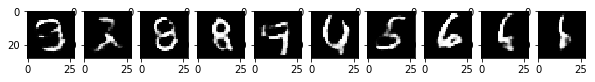

Epochs 5/10: Generator Loss: -0.244. Discriminator Loss: -0.282


Epochs 5/10: Generator Loss: -0.086. Discriminator Loss: -0.237


Epochs 5/10: Generator Loss: -0.392. Discriminator Loss: -0.111


Epochs 5/10: Generator Loss: -0.101. Discriminator Loss: -0.214


Epochs 5/10: Generator Loss: -0.567. Discriminator Loss: -0.21


Epochs 5/10: Generator Loss: -0.425. Discriminator Loss: -0.198


Epochs 5/10: Generator Loss: -0.38. Discriminator Loss: -0.21


Epochs 5/10: Generator Loss: -0.242. Discriminator Loss: -0.189


Epochs 5/10: Generator Loss: -0.098. Discriminator Loss: -0.182


Epochs 5/10: Generator Loss: -0.266. Discriminator Loss: -0.229


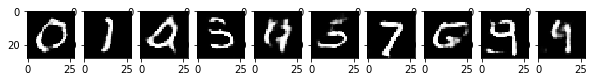

Epochs 5/10: Generator Loss: 0.053. Discriminator Loss: -0.215


Epochs 5/10: Generator Loss: -0.556. Discriminator Loss: -0.219


Epochs 5/10: Generator Loss: -0.103. Discriminator Loss: -0.25


Epochs 5/10: Generator Loss: -0.656. Discriminator Loss: -0.293


Epochs 5/10: Generator Loss: -0.266. Discriminator Loss: -0.315


Epochs 5/10: Generator Loss: -0.545. Discriminator Loss: -0.209


Epochs 5/10: Generator Loss: -0.404. Discriminator Loss: -0.167


Epochs 5/10: Generator Loss: -0.391. Discriminator Loss: -0.193


Epochs 5/10: Generator Loss: -0.036. Discriminator Loss: -0.187


Epochs 5/10: Generator Loss: -0.103. Discriminator Loss: -0.197


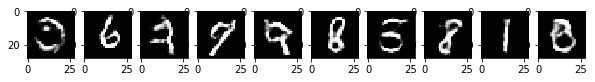

Epochs 5/10: Generator Loss: -0.024. Discriminator Loss: -0.258


Epochs 5/10: Generator Loss: 0.072. Discriminator Loss: -0.255


Epochs 5/10: Generator Loss: -0.143. Discriminator Loss: -0.163


Epochs 5/10: Generator Loss: -0.167. Discriminator Loss: -0.245


Epochs 5/10: Generator Loss: -0.227. Discriminator Loss: -0.213


Epochs 5/10: Generator Loss: 0.058. Discriminator Loss: -0.181


Epochs 5/10: Generator Loss: 0.081. Discriminator Loss: -0.202


Epochs 5/10: Generator Loss: -0.086. Discriminator Loss: -0.209


Epochs 5/10: Generator Loss: 0.005. Discriminator Loss: -0.195


Epochs 5/10: Generator Loss: -0.171. Discriminator Loss: -0.184


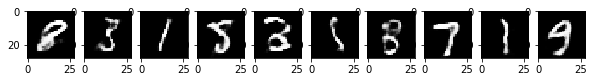

Epochs 5/10: Generator Loss: 0.269. Discriminator Loss: -0.238


Epochs 5/10: Generator Loss: 0.055. Discriminator Loss: -0.259


Epochs 5/10: Generator Loss: 0.245. Discriminator Loss: -0.235


Epochs 5/10: Generator Loss: 0.152. Discriminator Loss: -0.197


Epochs 5/10: Generator Loss: 0.267. Discriminator Loss: -0.215


Epochs 5/10: Generator Loss: 0.22. Discriminator Loss: -0.206


Epochs 5/10: Generator Loss: 0.19. Discriminator Loss: -0.2


Epochs 5/10: Generator Loss: -0.038. Discriminator Loss: -0.187


Epochs 5/10: Generator Loss: -0.243. Discriminator Loss: -0.187


Epochs 5/10: Generator Loss: -0.141. Discriminator Loss: -0.19


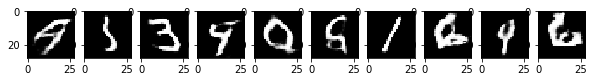

Epochs 5/10: Generator Loss: -0.332. Discriminator Loss: -0.193


Epochs 5/10: Generator Loss: 0.222. Discriminator Loss: -0.2


Epochs 5/10: Generator Loss: -0.276. Discriminator Loss: -0.193


Epochs 5/10: Generator Loss: 0.003. Discriminator Loss: -0.183


Epochs 5/10: Generator Loss: -0.443. Discriminator Loss: -0.16


Epochs 5/10: Generator Loss: -0.106. Discriminator Loss: -0.202


Epochs 5/10: Generator Loss: -0.32. Discriminator Loss: -0.195


Epochs 5/10: Generator Loss: 0.119. Discriminator Loss: -0.348


Epochs 5/10: Generator Loss: 0.142. Discriminator Loss: -0.242


Epochs 5/10: Generator Loss: 0.142. Discriminator Loss: -0.223


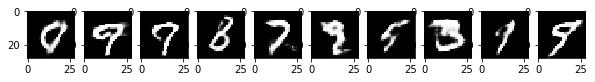

Epochs 5/10: Generator Loss: 0.042. Discriminator Loss: -0.215


Epochs 5/10: Generator Loss: -0.155. Discriminator Loss: -0.223


Epochs 5/10: Generator Loss: 0.099. Discriminator Loss: -0.245


Epochs 5/10: Generator Loss: -0.163. Discriminator Loss: -0.268


Epochs 5/10: Generator Loss: -0.07. Discriminator Loss: -0.213


Epochs 5/10: Generator Loss: -0.108. Discriminator Loss: -0.21


Epochs 5/10: Generator Loss: 0.007. Discriminator Loss: -0.245


Epochs 5/10: Generator Loss: -0.183. Discriminator Loss: -0.21


Epochs 5/10: Generator Loss: -0.0. Discriminator Loss: -0.279


Epochs 5/10: Generator Loss: -0.141. Discriminator Loss: -0.323


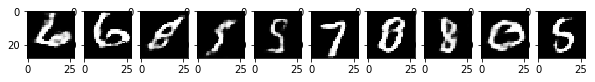

Epochs 5/10: Generator Loss: -0.345. Discriminator Loss: -0.271


Epochs 5/10: Generator Loss: -0.223. Discriminator Loss: -0.198


Epochs 5/10: Generator Loss: -0.25. Discriminator Loss: -0.222


Epochs 5/10: Generator Loss: -0.331. Discriminator Loss: -0.274


Epochs 5/10: Generator Loss: -0.157. Discriminator Loss: -0.2


Epochs 5/10: Generator Loss: -0.05. Discriminator Loss: -0.217


Epochs 5/10: Generator Loss: 0.105. Discriminator Loss: -0.195


Epochs 5/10: Generator Loss: 0.175. Discriminator Loss: -0.257


Epochs 5/10: Generator Loss: 0.124. Discriminator Loss: -0.175


Epochs 5/10: Generator Loss: -0.171. Discriminator Loss: -0.229


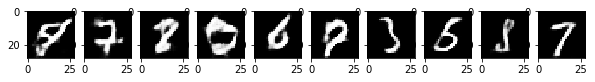

Epochs 5/10: Generator Loss: -0.066. Discriminator Loss: -0.262


Epochs 5/10: Generator Loss: -0.01. Discriminator Loss: -0.276


Epochs 5/10: Generator Loss: -0.05. Discriminator Loss: -0.297


Epochs 5/10: Generator Loss: -0.047. Discriminator Loss: -0.243


Epochs 5/10: Generator Loss: -0.152. Discriminator Loss: -0.203


Epochs 5/10: Generator Loss: -0.438. Discriminator Loss: -0.227


Epochs 5/10: Generator Loss: -0.196. Discriminator Loss: -0.233


Epochs 5/10: Generator Loss: -0.639. Discriminator Loss: -0.222


Epochs 5/10: Generator Loss: -0.5. Discriminator Loss: -0.177


Epochs 5/10: Generator Loss: -0.554. Discriminator Loss: -0.214


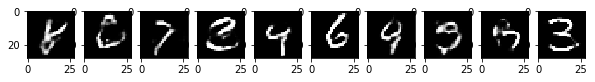

Epochs 5/10: Generator Loss: -0.513. Discriminator Loss: -0.228


Epochs 5/10: Generator Loss: -0.253. Discriminator Loss: -0.152


Epochs 5/10: Generator Loss: -0.278. Discriminator Loss: -0.169


Epochs 5/10: Generator Loss: -0.06. Discriminator Loss: -0.189


Epochs 5/10: Generator Loss: 0.194. Discriminator Loss: -0.229


Epochs 5/10: Generator Loss: -0.218. Discriminator Loss: -0.228


Epochs 5/10: Generator Loss: -0.047. Discriminator Loss: -0.289


Epochs 5/10: Generator Loss: -0.384. Discriminator Loss: -0.233


Epochs 5/10: Generator Loss: -0.229. Discriminator Loss: -0.216


Epochs 5/10: Generator Loss: 0.09. Discriminator Loss: -0.16


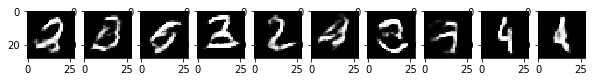

Epochs 5/10: Generator Loss: -0.098. Discriminator Loss: -0.217


Epochs 5/10: Generator Loss: -0.286. Discriminator Loss: -0.177


Epochs 5/10: Generator Loss: -0.371. Discriminator Loss: -0.212


Epochs 5/10: Generator Loss: -0.28. Discriminator Loss: -0.194


Epochs 5/10: Generator Loss: -0.065. Discriminator Loss: -0.156


Epochs 5/10: Generator Loss: -0.317. Discriminator Loss: -0.213


Epochs 5/10: Generator Loss: -0.283. Discriminator Loss: -0.189


Epochs 5/10: Generator Loss: -0.225. Discriminator Loss: -0.223


Epochs 5/10: Generator Loss: -0.351. Discriminator Loss: -0.266


Epochs 5/10: Generator Loss: -0.289. Discriminator Loss: -0.239


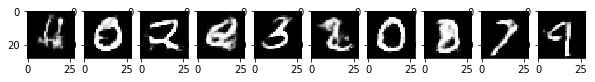

Epochs 5/10: Generator Loss: -0.225. Discriminator Loss: -0.289


Epochs 5/10: Generator Loss: -0.053. Discriminator Loss: -0.268


Epochs 5/10: Generator Loss: -0.229. Discriminator Loss: -0.298


Epochs 5/10: Generator Loss: -0.056. Discriminator Loss: -0.272


Epochs 5/10: Generator Loss: 0.038. Discriminator Loss: -0.261


Epochs 5/10: Generator Loss: -0.158. Discriminator Loss: -0.243


Epochs 5/10: Generator Loss: 0.086. Discriminator Loss: -0.322


Epochs 5/10: Generator Loss: 0.452. Discriminator Loss: -0.211


Epochs 5/10: Generator Loss: -0.017. Discriminator Loss: -0.157


Epochs 5/10: Generator Loss: -0.161. Discriminator Loss: -0.162


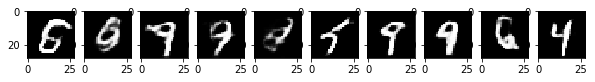

Epochs 5/10: Generator Loss: -0.106. Discriminator Loss: -0.205


Epochs 5/10: Generator Loss: -0.174. Discriminator Loss: -0.343


Epochs 5/10: Generator Loss: -0.723. Discriminator Loss: -0.277


Epochs 5/10: Generator Loss: -0.314. Discriminator Loss: -0.257


Epochs 5/10: Generator Loss: -0.431. Discriminator Loss: -0.242


Epochs 5/10: Generator Loss: -0.471. Discriminator Loss: -0.195


Epochs 5/10: Generator Loss: -0.324. Discriminator Loss: -0.232


Epochs 5/10: Generator Loss: 0.044. Discriminator Loss: -0.263


Epochs 5/10: Generator Loss: -0.148. Discriminator Loss: -0.261


Epochs 5/10: Generator Loss: -0.361. Discriminator Loss: -0.163


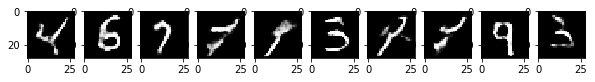

Epochs 5/10: Generator Loss: -0.543. Discriminator Loss: -0.201


Epochs 5/10: Generator Loss: -0.36. Discriminator Loss: -0.212


Epochs 5/10: Generator Loss: -0.148. Discriminator Loss: -0.243


Epochs 5/10: Generator Loss: -0.062. Discriminator Loss: -0.338


Epochs 5/10: Generator Loss: 0.071. Discriminator Loss: -0.275


Epochs 5/10: Generator Loss: 0.124. Discriminator Loss: -0.166


Epochs 5/10: Generator Loss: 0.452. Discriminator Loss: -0.289


Epochs 5/10: Generator Loss: 0.161. Discriminator Loss: -0.274


Epochs 5/10: Generator Loss: 0.09. Discriminator Loss: -0.263


Epochs 5/10: Generator Loss: 0.065. Discriminator Loss: -0.202


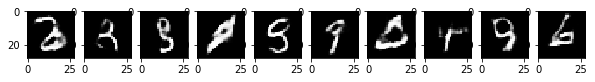

Epochs 5/10: Generator Loss: 0.218. Discriminator Loss: -0.232


Epochs 5/10: Generator Loss: 0.182. Discriminator Loss: -0.253


Epochs 5/10: Generator Loss: 0.241. Discriminator Loss: -0.263


Epochs 5/10: Generator Loss: 0.236. Discriminator Loss: -0.274


Epochs 5/10: Generator Loss: 0.064. Discriminator Loss: -0.176


Epochs 5/10: Generator Loss: -0.095. Discriminator Loss: -0.205


Epochs 5/10: Generator Loss: 0.083. Discriminator Loss: -0.231


Epochs 5/10: Generator Loss: 0.276. Discriminator Loss: -0.358


Epochs 5/10: Generator Loss: 0.325. Discriminator Loss: -0.253


Epochs 5/10: Generator Loss: 0.386. Discriminator Loss: -0.322


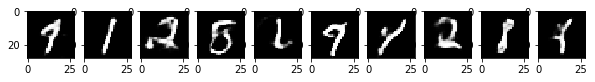

Epochs 5/10: Generator Loss: 0.235. Discriminator Loss: -0.217


Epochs 5/10: Generator Loss: 0.239. Discriminator Loss: -0.237


Epochs 5/10: Generator Loss: -0.29. Discriminator Loss: -0.29


Epochs 5/10: Generator Loss: -0.057. Discriminator Loss: -0.246


Epochs 5/10: Generator Loss: -0.501. Discriminator Loss: -0.271


Epochs 5/10: Generator Loss: -0.504. Discriminator Loss: -0.191


Epochs 5/10: Generator Loss: -0.479. Discriminator Loss: -0.206


Epochs 5/10: Generator Loss: -0.304. Discriminator Loss: -0.232


Epochs 5/10: Generator Loss: -0.356. Discriminator Loss: -0.178


Epochs 5/10: Generator Loss: -0.186. Discriminator Loss: -0.177


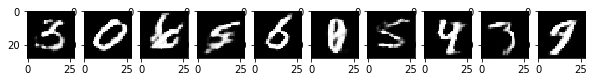

Epochs 5/10: Generator Loss: -0.125. Discriminator Loss: -0.213


Epochs 5/10: Generator Loss: -0.066. Discriminator Loss: -0.217


Epochs 5/10: Generator Loss: 0.143. Discriminator Loss: -0.196


Epochs 5/10: Generator Loss: -0.019. Discriminator Loss: -0.276


Epochs 5/10: Generator Loss: -0.168. Discriminator Loss: -0.243


Epochs 5/10: Generator Loss: -0.18. Discriminator Loss: -0.152


Epochs 5/10: Generator Loss: 0.115. Discriminator Loss: -0.214


Epochs 5/10: Generator Loss: -0.371. Discriminator Loss: -0.294


Epochs 5/10: Generator Loss: -0.085. Discriminator Loss: -0.224


Epochs 5/10: Generator Loss: -0.237. Discriminator Loss: -0.27


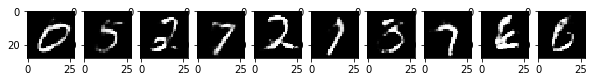

Epochs 5/10: Generator Loss: 0.249. Discriminator Loss: -0.286


Epochs 5/10: Generator Loss: -0.11. Discriminator Loss: -0.222


Epochs 5/10: Generator Loss: 0.027. Discriminator Loss: -0.225


Epochs 5/10: Generator Loss: 0.194. Discriminator Loss: -0.211


Epochs 6/10: Generator Loss: 0.213. Discriminator Loss: -0.081


Epochs 6/10: Generator Loss: -0.212. Discriminator Loss: -0.224


Epochs 6/10: Generator Loss: -0.229. Discriminator Loss: -0.173


Epochs 6/10: Generator Loss: -0.012. Discriminator Loss: -0.191


Epochs 6/10: Generator Loss: -0.2. Discriminator Loss: -0.25


Epochs 6/10: Generator Loss: 0.125. Discriminator Loss: -0.257


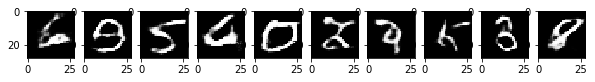

Epochs 6/10: Generator Loss: -0.039. Discriminator Loss: -0.3


Epochs 6/10: Generator Loss: 0.324. Discriminator Loss: -0.278


Epochs 6/10: Generator Loss: 0.278. Discriminator Loss: -0.275


Epochs 6/10: Generator Loss: 0.221. Discriminator Loss: -0.21


Epochs 6/10: Generator Loss: 0.018. Discriminator Loss: -0.21


Epochs 6/10: Generator Loss: 0.1. Discriminator Loss: -0.155


Epochs 6/10: Generator Loss: 0.282. Discriminator Loss: -0.174


Epochs 6/10: Generator Loss: 0.502. Discriminator Loss: -0.19


Epochs 6/10: Generator Loss: 0.174. Discriminator Loss: -0.221


Epochs 6/10: Generator Loss: 0.502. Discriminator Loss: -0.286


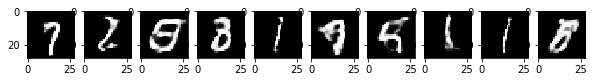

Epochs 6/10: Generator Loss: 0.359. Discriminator Loss: -0.161


Epochs 6/10: Generator Loss: 0.354. Discriminator Loss: -0.208


Epochs 6/10: Generator Loss: 0.04. Discriminator Loss: -0.202


Epochs 6/10: Generator Loss: -0.041. Discriminator Loss: -0.218


Epochs 6/10: Generator Loss: 0.308. Discriminator Loss: -0.165


Epochs 6/10: Generator Loss: 0.255. Discriminator Loss: -0.156


Epochs 6/10: Generator Loss: 0.211. Discriminator Loss: -0.22


Epochs 6/10: Generator Loss: 0.147. Discriminator Loss: -0.299


Epochs 6/10: Generator Loss: 0.322. Discriminator Loss: -0.244


Epochs 6/10: Generator Loss: 0.081. Discriminator Loss: -0.205


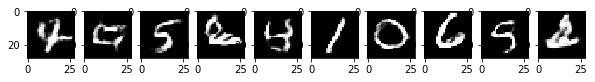

Epochs 6/10: Generator Loss: 0.005. Discriminator Loss: -0.19


Epochs 6/10: Generator Loss: 0.081. Discriminator Loss: -0.219


Epochs 6/10: Generator Loss: -0.081. Discriminator Loss: -0.207


Epochs 6/10: Generator Loss: 0.116. Discriminator Loss: -0.261


Epochs 6/10: Generator Loss: -0.006. Discriminator Loss: -0.205


Epochs 6/10: Generator Loss: 0.16. Discriminator Loss: -0.19


Epochs 6/10: Generator Loss: -0.011. Discriminator Loss: -0.181


Epochs 6/10: Generator Loss: 0.51. Discriminator Loss: -0.24


Epochs 6/10: Generator Loss: -0.241. Discriminator Loss: -0.189


Epochs 6/10: Generator Loss: -0.044. Discriminator Loss: -0.223


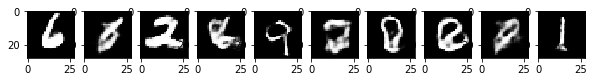

Epochs 6/10: Generator Loss: -0.419. Discriminator Loss: -0.246


Epochs 6/10: Generator Loss: -0.374. Discriminator Loss: -0.255


Epochs 6/10: Generator Loss: -0.206. Discriminator Loss: -0.27


Epochs 6/10: Generator Loss: -0.098. Discriminator Loss: -0.183


Epochs 6/10: Generator Loss: -0.038. Discriminator Loss: -0.236


Epochs 6/10: Generator Loss: -0.122. Discriminator Loss: -0.236


Epochs 6/10: Generator Loss: -0.026. Discriminator Loss: -0.238


Epochs 6/10: Generator Loss: 0.252. Discriminator Loss: -0.29


Epochs 6/10: Generator Loss: 0.227. Discriminator Loss: -0.276


Epochs 6/10: Generator Loss: 0.398. Discriminator Loss: -0.222


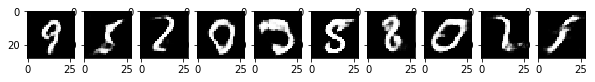

Epochs 6/10: Generator Loss: 0.096. Discriminator Loss: -0.187


Epochs 6/10: Generator Loss: 0.388. Discriminator Loss: -0.179


Epochs 6/10: Generator Loss: 0.381. Discriminator Loss: -0.203


Epochs 6/10: Generator Loss: -0.054. Discriminator Loss: -0.208


Epochs 6/10: Generator Loss: 0.431. Discriminator Loss: -0.244


Epochs 6/10: Generator Loss: 0.037. Discriminator Loss: -0.221


Epochs 6/10: Generator Loss: 0.2. Discriminator Loss: -0.192


Epochs 6/10: Generator Loss: -0.007. Discriminator Loss: -0.199


Epochs 6/10: Generator Loss: 0.293. Discriminator Loss: -0.247


Epochs 6/10: Generator Loss: 0.102. Discriminator Loss: -0.185


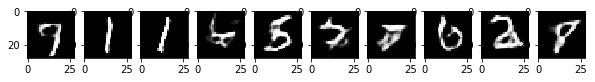

Epochs 6/10: Generator Loss: 0.542. Discriminator Loss: -0.207


Epochs 6/10: Generator Loss: 0.294. Discriminator Loss: -0.254


Epochs 6/10: Generator Loss: 0.43. Discriminator Loss: -0.207


Epochs 6/10: Generator Loss: 0.247. Discriminator Loss: -0.197


Epochs 6/10: Generator Loss: -0.016. Discriminator Loss: -0.219


Epochs 6/10: Generator Loss: 0.214. Discriminator Loss: -0.158


Epochs 6/10: Generator Loss: 0.009. Discriminator Loss: -0.188


Epochs 6/10: Generator Loss: -0.066. Discriminator Loss: -0.251


Epochs 6/10: Generator Loss: 0.216. Discriminator Loss: -0.243


Epochs 6/10: Generator Loss: -0.081. Discriminator Loss: -0.228


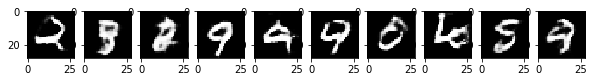

Epochs 6/10: Generator Loss: 0.453. Discriminator Loss: -0.123


Epochs 6/10: Generator Loss: 0.161. Discriminator Loss: -0.182


Epochs 6/10: Generator Loss: 0.349. Discriminator Loss: -0.243


Epochs 6/10: Generator Loss: -0.006. Discriminator Loss: -0.231


Epochs 6/10: Generator Loss: 0.549. Discriminator Loss: -0.257


Epochs 6/10: Generator Loss: 0.085. Discriminator Loss: -0.327


Epochs 6/10: Generator Loss: 0.431. Discriminator Loss: -0.241


Epochs 6/10: Generator Loss: 0.352. Discriminator Loss: -0.221


Epochs 6/10: Generator Loss: 0.249. Discriminator Loss: -0.282


Epochs 6/10: Generator Loss: 0.277. Discriminator Loss: -0.236


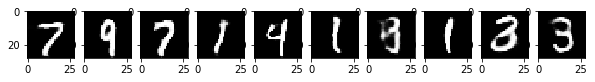

Epochs 6/10: Generator Loss: -0.011. Discriminator Loss: -0.24


Epochs 6/10: Generator Loss: 0.075. Discriminator Loss: -0.242


Epochs 6/10: Generator Loss: -0.145. Discriminator Loss: -0.255


Epochs 6/10: Generator Loss: -0.065. Discriminator Loss: -0.22


Epochs 6/10: Generator Loss: 0.165. Discriminator Loss: -0.255


Epochs 6/10: Generator Loss: 0.06. Discriminator Loss: -0.22


Epochs 6/10: Generator Loss: -0.026. Discriminator Loss: -0.209


Epochs 6/10: Generator Loss: -0.072. Discriminator Loss: -0.265


Epochs 6/10: Generator Loss: -0.005. Discriminator Loss: -0.217


Epochs 6/10: Generator Loss: -0.043. Discriminator Loss: -0.22


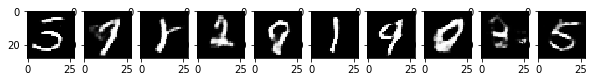

Epochs 6/10: Generator Loss: -0.113. Discriminator Loss: -0.216


Epochs 6/10: Generator Loss: 0.078. Discriminator Loss: -0.249


Epochs 6/10: Generator Loss: 0.073. Discriminator Loss: -0.259


Epochs 6/10: Generator Loss: 0.048. Discriminator Loss: -0.164


Epochs 6/10: Generator Loss: 0.268. Discriminator Loss: -0.25


Epochs 6/10: Generator Loss: -0.011. Discriminator Loss: -0.226


Epochs 6/10: Generator Loss: -0.036. Discriminator Loss: -0.208


Epochs 6/10: Generator Loss: -0.007. Discriminator Loss: -0.228


Epochs 6/10: Generator Loss: -0.131. Discriminator Loss: -0.238


Epochs 6/10: Generator Loss: -0.142. Discriminator Loss: -0.289


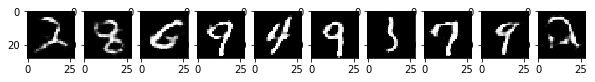

Epochs 6/10: Generator Loss: 0.05. Discriminator Loss: -0.312


Epochs 6/10: Generator Loss: 0.159. Discriminator Loss: -0.206


Epochs 6/10: Generator Loss: 0.224. Discriminator Loss: -0.206


Epochs 6/10: Generator Loss: -0.203. Discriminator Loss: -0.26


Epochs 6/10: Generator Loss: -0.4. Discriminator Loss: -0.274


Epochs 6/10: Generator Loss: -0.48. Discriminator Loss: -0.202


Epochs 6/10: Generator Loss: -0.256. Discriminator Loss: -0.196


Epochs 6/10: Generator Loss: -0.251. Discriminator Loss: -0.253


Epochs 6/10: Generator Loss: -0.442. Discriminator Loss: -0.246


Epochs 6/10: Generator Loss: -0.109. Discriminator Loss: -0.163


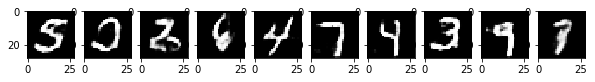

Epochs 6/10: Generator Loss: 0.151. Discriminator Loss: -0.263


Epochs 6/10: Generator Loss: 0.215. Discriminator Loss: -0.297


Epochs 6/10: Generator Loss: 0.276. Discriminator Loss: -0.247


Epochs 6/10: Generator Loss: 0.263. Discriminator Loss: -0.244


Epochs 6/10: Generator Loss: 0.481. Discriminator Loss: -0.272


Epochs 6/10: Generator Loss: 0.566. Discriminator Loss: -0.281


Epochs 6/10: Generator Loss: 0.137. Discriminator Loss: -0.259


Epochs 6/10: Generator Loss: 0.551. Discriminator Loss: -0.211


Epochs 6/10: Generator Loss: 0.257. Discriminator Loss: -0.191


Epochs 6/10: Generator Loss: -0.044. Discriminator Loss: -0.192


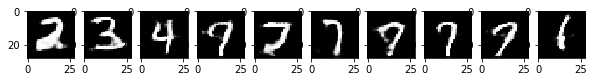

Epochs 6/10: Generator Loss: -0.059. Discriminator Loss: -0.268


Epochs 6/10: Generator Loss: 0.046. Discriminator Loss: -0.244


Epochs 6/10: Generator Loss: 0.164. Discriminator Loss: -0.255


Epochs 6/10: Generator Loss: 0.032. Discriminator Loss: -0.179


Epochs 6/10: Generator Loss: 0.173. Discriminator Loss: -0.305


Epochs 6/10: Generator Loss: -0.062. Discriminator Loss: -0.251


Epochs 6/10: Generator Loss: 0.183. Discriminator Loss: -0.216


Epochs 6/10: Generator Loss: 0.184. Discriminator Loss: -0.215


Epochs 6/10: Generator Loss: -0.124. Discriminator Loss: -0.257


Epochs 6/10: Generator Loss: 0.266. Discriminator Loss: -0.287


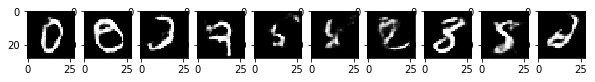

Epochs 6/10: Generator Loss: 0.208. Discriminator Loss: -0.28


Epochs 6/10: Generator Loss: 0.33. Discriminator Loss: -0.25


Epochs 6/10: Generator Loss: 0.224. Discriminator Loss: -0.27


Epochs 6/10: Generator Loss: 0.661. Discriminator Loss: -0.216


Epochs 6/10: Generator Loss: 0.663. Discriminator Loss: -0.217


Epochs 6/10: Generator Loss: 0.349. Discriminator Loss: -0.163


Epochs 6/10: Generator Loss: 0.512. Discriminator Loss: -0.156


Epochs 6/10: Generator Loss: 0.181. Discriminator Loss: -0.24


Epochs 6/10: Generator Loss: 0.076. Discriminator Loss: -0.259


Epochs 6/10: Generator Loss: -0.145. Discriminator Loss: -0.353


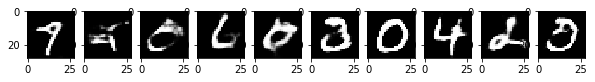

Epochs 6/10: Generator Loss: -0.36. Discriminator Loss: -0.251


Epochs 6/10: Generator Loss: -0.118. Discriminator Loss: -0.267


Epochs 6/10: Generator Loss: -0.284. Discriminator Loss: -0.241


Epochs 6/10: Generator Loss: 0.002. Discriminator Loss: -0.078


Epochs 6/10: Generator Loss: -0.079. Discriminator Loss: -0.252


Epochs 6/10: Generator Loss: 0.303. Discriminator Loss: -0.226


Epochs 6/10: Generator Loss: 0.126. Discriminator Loss: -0.212


Epochs 6/10: Generator Loss: 0.201. Discriminator Loss: -0.222


Epochs 6/10: Generator Loss: -0.21. Discriminator Loss: -0.227


Epochs 6/10: Generator Loss: -0.029. Discriminator Loss: -0.273


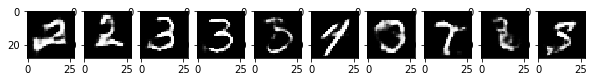

Epochs 6/10: Generator Loss: 0.155. Discriminator Loss: -0.32


Epochs 6/10: Generator Loss: 0.268. Discriminator Loss: -0.293


Epochs 6/10: Generator Loss: 0.407. Discriminator Loss: -0.265


Epochs 6/10: Generator Loss: 0.554. Discriminator Loss: -0.218


Epochs 6/10: Generator Loss: 0.594. Discriminator Loss: -0.265


Epochs 6/10: Generator Loss: 0.214. Discriminator Loss: -0.237


Epochs 6/10: Generator Loss: 0.075. Discriminator Loss: -0.173


Epochs 6/10: Generator Loss: 0.226. Discriminator Loss: -0.182


Epochs 6/10: Generator Loss: 0.15. Discriminator Loss: -0.25


Epochs 6/10: Generator Loss: 0.854. Discriminator Loss: -0.253


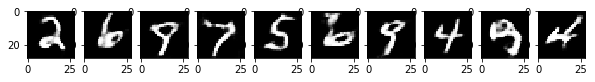

Epochs 6/10: Generator Loss: 0.721. Discriminator Loss: -0.194


Epochs 6/10: Generator Loss: 0.578. Discriminator Loss: -0.248


Epochs 6/10: Generator Loss: 0.177. Discriminator Loss: -0.222


Epochs 6/10: Generator Loss: 0.15. Discriminator Loss: -0.19


Epochs 6/10: Generator Loss: 0.454. Discriminator Loss: -0.365


Epochs 6/10: Generator Loss: 0.8. Discriminator Loss: -0.334


Epochs 6/10: Generator Loss: 0.881. Discriminator Loss: -0.38


Epochs 6/10: Generator Loss: 0.965. Discriminator Loss: -0.254


Epochs 6/10: Generator Loss: 0.696. Discriminator Loss: -0.239


Epochs 6/10: Generator Loss: 0.606. Discriminator Loss: -0.241


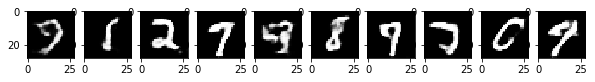

Epochs 6/10: Generator Loss: 0.346. Discriminator Loss: -0.338


Epochs 6/10: Generator Loss: 0.096. Discriminator Loss: -0.305


Epochs 6/10: Generator Loss: 0.11. Discriminator Loss: -0.271


Epochs 6/10: Generator Loss: -0.181. Discriminator Loss: -0.181


Epochs 6/10: Generator Loss: -0.218. Discriminator Loss: -0.194


Epochs 6/10: Generator Loss: 0.004. Discriminator Loss: -0.196


Epochs 6/10: Generator Loss: 0.396. Discriminator Loss: -0.31


Epochs 6/10: Generator Loss: 0.301. Discriminator Loss: -0.233


Epochs 6/10: Generator Loss: 0.343. Discriminator Loss: -0.195


Epochs 6/10: Generator Loss: 0.395. Discriminator Loss: -0.177


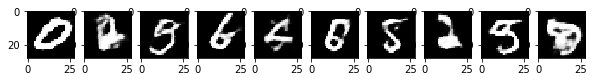

Epochs 6/10: Generator Loss: -0.125. Discriminator Loss: -0.175


Epochs 6/10: Generator Loss: 0.597. Discriminator Loss: -0.257


Epochs 6/10: Generator Loss: 0.435. Discriminator Loss: -0.23


Epochs 6/10: Generator Loss: -0.017. Discriminator Loss: -0.162


Epochs 6/10: Generator Loss: 0.074. Discriminator Loss: -0.228


Epochs 6/10: Generator Loss: 0.152. Discriminator Loss: -0.2


Epochs 6/10: Generator Loss: -0.002. Discriminator Loss: -0.243


Epochs 6/10: Generator Loss: -0.123. Discriminator Loss: -0.242


Epochs 6/10: Generator Loss: 0.087. Discriminator Loss: -0.236


Epochs 6/10: Generator Loss: 0.325. Discriminator Loss: -0.199


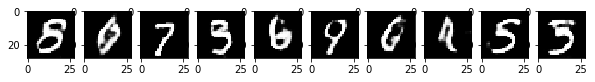

Epochs 6/10: Generator Loss: 0.201. Discriminator Loss: -0.268


Epochs 6/10: Generator Loss: 0.4. Discriminator Loss: -0.242


Epochs 7/10: Generator Loss: 0.749. Discriminator Loss: -0.093


Epochs 7/10: Generator Loss: -0.128. Discriminator Loss: -0.221


Epochs 7/10: Generator Loss: 0.406. Discriminator Loss: -0.207


Epochs 7/10: Generator Loss: 0.295. Discriminator Loss: -0.212


Epochs 7/10: Generator Loss: 0.649. Discriminator Loss: -0.255


Epochs 7/10: Generator Loss: 0.502. Discriminator Loss: -0.24


Epochs 7/10: Generator Loss: 0.719. Discriminator Loss: -0.296


Epochs 7/10: Generator Loss: 0.712. Discriminator Loss: -0.19


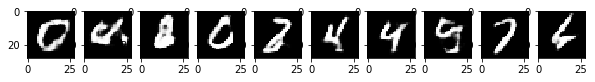

Epochs 7/10: Generator Loss: 0.671. Discriminator Loss: -0.265


Epochs 7/10: Generator Loss: 0.511. Discriminator Loss: -0.209


Epochs 7/10: Generator Loss: 0.604. Discriminator Loss: -0.24


Epochs 7/10: Generator Loss: 0.394. Discriminator Loss: -0.181


Epochs 7/10: Generator Loss: 0.83. Discriminator Loss: -0.221


Epochs 7/10: Generator Loss: 0.681. Discriminator Loss: -0.202


Epochs 7/10: Generator Loss: 0.771. Discriminator Loss: -0.282


Epochs 7/10: Generator Loss: 0.701. Discriminator Loss: -0.274


Epochs 7/10: Generator Loss: 0.605. Discriminator Loss: -0.172


Epochs 7/10: Generator Loss: 0.565. Discriminator Loss: -0.255


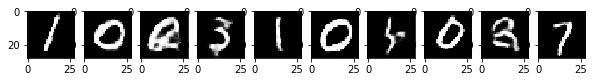

Epochs 7/10: Generator Loss: 0.759. Discriminator Loss: -0.244


Epochs 7/10: Generator Loss: 0.389. Discriminator Loss: -0.261


Epochs 7/10: Generator Loss: 0.525. Discriminator Loss: -0.251


Epochs 7/10: Generator Loss: 0.606. Discriminator Loss: -0.276


Epochs 7/10: Generator Loss: 0.635. Discriminator Loss: -0.211


Epochs 7/10: Generator Loss: 0.451. Discriminator Loss: -0.202


Epochs 7/10: Generator Loss: 0.634. Discriminator Loss: -0.208


Epochs 7/10: Generator Loss: 0.209. Discriminator Loss: -0.274


Epochs 7/10: Generator Loss: 0.44. Discriminator Loss: -0.208


Epochs 7/10: Generator Loss: 0.185. Discriminator Loss: -0.275


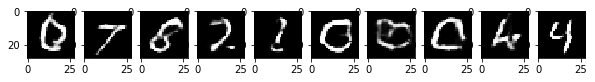

Epochs 7/10: Generator Loss: 0.253. Discriminator Loss: -0.188


Epochs 7/10: Generator Loss: 0.351. Discriminator Loss: -0.237


Epochs 7/10: Generator Loss: 0.234. Discriminator Loss: -0.194


Epochs 7/10: Generator Loss: 0.609. Discriminator Loss: -0.157


Epochs 7/10: Generator Loss: 0.459. Discriminator Loss: -0.187


Epochs 7/10: Generator Loss: 0.57. Discriminator Loss: -0.18


Epochs 7/10: Generator Loss: 0.098. Discriminator Loss: -0.236


Epochs 7/10: Generator Loss: 0.327. Discriminator Loss: -0.197


Epochs 7/10: Generator Loss: 0.015. Discriminator Loss: -0.201


Epochs 7/10: Generator Loss: 0.206. Discriminator Loss: -0.28


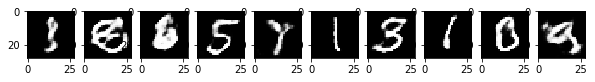

Epochs 7/10: Generator Loss: 0.232. Discriminator Loss: -0.232


Epochs 7/10: Generator Loss: 0.406. Discriminator Loss: -0.204


Epochs 7/10: Generator Loss: 0.361. Discriminator Loss: -0.225


Epochs 7/10: Generator Loss: 0.501. Discriminator Loss: -0.209


Epochs 7/10: Generator Loss: 0.598. Discriminator Loss: -0.218


Epochs 7/10: Generator Loss: 0.605. Discriminator Loss: -0.236


Epochs 7/10: Generator Loss: 0.724. Discriminator Loss: -0.217


Epochs 7/10: Generator Loss: 0.528. Discriminator Loss: -0.171


Epochs 7/10: Generator Loss: 0.306. Discriminator Loss: -0.187


Epochs 7/10: Generator Loss: 0.499. Discriminator Loss: -0.207


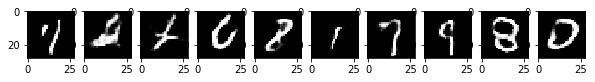

Epochs 7/10: Generator Loss: 0.464. Discriminator Loss: -0.219


Epochs 7/10: Generator Loss: 0.512. Discriminator Loss: -0.235


Epochs 7/10: Generator Loss: 0.302. Discriminator Loss: -0.24


Epochs 7/10: Generator Loss: 0.483. Discriminator Loss: -0.184


Epochs 7/10: Generator Loss: 0.387. Discriminator Loss: -0.204


Epochs 7/10: Generator Loss: 0.755. Discriminator Loss: -0.219


Epochs 7/10: Generator Loss: 0.572. Discriminator Loss: -0.261


Epochs 7/10: Generator Loss: 0.88. Discriminator Loss: -0.236


Epochs 7/10: Generator Loss: 0.947. Discriminator Loss: -0.246


Epochs 7/10: Generator Loss: 0.659. Discriminator Loss: -0.246


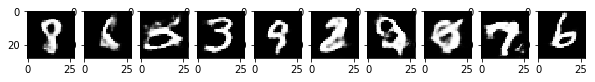

Epochs 7/10: Generator Loss: 0.716. Discriminator Loss: -0.16


Epochs 7/10: Generator Loss: 0.524. Discriminator Loss: -0.21


Epochs 7/10: Generator Loss: 0.362. Discriminator Loss: -0.239


Epochs 7/10: Generator Loss: 0.265. Discriminator Loss: -0.211


Epochs 7/10: Generator Loss: 0.291. Discriminator Loss: -0.213


Epochs 7/10: Generator Loss: 0.199. Discriminator Loss: -0.275


Epochs 7/10: Generator Loss: 0.357. Discriminator Loss: -0.237


Epochs 7/10: Generator Loss: 0.442. Discriminator Loss: -0.202


Epochs 7/10: Generator Loss: 0.436. Discriminator Loss: -0.248


Epochs 7/10: Generator Loss: 0.436. Discriminator Loss: -0.237


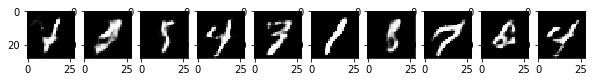

Epochs 7/10: Generator Loss: 0.58. Discriminator Loss: -0.261


Epochs 7/10: Generator Loss: 0.521. Discriminator Loss: -0.331


Epochs 7/10: Generator Loss: 0.933. Discriminator Loss: -0.361


Epochs 7/10: Generator Loss: 0.767. Discriminator Loss: -0.258


Epochs 7/10: Generator Loss: 0.757. Discriminator Loss: -0.231


Epochs 7/10: Generator Loss: 0.682. Discriminator Loss: -0.239


Epochs 7/10: Generator Loss: 0.59. Discriminator Loss: -0.26


Epochs 7/10: Generator Loss: 0.604. Discriminator Loss: -0.13


Epochs 7/10: Generator Loss: 0.392. Discriminator Loss: -0.156


Epochs 7/10: Generator Loss: 0.344. Discriminator Loss: -0.205


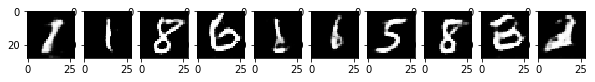

Epochs 7/10: Generator Loss: 0.329. Discriminator Loss: -0.209


Epochs 7/10: Generator Loss: 0.546. Discriminator Loss: -0.238


Epochs 7/10: Generator Loss: 0.439. Discriminator Loss: -0.22


Epochs 7/10: Generator Loss: 0.266. Discriminator Loss: -0.258


Epochs 7/10: Generator Loss: 0.368. Discriminator Loss: -0.303


Epochs 7/10: Generator Loss: 0.232. Discriminator Loss: -0.237


Epochs 7/10: Generator Loss: 0.224. Discriminator Loss: -0.227


Epochs 7/10: Generator Loss: 0.154. Discriminator Loss: -0.221


Epochs 7/10: Generator Loss: 0.37. Discriminator Loss: -0.301


Epochs 7/10: Generator Loss: 0.491. Discriminator Loss: -0.278


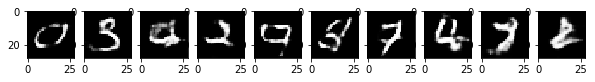

Epochs 7/10: Generator Loss: 0.354. Discriminator Loss: -0.174


Epochs 7/10: Generator Loss: 0.744. Discriminator Loss: -0.223


Epochs 7/10: Generator Loss: 0.767. Discriminator Loss: -0.291


Epochs 7/10: Generator Loss: 0.373. Discriminator Loss: -0.234


Epochs 7/10: Generator Loss: 0.406. Discriminator Loss: -0.279


Epochs 7/10: Generator Loss: 0.365. Discriminator Loss: -0.241


Epochs 7/10: Generator Loss: 0.347. Discriminator Loss: -0.281


Epochs 7/10: Generator Loss: 0.374. Discriminator Loss: -0.309


Epochs 7/10: Generator Loss: 0.517. Discriminator Loss: -0.279


Epochs 7/10: Generator Loss: 0.404. Discriminator Loss: -0.228


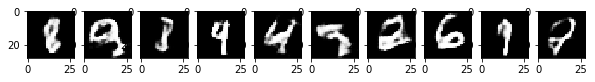

Epochs 7/10: Generator Loss: -0.06. Discriminator Loss: -0.221


Epochs 7/10: Generator Loss: 0.081. Discriminator Loss: -0.229


Epochs 7/10: Generator Loss: 0.016. Discriminator Loss: -0.212


Epochs 7/10: Generator Loss: 0.022. Discriminator Loss: -0.19


Epochs 7/10: Generator Loss: 0.014. Discriminator Loss: -0.247


Epochs 7/10: Generator Loss: -0.006. Discriminator Loss: -0.222


Epochs 7/10: Generator Loss: 0.128. Discriminator Loss: -0.188


Epochs 7/10: Generator Loss: 0.507. Discriminator Loss: -0.175


Epochs 7/10: Generator Loss: 0.42. Discriminator Loss: -0.24


Epochs 7/10: Generator Loss: 0.559. Discriminator Loss: -0.258


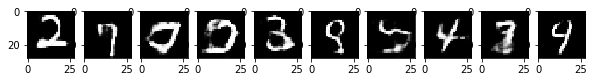

Epochs 7/10: Generator Loss: 0.449. Discriminator Loss: -0.259


Epochs 7/10: Generator Loss: 0.286. Discriminator Loss: -0.283


Epochs 7/10: Generator Loss: 0.25. Discriminator Loss: -0.248


Epochs 7/10: Generator Loss: 0.477. Discriminator Loss: -0.213


Epochs 7/10: Generator Loss: 0.563. Discriminator Loss: -0.24


Epochs 7/10: Generator Loss: 0.674. Discriminator Loss: -0.242


Epochs 7/10: Generator Loss: 0.393. Discriminator Loss: -0.218


Epochs 7/10: Generator Loss: 0.421. Discriminator Loss: -0.216


Epochs 7/10: Generator Loss: 0.309. Discriminator Loss: -0.247


Epochs 7/10: Generator Loss: 0.206. Discriminator Loss: -0.236


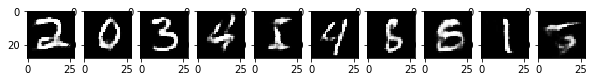

Epochs 7/10: Generator Loss: 0.53. Discriminator Loss: -0.264


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: -0.225


Epochs 7/10: Generator Loss: 0.557. Discriminator Loss: -0.246


Epochs 7/10: Generator Loss: 0.28. Discriminator Loss: -0.252


Epochs 7/10: Generator Loss: 0.105. Discriminator Loss: -0.246


Epochs 7/10: Generator Loss: 0.194. Discriminator Loss: -0.281


Epochs 7/10: Generator Loss: 0.566. Discriminator Loss: -0.297


Epochs 7/10: Generator Loss: 0.453. Discriminator Loss: -0.319


Epochs 7/10: Generator Loss: 0.493. Discriminator Loss: -0.282


Epochs 7/10: Generator Loss: 0.502. Discriminator Loss: -0.258


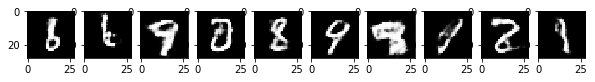

Epochs 7/10: Generator Loss: 0.398. Discriminator Loss: -0.243


Epochs 7/10: Generator Loss: 0.772. Discriminator Loss: -0.266


Epochs 7/10: Generator Loss: 0.892. Discriminator Loss: -0.26


Epochs 7/10: Generator Loss: 0.735. Discriminator Loss: -0.215


Epochs 7/10: Generator Loss: 0.483. Discriminator Loss: -0.165


Epochs 7/10: Generator Loss: 0.463. Discriminator Loss: -0.249


Epochs 7/10: Generator Loss: 0.33. Discriminator Loss: -0.301


Epochs 7/10: Generator Loss: -0.128. Discriminator Loss: -0.313


Epochs 7/10: Generator Loss: 0.173. Discriminator Loss: -0.27


Epochs 7/10: Generator Loss: 0.092. Discriminator Loss: -0.216


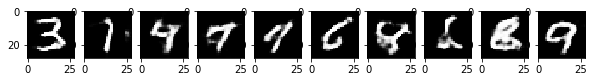

Epochs 7/10: Generator Loss: 0.088. Discriminator Loss: -0.255


Epochs 7/10: Generator Loss: 0.178. Discriminator Loss: -0.226


Epochs 7/10: Generator Loss: 0.393. Discriminator Loss: -0.194


Epochs 7/10: Generator Loss: 0.416. Discriminator Loss: -0.183


Epochs 7/10: Generator Loss: 0.209. Discriminator Loss: -0.213


Epochs 7/10: Generator Loss: 0.312. Discriminator Loss: -0.212


Epochs 7/10: Generator Loss: 0.297. Discriminator Loss: -0.279


Epochs 7/10: Generator Loss: 0.382. Discriminator Loss: -0.28


Epochs 7/10: Generator Loss: 0.432. Discriminator Loss: -0.318


Epochs 7/10: Generator Loss: 0.874. Discriminator Loss: -0.279


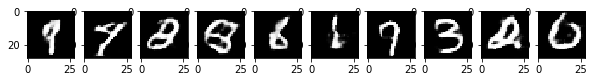

Epochs 7/10: Generator Loss: 0.834. Discriminator Loss: -0.223


Epochs 7/10: Generator Loss: 0.845. Discriminator Loss: -0.191


Epochs 7/10: Generator Loss: 0.753. Discriminator Loss: -0.226


Epochs 7/10: Generator Loss: 0.762. Discriminator Loss: -0.199


Epochs 7/10: Generator Loss: 0.757. Discriminator Loss: -0.217


Epochs 7/10: Generator Loss: 0.794. Discriminator Loss: -0.222


Epochs 7/10: Generator Loss: 0.893. Discriminator Loss: -0.294


Epochs 7/10: Generator Loss: 0.925. Discriminator Loss: -0.273


Epochs 7/10: Generator Loss: 1.159. Discriminator Loss: -0.274


Epochs 7/10: Generator Loss: 0.749. Discriminator Loss: -0.243


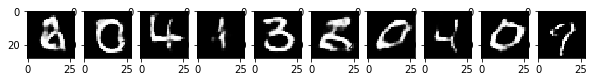

Epochs 7/10: Generator Loss: 0.663. Discriminator Loss: -0.237


Epochs 7/10: Generator Loss: 0.83. Discriminator Loss: -0.281


Epochs 7/10: Generator Loss: 1.002. Discriminator Loss: -0.363


Epochs 7/10: Generator Loss: 1.107. Discriminator Loss: -0.279


Epochs 7/10: Generator Loss: 1.19. Discriminator Loss: -0.358


Epochs 7/10: Generator Loss: 1.166. Discriminator Loss: -0.179


Epochs 7/10: Generator Loss: 0.916. Discriminator Loss: -0.215


Epochs 7/10: Generator Loss: 0.656. Discriminator Loss: -0.338


Epochs 7/10: Generator Loss: 1.054. Discriminator Loss: -0.346


Epochs 7/10: Generator Loss: 0.651. Discriminator Loss: -0.274


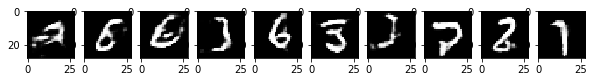

Epochs 7/10: Generator Loss: 0.411. Discriminator Loss: -0.206


Epochs 7/10: Generator Loss: 0.174. Discriminator Loss: -0.249


Epochs 7/10: Generator Loss: 0.247. Discriminator Loss: -0.147


Epochs 7/10: Generator Loss: 0.382. Discriminator Loss: -0.206


Epochs 7/10: Generator Loss: 0.606. Discriminator Loss: -0.204


Epochs 7/10: Generator Loss: 0.903. Discriminator Loss: -0.239


Epochs 7/10: Generator Loss: 0.803. Discriminator Loss: -0.215


Epochs 7/10: Generator Loss: 1.032. Discriminator Loss: -0.188


Epochs 7/10: Generator Loss: 0.9. Discriminator Loss: -0.274


Epochs 7/10: Generator Loss: 0.55. Discriminator Loss: -0.209


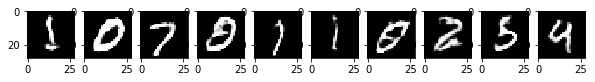

Epochs 7/10: Generator Loss: 0.635. Discriminator Loss: -0.172


Epochs 7/10: Generator Loss: 0.722. Discriminator Loss: -0.204


Epochs 7/10: Generator Loss: 0.676. Discriminator Loss: -0.278


Epochs 7/10: Generator Loss: 0.627. Discriminator Loss: -0.224


Epochs 7/10: Generator Loss: 0.518. Discriminator Loss: -0.215


Epochs 7/10: Generator Loss: 0.605. Discriminator Loss: -0.252


Epochs 7/10: Generator Loss: 0.47. Discriminator Loss: -0.265


Epochs 7/10: Generator Loss: 0.592. Discriminator Loss: -0.221


Epochs 7/10: Generator Loss: 0.788. Discriminator Loss: -0.241


Epochs 8/10: Generator Loss: 0.651. Discriminator Loss: -0.056


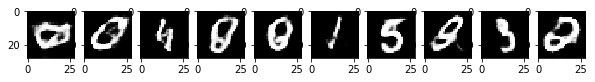

Epochs 8/10: Generator Loss: 0.495. Discriminator Loss: -0.205


Epochs 8/10: Generator Loss: 0.513. Discriminator Loss: -0.23


Epochs 8/10: Generator Loss: 0.966. Discriminator Loss: -0.205


Epochs 8/10: Generator Loss: 0.714. Discriminator Loss: -0.254


Epochs 8/10: Generator Loss: 1.13. Discriminator Loss: -0.326


Epochs 8/10: Generator Loss: 0.864. Discriminator Loss: -0.313


Epochs 8/10: Generator Loss: 1.029. Discriminator Loss: -0.322


Epochs 8/10: Generator Loss: 1.014. Discriminator Loss: -0.246


Epochs 8/10: Generator Loss: 1.03. Discriminator Loss: -0.232


Epochs 8/10: Generator Loss: 0.657. Discriminator Loss: -0.235


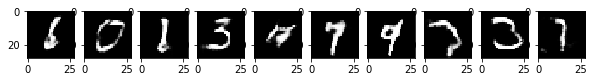

Epochs 8/10: Generator Loss: 0.743. Discriminator Loss: -0.157


Epochs 8/10: Generator Loss: 1.241. Discriminator Loss: -0.218


Epochs 8/10: Generator Loss: 1.277. Discriminator Loss: -0.232


Epochs 8/10: Generator Loss: 0.708. Discriminator Loss: -0.208


Epochs 8/10: Generator Loss: 1.206. Discriminator Loss: -0.268


Epochs 8/10: Generator Loss: 1.113. Discriminator Loss: -0.236


Epochs 8/10: Generator Loss: 0.941. Discriminator Loss: -0.219


Epochs 8/10: Generator Loss: 0.896. Discriminator Loss: -0.195


Epochs 8/10: Generator Loss: 0.947. Discriminator Loss: -0.244


Epochs 8/10: Generator Loss: 0.887. Discriminator Loss: -0.203


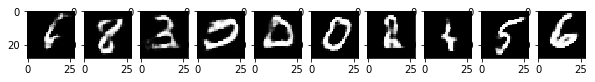

Epochs 8/10: Generator Loss: 0.973. Discriminator Loss: -0.243


Epochs 8/10: Generator Loss: 1.201. Discriminator Loss: -0.193


Epochs 8/10: Generator Loss: 1.147. Discriminator Loss: -0.275


Epochs 8/10: Generator Loss: 1.173. Discriminator Loss: -0.233


Epochs 8/10: Generator Loss: 0.976. Discriminator Loss: -0.227


Epochs 8/10: Generator Loss: 0.775. Discriminator Loss: -0.198


Epochs 8/10: Generator Loss: 1.104. Discriminator Loss: -0.186


Epochs 8/10: Generator Loss: 0.642. Discriminator Loss: -0.207


Epochs 8/10: Generator Loss: 0.908. Discriminator Loss: -0.259


Epochs 8/10: Generator Loss: 0.896. Discriminator Loss: -0.242


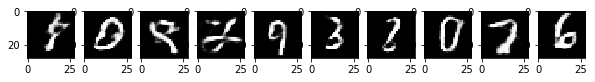

Epochs 8/10: Generator Loss: 1.063. Discriminator Loss: -0.193


Epochs 8/10: Generator Loss: 0.911. Discriminator Loss: -0.216


Epochs 8/10: Generator Loss: 1.128. Discriminator Loss: -0.242


Epochs 8/10: Generator Loss: 0.655. Discriminator Loss: -0.175


Epochs 8/10: Generator Loss: 0.533. Discriminator Loss: -0.233


Epochs 8/10: Generator Loss: 0.445. Discriminator Loss: -0.283


Epochs 8/10: Generator Loss: 0.282. Discriminator Loss: -0.159


Epochs 8/10: Generator Loss: 0.59. Discriminator Loss: -0.244


Epochs 8/10: Generator Loss: 0.823. Discriminator Loss: -0.264


Epochs 8/10: Generator Loss: 0.693. Discriminator Loss: -0.246


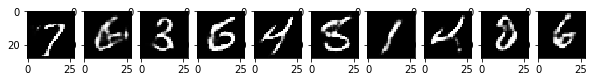

Epochs 8/10: Generator Loss: 0.799. Discriminator Loss: -0.231


Epochs 8/10: Generator Loss: 0.686. Discriminator Loss: -0.208


Epochs 8/10: Generator Loss: 1.192. Discriminator Loss: -0.244


Epochs 8/10: Generator Loss: 1.01. Discriminator Loss: -0.253


Epochs 8/10: Generator Loss: 1.007. Discriminator Loss: -0.139


Epochs 8/10: Generator Loss: 0.589. Discriminator Loss: -0.187


Epochs 8/10: Generator Loss: 0.691. Discriminator Loss: -0.244


Epochs 8/10: Generator Loss: 0.801. Discriminator Loss: -0.221


Epochs 8/10: Generator Loss: 0.636. Discriminator Loss: -0.209


Epochs 8/10: Generator Loss: 0.793. Discriminator Loss: -0.285


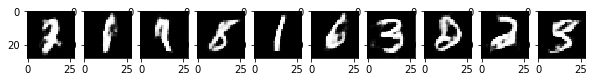

Epochs 8/10: Generator Loss: 0.783. Discriminator Loss: -0.269


Epochs 8/10: Generator Loss: 0.806. Discriminator Loss: -0.231


Epochs 8/10: Generator Loss: 0.675. Discriminator Loss: -0.212


Epochs 8/10: Generator Loss: 0.832. Discriminator Loss: -0.195


Epochs 8/10: Generator Loss: 0.803. Discriminator Loss: -0.255


Epochs 8/10: Generator Loss: 1.09. Discriminator Loss: -0.232


Epochs 8/10: Generator Loss: 0.868. Discriminator Loss: -0.254


Epochs 8/10: Generator Loss: 0.832. Discriminator Loss: -0.157


Epochs 8/10: Generator Loss: 0.687. Discriminator Loss: -0.214


Epochs 8/10: Generator Loss: 0.677. Discriminator Loss: -0.274


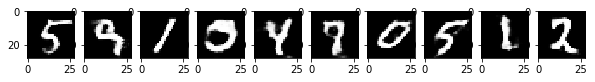

Epochs 8/10: Generator Loss: 0.594. Discriminator Loss: -0.194


Epochs 8/10: Generator Loss: 0.264. Discriminator Loss: -0.212


Epochs 8/10: Generator Loss: 0.458. Discriminator Loss: -0.255


Epochs 8/10: Generator Loss: 0.598. Discriminator Loss: -0.255


Epochs 8/10: Generator Loss: 0.687. Discriminator Loss: -0.212


Epochs 8/10: Generator Loss: 0.957. Discriminator Loss: -0.152


Epochs 8/10: Generator Loss: 0.776. Discriminator Loss: -0.234


Epochs 8/10: Generator Loss: 0.845. Discriminator Loss: -0.195


Epochs 8/10: Generator Loss: 0.683. Discriminator Loss: -0.224


Epochs 8/10: Generator Loss: 1.279. Discriminator Loss: -0.322


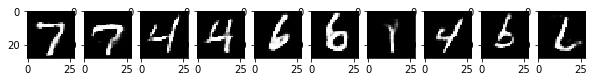

Epochs 8/10: Generator Loss: 0.946. Discriminator Loss: -0.305


Epochs 8/10: Generator Loss: 0.923. Discriminator Loss: -0.193


Epochs 8/10: Generator Loss: 0.886. Discriminator Loss: -0.216


Epochs 8/10: Generator Loss: 0.944. Discriminator Loss: -0.26


Epochs 8/10: Generator Loss: 1.024. Discriminator Loss: -0.232


Epochs 8/10: Generator Loss: 0.562. Discriminator Loss: -0.267


Epochs 8/10: Generator Loss: 0.653. Discriminator Loss: -0.249


Epochs 8/10: Generator Loss: 0.536. Discriminator Loss: -0.164


Epochs 8/10: Generator Loss: 0.661. Discriminator Loss: -0.226


Epochs 8/10: Generator Loss: 0.91. Discriminator Loss: -0.195


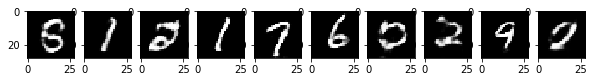

Epochs 8/10: Generator Loss: 0.633. Discriminator Loss: -0.243


Epochs 8/10: Generator Loss: 0.781. Discriminator Loss: -0.265


Epochs 8/10: Generator Loss: 0.701. Discriminator Loss: -0.324


Epochs 8/10: Generator Loss: 0.588. Discriminator Loss: -0.238


Epochs 8/10: Generator Loss: 0.496. Discriminator Loss: -0.245


Epochs 8/10: Generator Loss: 0.426. Discriminator Loss: -0.205


Epochs 8/10: Generator Loss: 0.792. Discriminator Loss: -0.284


Epochs 8/10: Generator Loss: 0.975. Discriminator Loss: -0.228


Epochs 8/10: Generator Loss: 0.955. Discriminator Loss: -0.187


Epochs 8/10: Generator Loss: 1.011. Discriminator Loss: -0.248


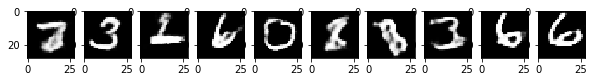

Epochs 8/10: Generator Loss: 0.759. Discriminator Loss: -0.262


Epochs 8/10: Generator Loss: 0.633. Discriminator Loss: -0.226


Epochs 8/10: Generator Loss: 0.714. Discriminator Loss: -0.24


Epochs 8/10: Generator Loss: 0.675. Discriminator Loss: -0.251


Epochs 8/10: Generator Loss: 0.794. Discriminator Loss: -0.302


Epochs 8/10: Generator Loss: 0.621. Discriminator Loss: -0.274


Epochs 8/10: Generator Loss: 0.833. Discriminator Loss: -0.262


Epochs 8/10: Generator Loss: 0.893. Discriminator Loss: -0.225


Epochs 8/10: Generator Loss: 0.401. Discriminator Loss: -0.244


Epochs 8/10: Generator Loss: 0.218. Discriminator Loss: -0.235


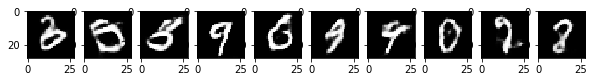

Epochs 8/10: Generator Loss: 0.195. Discriminator Loss: -0.184


Epochs 8/10: Generator Loss: 0.374. Discriminator Loss: -0.2


Epochs 8/10: Generator Loss: 0.388. Discriminator Loss: -0.212


Epochs 8/10: Generator Loss: 0.409. Discriminator Loss: -0.213


Epochs 8/10: Generator Loss: 0.522. Discriminator Loss: -0.168


Epochs 8/10: Generator Loss: 0.845. Discriminator Loss: -0.233


Epochs 8/10: Generator Loss: 0.902. Discriminator Loss: -0.297


Epochs 8/10: Generator Loss: 0.757. Discriminator Loss: -0.262


Epochs 8/10: Generator Loss: 0.775. Discriminator Loss: -0.256


Epochs 8/10: Generator Loss: 0.83. Discriminator Loss: -0.246


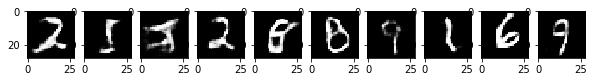

Epochs 8/10: Generator Loss: 0.735. Discriminator Loss: -0.288


Epochs 8/10: Generator Loss: 0.758. Discriminator Loss: -0.279


Epochs 8/10: Generator Loss: 0.962. Discriminator Loss: -0.252


Epochs 8/10: Generator Loss: 0.864. Discriminator Loss: -0.212


Epochs 8/10: Generator Loss: 0.516. Discriminator Loss: -0.165


Epochs 8/10: Generator Loss: 0.459. Discriminator Loss: -0.224


Epochs 8/10: Generator Loss: 0.716. Discriminator Loss: -0.246


Epochs 8/10: Generator Loss: 0.855. Discriminator Loss: -0.286


Epochs 8/10: Generator Loss: 0.628. Discriminator Loss: -0.275


Epochs 8/10: Generator Loss: 0.667. Discriminator Loss: -0.245


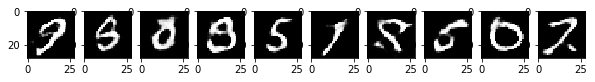

Epochs 8/10: Generator Loss: 0.594. Discriminator Loss: -0.205


Epochs 8/10: Generator Loss: 0.502. Discriminator Loss: -0.253


Epochs 8/10: Generator Loss: 0.504. Discriminator Loss: -0.228


Epochs 8/10: Generator Loss: 0.457. Discriminator Loss: -0.291


Epochs 8/10: Generator Loss: 0.674. Discriminator Loss: -0.319


Epochs 8/10: Generator Loss: 0.745. Discriminator Loss: -0.324


Epochs 8/10: Generator Loss: 0.629. Discriminator Loss: -0.303


Epochs 8/10: Generator Loss: 0.692. Discriminator Loss: -0.242


Epochs 8/10: Generator Loss: 0.956. Discriminator Loss: -0.242


Epochs 8/10: Generator Loss: 1.119. Discriminator Loss: -0.2


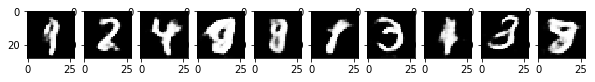

Epochs 8/10: Generator Loss: 1.092. Discriminator Loss: -0.178


Epochs 8/10: Generator Loss: 1.096. Discriminator Loss: -0.114


Epochs 8/10: Generator Loss: 0.561. Discriminator Loss: -0.191


Epochs 8/10: Generator Loss: 0.641. Discriminator Loss: -0.296


Epochs 8/10: Generator Loss: 0.349. Discriminator Loss: -0.4


Epochs 8/10: Generator Loss: 0.221. Discriminator Loss: -0.257


Epochs 8/10: Generator Loss: 0.316. Discriminator Loss: -0.255


Epochs 8/10: Generator Loss: 0.356. Discriminator Loss: -0.235


Epochs 8/10: Generator Loss: 0.744. Discriminator Loss: -0.258


Epochs 8/10: Generator Loss: 0.806. Discriminator Loss: -0.277


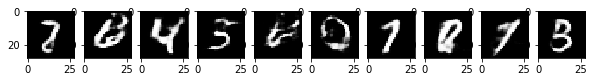

Epochs 8/10: Generator Loss: 0.718. Discriminator Loss: -0.255


Epochs 8/10: Generator Loss: 0.726. Discriminator Loss: -0.218


Epochs 8/10: Generator Loss: 0.799. Discriminator Loss: -0.222


Epochs 8/10: Generator Loss: 0.569. Discriminator Loss: -0.275


Epochs 8/10: Generator Loss: 0.609. Discriminator Loss: -0.312


Epochs 8/10: Generator Loss: 0.806. Discriminator Loss: -0.261


Epochs 8/10: Generator Loss: 0.776. Discriminator Loss: -0.246


Epochs 8/10: Generator Loss: 0.977. Discriminator Loss: -0.256


Epochs 8/10: Generator Loss: 1.224. Discriminator Loss: -0.255


Epochs 8/10: Generator Loss: 1.325. Discriminator Loss: -0.23


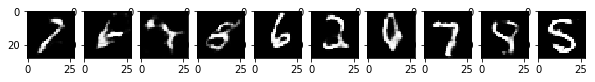

Epochs 8/10: Generator Loss: 1.171. Discriminator Loss: -0.277


Epochs 8/10: Generator Loss: 1.046. Discriminator Loss: -0.203


Epochs 8/10: Generator Loss: 1.114. Discriminator Loss: -0.224


Epochs 8/10: Generator Loss: 1.167. Discriminator Loss: -0.269


Epochs 8/10: Generator Loss: 1.426. Discriminator Loss: -0.291


Epochs 8/10: Generator Loss: 1.411. Discriminator Loss: -0.306


Epochs 8/10: Generator Loss: 1.317. Discriminator Loss: -0.137


Epochs 8/10: Generator Loss: 1.08. Discriminator Loss: -0.169


Epochs 8/10: Generator Loss: 0.941. Discriminator Loss: -0.228


Epochs 8/10: Generator Loss: 1.355. Discriminator Loss: -0.308


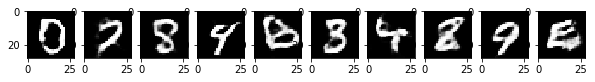

Epochs 8/10: Generator Loss: 1.697. Discriminator Loss: -0.296


Epochs 8/10: Generator Loss: 1.802. Discriminator Loss: -0.301


Epochs 8/10: Generator Loss: 1.671. Discriminator Loss: -0.275


Epochs 8/10: Generator Loss: 1.583. Discriminator Loss: -0.233


Epochs 8/10: Generator Loss: 1.29. Discriminator Loss: -0.243


Epochs 8/10: Generator Loss: 1.059. Discriminator Loss: -0.302


Epochs 8/10: Generator Loss: 0.838. Discriminator Loss: -0.312


Epochs 8/10: Generator Loss: 0.988. Discriminator Loss: -0.273


Epochs 8/10: Generator Loss: 0.704. Discriminator Loss: -0.195


Epochs 8/10: Generator Loss: 0.321. Discriminator Loss: -0.158


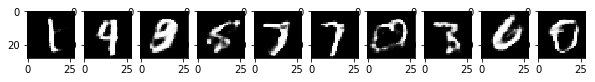

Epochs 8/10: Generator Loss: 0.539. Discriminator Loss: -0.233


Epochs 8/10: Generator Loss: 0.922. Discriminator Loss: -0.253


Epochs 8/10: Generator Loss: 1.036. Discriminator Loss: -0.213


Epochs 8/10: Generator Loss: 1.282. Discriminator Loss: -0.204


Epochs 8/10: Generator Loss: 1.243. Discriminator Loss: -0.187


Epochs 8/10: Generator Loss: 0.977. Discriminator Loss: -0.208


Epochs 8/10: Generator Loss: 1.303. Discriminator Loss: -0.297


Epochs 8/10: Generator Loss: 1.297. Discriminator Loss: -0.211


Epochs 8/10: Generator Loss: 0.798. Discriminator Loss: -0.221


Epochs 8/10: Generator Loss: 0.99. Discriminator Loss: -0.256


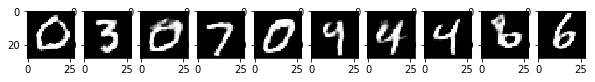

Epochs 8/10: Generator Loss: 0.961. Discriminator Loss: -0.271


Epochs 8/10: Generator Loss: 0.771. Discriminator Loss: -0.199


Epochs 8/10: Generator Loss: 0.662. Discriminator Loss: -0.264


Epochs 8/10: Generator Loss: 0.884. Discriminator Loss: -0.185


Epochs 8/10: Generator Loss: 0.816. Discriminator Loss: -0.199


Epochs 8/10: Generator Loss: 0.934. Discriminator Loss: -0.224


Epochs 8/10: Generator Loss: 1.117. Discriminator Loss: -0.292


Epochs 9/10: Generator Loss: 1.18. Discriminator Loss: -0.148


Epochs 9/10: Generator Loss: 0.622. Discriminator Loss: -0.171


Epochs 9/10: Generator Loss: 1.036. Discriminator Loss: -0.172


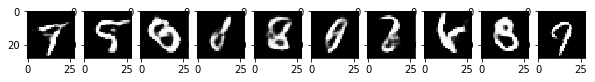

Epochs 9/10: Generator Loss: 0.797. Discriminator Loss: -0.135


Epochs 9/10: Generator Loss: 1.259. Discriminator Loss: -0.218


Epochs 9/10: Generator Loss: 1.073. Discriminator Loss: -0.273


Epochs 9/10: Generator Loss: 1.233. Discriminator Loss: -0.241


Epochs 9/10: Generator Loss: 1.341. Discriminator Loss: -0.309


Epochs 9/10: Generator Loss: 1.169. Discriminator Loss: -0.249


Epochs 9/10: Generator Loss: 0.917. Discriminator Loss: -0.229


Epochs 9/10: Generator Loss: 1.003. Discriminator Loss: -0.227


Epochs 9/10: Generator Loss: 1.25. Discriminator Loss: -0.225


Epochs 9/10: Generator Loss: 1.456. Discriminator Loss: -0.242


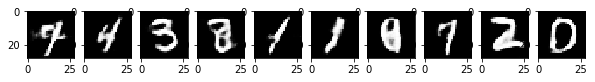

Epochs 9/10: Generator Loss: 1.485. Discriminator Loss: -0.166


Epochs 9/10: Generator Loss: 1.284. Discriminator Loss: -0.237


Epochs 9/10: Generator Loss: 1.221. Discriminator Loss: -0.199


Epochs 9/10: Generator Loss: 1.217. Discriminator Loss: -0.216


Epochs 9/10: Generator Loss: 1.183. Discriminator Loss: -0.274


Epochs 9/10: Generator Loss: 1.29. Discriminator Loss: -0.193


Epochs 9/10: Generator Loss: 0.906. Discriminator Loss: -0.243


Epochs 9/10: Generator Loss: 1.066. Discriminator Loss: -0.245


Epochs 9/10: Generator Loss: 1.145. Discriminator Loss: -0.295


Epochs 9/10: Generator Loss: 1.424. Discriminator Loss: -0.282


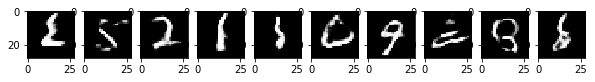

Epochs 9/10: Generator Loss: 1.166. Discriminator Loss: -0.311


Epochs 9/10: Generator Loss: 1.378. Discriminator Loss: -0.235


Epochs 9/10: Generator Loss: 0.992. Discriminator Loss: -0.218


Epochs 9/10: Generator Loss: 1.093. Discriminator Loss: -0.233


Epochs 9/10: Generator Loss: 1.006. Discriminator Loss: -0.282


Epochs 9/10: Generator Loss: 0.794. Discriminator Loss: -0.258


Epochs 9/10: Generator Loss: 0.837. Discriminator Loss: -0.221


Epochs 9/10: Generator Loss: 0.876. Discriminator Loss: -0.184


Epochs 9/10: Generator Loss: 1.15. Discriminator Loss: -0.241


Epochs 9/10: Generator Loss: 1.041. Discriminator Loss: -0.198


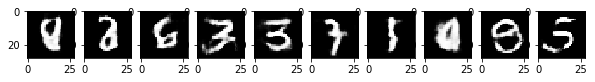

Epochs 9/10: Generator Loss: 1.062. Discriminator Loss: -0.225


Epochs 9/10: Generator Loss: 0.71. Discriminator Loss: -0.227


Epochs 9/10: Generator Loss: 0.683. Discriminator Loss: -0.225


Epochs 9/10: Generator Loss: 0.895. Discriminator Loss: -0.203


Epochs 9/10: Generator Loss: 0.716. Discriminator Loss: -0.275


Epochs 9/10: Generator Loss: 0.717. Discriminator Loss: -0.248


Epochs 9/10: Generator Loss: 0.686. Discriminator Loss: -0.159


Epochs 9/10: Generator Loss: 0.801. Discriminator Loss: -0.227


Epochs 9/10: Generator Loss: 1.07. Discriminator Loss: -0.2


Epochs 9/10: Generator Loss: 0.989. Discriminator Loss: -0.155


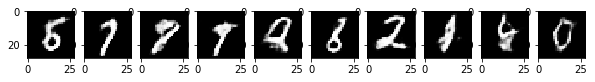

Epochs 9/10: Generator Loss: 1.353. Discriminator Loss: -0.281


Epochs 9/10: Generator Loss: 1.457. Discriminator Loss: -0.269


Epochs 9/10: Generator Loss: 1.18. Discriminator Loss: -0.165


Epochs 9/10: Generator Loss: 0.903. Discriminator Loss: -0.25


Epochs 9/10: Generator Loss: 0.995. Discriminator Loss: -0.197


Epochs 9/10: Generator Loss: 1.169. Discriminator Loss: -0.233


Epochs 9/10: Generator Loss: 1.204. Discriminator Loss: -0.255


Epochs 9/10: Generator Loss: 1.171. Discriminator Loss: -0.281


Epochs 9/10: Generator Loss: 1.316. Discriminator Loss: -0.241


Epochs 9/10: Generator Loss: 1.239. Discriminator Loss: -0.221


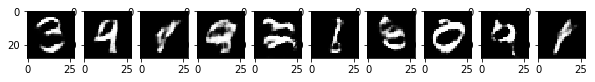

Epochs 9/10: Generator Loss: 1.444. Discriminator Loss: -0.203


Epochs 9/10: Generator Loss: 1.217. Discriminator Loss: -0.238


Epochs 9/10: Generator Loss: 1.64. Discriminator Loss: -0.255


Epochs 9/10: Generator Loss: 1.529. Discriminator Loss: -0.179


Epochs 9/10: Generator Loss: 1.392. Discriminator Loss: -0.28


Epochs 9/10: Generator Loss: 1.559. Discriminator Loss: -0.214


Epochs 9/10: Generator Loss: 0.908. Discriminator Loss: -0.211


Epochs 9/10: Generator Loss: 1.159. Discriminator Loss: -0.261


Epochs 9/10: Generator Loss: 0.771. Discriminator Loss: -0.152


Epochs 9/10: Generator Loss: 1.024. Discriminator Loss: -0.213


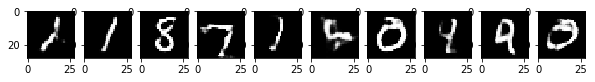

Epochs 9/10: Generator Loss: 0.907. Discriminator Loss: -0.276


Epochs 9/10: Generator Loss: 1.211. Discriminator Loss: -0.216


Epochs 9/10: Generator Loss: 1.046. Discriminator Loss: -0.228


Epochs 9/10: Generator Loss: 1.165. Discriminator Loss: -0.228


Epochs 9/10: Generator Loss: 1.095. Discriminator Loss: -0.217


Epochs 9/10: Generator Loss: 1.058. Discriminator Loss: -0.23


Epochs 9/10: Generator Loss: 1.208. Discriminator Loss: -0.355


Epochs 9/10: Generator Loss: 1.196. Discriminator Loss: -0.404


Epochs 9/10: Generator Loss: 1.21. Discriminator Loss: -0.31


Epochs 9/10: Generator Loss: 1.048. Discriminator Loss: -0.266


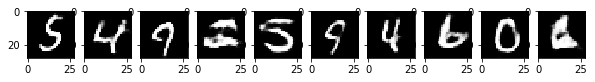

Epochs 9/10: Generator Loss: 0.904. Discriminator Loss: -0.22


Epochs 9/10: Generator Loss: 0.971. Discriminator Loss: -0.255


Epochs 9/10: Generator Loss: 1.14. Discriminator Loss: -0.205


Epochs 9/10: Generator Loss: 0.631. Discriminator Loss: -0.239


Epochs 9/10: Generator Loss: 0.682. Discriminator Loss: -0.193


Epochs 9/10: Generator Loss: 0.677. Discriminator Loss: -0.183


Epochs 9/10: Generator Loss: 1.017. Discriminator Loss: -0.287


Epochs 9/10: Generator Loss: 0.814. Discriminator Loss: -0.263


Epochs 9/10: Generator Loss: 0.948. Discriminator Loss: -0.205


Epochs 9/10: Generator Loss: 0.82. Discriminator Loss: -0.354


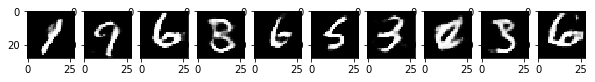

Epochs 9/10: Generator Loss: 0.776. Discriminator Loss: -0.327


Epochs 9/10: Generator Loss: 0.603. Discriminator Loss: -0.259


Epochs 9/10: Generator Loss: 0.723. Discriminator Loss: -0.244


Epochs 9/10: Generator Loss: 0.785. Discriminator Loss: -0.281


Epochs 9/10: Generator Loss: 0.949. Discriminator Loss: -0.26


Epochs 9/10: Generator Loss: 1.012. Discriminator Loss: -0.248


Epochs 9/10: Generator Loss: 1.276. Discriminator Loss: -0.2


Epochs 9/10: Generator Loss: 1.052. Discriminator Loss: -0.221


Epochs 9/10: Generator Loss: 0.901. Discriminator Loss: -0.238


Epochs 9/10: Generator Loss: 0.699. Discriminator Loss: -0.255


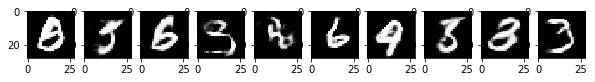

Epochs 9/10: Generator Loss: 0.91. Discriminator Loss: -0.293


Epochs 9/10: Generator Loss: 1.019. Discriminator Loss: -0.283


Epochs 9/10: Generator Loss: 0.942. Discriminator Loss: -0.299


Epochs 9/10: Generator Loss: 1.047. Discriminator Loss: -0.279


Epochs 9/10: Generator Loss: 1.082. Discriminator Loss: -0.244


Epochs 9/10: Generator Loss: 0.704. Discriminator Loss: -0.222


Epochs 9/10: Generator Loss: 0.646. Discriminator Loss: -0.284


Epochs 9/10: Generator Loss: 0.61. Discriminator Loss: -0.197


Epochs 9/10: Generator Loss: 0.408. Discriminator Loss: -0.155


Epochs 9/10: Generator Loss: 0.383. Discriminator Loss: -0.252


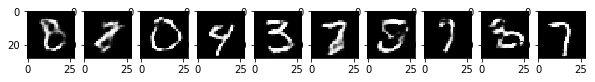

Epochs 9/10: Generator Loss: 0.412. Discriminator Loss: -0.224


Epochs 9/10: Generator Loss: 0.699. Discriminator Loss: -0.2


Epochs 9/10: Generator Loss: 1.162. Discriminator Loss: -0.16


Epochs 9/10: Generator Loss: 1.1. Discriminator Loss: -0.274


Epochs 9/10: Generator Loss: 1.352. Discriminator Loss: -0.261


Epochs 9/10: Generator Loss: 1.05. Discriminator Loss: -0.275


Epochs 9/10: Generator Loss: 0.887. Discriminator Loss: -0.285


Epochs 9/10: Generator Loss: 0.843. Discriminator Loss: -0.271


Epochs 9/10: Generator Loss: 1.069. Discriminator Loss: -0.266


Epochs 9/10: Generator Loss: 1.14. Discriminator Loss: -0.212


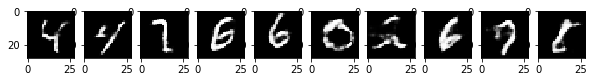

Epochs 9/10: Generator Loss: 1.106. Discriminator Loss: -0.244


Epochs 9/10: Generator Loss: 1.057. Discriminator Loss: -0.225


Epochs 9/10: Generator Loss: 1.049. Discriminator Loss: -0.248


Epochs 9/10: Generator Loss: 0.991. Discriminator Loss: -0.231


Epochs 9/10: Generator Loss: 1.068. Discriminator Loss: -0.257


Epochs 9/10: Generator Loss: 1.117. Discriminator Loss: -0.257


Epochs 9/10: Generator Loss: 1.3. Discriminator Loss: -0.253


Epochs 9/10: Generator Loss: 1.161. Discriminator Loss: -0.237


Epochs 9/10: Generator Loss: 0.76. Discriminator Loss: -0.273


Epochs 9/10: Generator Loss: 0.732. Discriminator Loss: -0.244


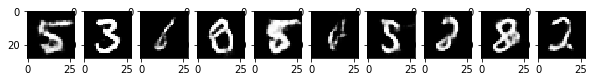

Epochs 9/10: Generator Loss: 0.77. Discriminator Loss: -0.177


Epochs 9/10: Generator Loss: 1.073. Discriminator Loss: -0.304


Epochs 9/10: Generator Loss: 0.964. Discriminator Loss: -0.312


Epochs 9/10: Generator Loss: 1.102. Discriminator Loss: -0.314


Epochs 9/10: Generator Loss: 1.123. Discriminator Loss: -0.269


Epochs 9/10: Generator Loss: 1.058. Discriminator Loss: -0.245


Epochs 9/10: Generator Loss: 1.295. Discriminator Loss: -0.254


Epochs 9/10: Generator Loss: 1.407. Discriminator Loss: -0.205


Epochs 9/10: Generator Loss: 1.356. Discriminator Loss: -0.148


Epochs 9/10: Generator Loss: 0.905. Discriminator Loss: -0.157


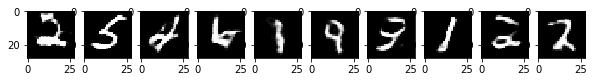

Epochs 9/10: Generator Loss: 1.131. Discriminator Loss: -0.28


Epochs 9/10: Generator Loss: 1.018. Discriminator Loss: -0.392


Epochs 9/10: Generator Loss: 0.49. Discriminator Loss: -0.352


Epochs 9/10: Generator Loss: 0.277. Discriminator Loss: -0.273


Epochs 9/10: Generator Loss: 0.585. Discriminator Loss: -0.222


Epochs 9/10: Generator Loss: 0.467. Discriminator Loss: -0.213


Epochs 9/10: Generator Loss: 0.606. Discriminator Loss: -0.242


Epochs 9/10: Generator Loss: 0.874. Discriminator Loss: -0.243


Epochs 9/10: Generator Loss: 1.032. Discriminator Loss: -0.281


Epochs 9/10: Generator Loss: 0.991. Discriminator Loss: -0.232


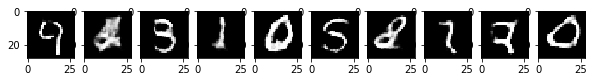

Epochs 9/10: Generator Loss: 0.862. Discriminator Loss: -0.181


Epochs 9/10: Generator Loss: 0.877. Discriminator Loss: -0.26


Epochs 9/10: Generator Loss: 1.148. Discriminator Loss: -0.345


Epochs 9/10: Generator Loss: 1.249. Discriminator Loss: -0.302


Epochs 9/10: Generator Loss: 1.494. Discriminator Loss: -0.238


Epochs 9/10: Generator Loss: 1.431. Discriminator Loss: -0.206


Epochs 9/10: Generator Loss: 1.292. Discriminator Loss: -0.203


Epochs 9/10: Generator Loss: 1.289. Discriminator Loss: -0.251


Epochs 9/10: Generator Loss: 1.299. Discriminator Loss: -0.254


Epochs 9/10: Generator Loss: 1.366. Discriminator Loss: -0.232


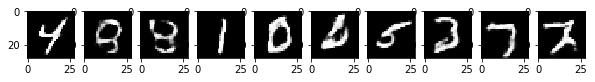

Epochs 9/10: Generator Loss: 1.448. Discriminator Loss: -0.238


Epochs 9/10: Generator Loss: 1.734. Discriminator Loss: -0.262


Epochs 9/10: Generator Loss: 1.614. Discriminator Loss: -0.304


Epochs 9/10: Generator Loss: 1.528. Discriminator Loss: -0.24


Epochs 9/10: Generator Loss: 1.238. Discriminator Loss: -0.249


Epochs 9/10: Generator Loss: 1.024. Discriminator Loss: -0.246


Epochs 9/10: Generator Loss: 1.185. Discriminator Loss: -0.224


Epochs 9/10: Generator Loss: 1.549. Discriminator Loss: -0.282


Epochs 9/10: Generator Loss: 1.811. Discriminator Loss: -0.327


Epochs 9/10: Generator Loss: 1.748. Discriminator Loss: -0.309


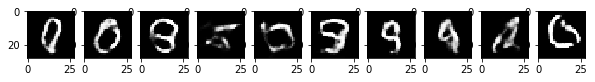

Epochs 9/10: Generator Loss: 1.824. Discriminator Loss: -0.206


Epochs 9/10: Generator Loss: 1.644. Discriminator Loss: -0.282


Epochs 9/10: Generator Loss: 1.391. Discriminator Loss: -0.305


Epochs 9/10: Generator Loss: 1.351. Discriminator Loss: -0.338


Epochs 9/10: Generator Loss: 1.17. Discriminator Loss: -0.212


Epochs 9/10: Generator Loss: 0.617. Discriminator Loss: -0.163


Epochs 9/10: Generator Loss: 0.882. Discriminator Loss: -0.214


Epochs 9/10: Generator Loss: 0.988. Discriminator Loss: -0.189


Epochs 9/10: Generator Loss: 0.932. Discriminator Loss: -0.206


Epochs 9/10: Generator Loss: 1.395. Discriminator Loss: -0.222


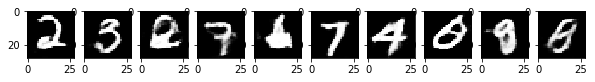

Epochs 9/10: Generator Loss: 1.41. Discriminator Loss: -0.272


Epochs 9/10: Generator Loss: 1.507. Discriminator Loss: -0.194


Epochs 9/10: Generator Loss: 1.571. Discriminator Loss: -0.191


Epochs 9/10: Generator Loss: 1.514. Discriminator Loss: -0.3


Epochs 9/10: Generator Loss: 1.058. Discriminator Loss: -0.161


Epochs 9/10: Generator Loss: 1.034. Discriminator Loss: -0.192


Epochs 9/10: Generator Loss: 1.405. Discriminator Loss: -0.217


Epochs 9/10: Generator Loss: 0.871. Discriminator Loss: -0.229


Epochs 9/10: Generator Loss: 1.098. Discriminator Loss: -0.228


Epochs 9/10: Generator Loss: 0.851. Discriminator Loss: -0.233


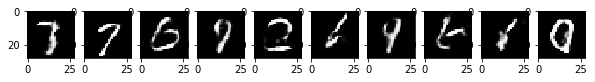

Epochs 9/10: Generator Loss: 1.014. Discriminator Loss: -0.227


Epochs 9/10: Generator Loss: 0.982. Discriminator Loss: -0.222


Epochs 9/10: Generator Loss: 1.177. Discriminator Loss: -0.214


Epochs 9/10: Generator Loss: 1.549. Discriminator Loss: -0.285


Epochs 10/10: Generator Loss: 1.395. Discriminator Loss: -0.045


Epochs 10/10: Generator Loss: 1.322. Discriminator Loss: -0.142


Epochs 10/10: Generator Loss: 1.194. Discriminator Loss: -0.176


Epochs 10/10: Generator Loss: 1.415. Discriminator Loss: -0.193


Epochs 10/10: Generator Loss: 1.1. Discriminator Loss: -0.278


Epochs 10/10: Generator Loss: 1.669. Discriminator Loss: -0.234


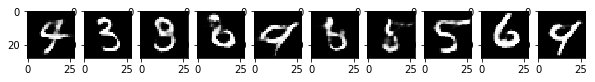

Epochs 10/10: Generator Loss: 1.404. Discriminator Loss: -0.291


Epochs 10/10: Generator Loss: 1.659. Discriminator Loss: -0.254


Epochs 10/10: Generator Loss: 1.786. Discriminator Loss: -0.228


Epochs 10/10: Generator Loss: 1.826. Discriminator Loss: -0.24


Epochs 10/10: Generator Loss: 1.154. Discriminator Loss: -0.185


Epochs 10/10: Generator Loss: 1.367. Discriminator Loss: -0.214


Epochs 10/10: Generator Loss: 1.811. Discriminator Loss: -0.236


Epochs 10/10: Generator Loss: 1.764. Discriminator Loss: -0.217


Epochs 10/10: Generator Loss: 1.582. Discriminator Loss: -0.209


Epochs 10/10: Generator Loss: 1.831. Discriminator Loss: -0.259


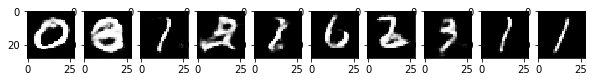

Epochs 10/10: Generator Loss: 1.45. Discriminator Loss: -0.158


Epochs 10/10: Generator Loss: 1.68. Discriminator Loss: -0.194


Epochs 10/10: Generator Loss: 1.824. Discriminator Loss: -0.196


Epochs 10/10: Generator Loss: 1.499. Discriminator Loss: -0.246


Epochs 10/10: Generator Loss: 1.609. Discriminator Loss: -0.138


Epochs 10/10: Generator Loss: 1.58. Discriminator Loss: -0.257


Epochs 10/10: Generator Loss: 1.72. Discriminator Loss: -0.199


Epochs 10/10: Generator Loss: 1.568. Discriminator Loss: -0.267


Epochs 10/10: Generator Loss: 1.861. Discriminator Loss: -0.214


Epochs 10/10: Generator Loss: 1.672. Discriminator Loss: -0.257


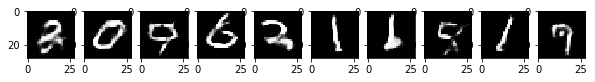

Epochs 10/10: Generator Loss: 1.347. Discriminator Loss: -0.245


Epochs 10/10: Generator Loss: 1.293. Discriminator Loss: -0.235


Epochs 10/10: Generator Loss: 1.221. Discriminator Loss: -0.237


Epochs 10/10: Generator Loss: 1.168. Discriminator Loss: -0.213


Epochs 10/10: Generator Loss: 1.054. Discriminator Loss: -0.206


Epochs 10/10: Generator Loss: 1.181. Discriminator Loss: -0.211


Epochs 10/10: Generator Loss: 1.225. Discriminator Loss: -0.196


Epochs 10/10: Generator Loss: 1.369. Discriminator Loss: -0.23


Epochs 10/10: Generator Loss: 1.023. Discriminator Loss: -0.196


Epochs 10/10: Generator Loss: 0.863. Discriminator Loss: -0.228


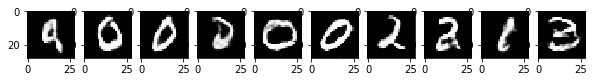

Epochs 10/10: Generator Loss: 0.893. Discriminator Loss: -0.263


Epochs 10/10: Generator Loss: 0.888. Discriminator Loss: -0.242


Epochs 10/10: Generator Loss: 1.126. Discriminator Loss: -0.229


Epochs 10/10: Generator Loss: 1.2. Discriminator Loss: -0.241


Epochs 10/10: Generator Loss: 1.208. Discriminator Loss: -0.259


Epochs 10/10: Generator Loss: 1.252. Discriminator Loss: -0.276


Epochs 10/10: Generator Loss: 1.12. Discriminator Loss: -0.172


Epochs 10/10: Generator Loss: 1.471. Discriminator Loss: -0.231


Epochs 10/10: Generator Loss: 1.499. Discriminator Loss: -0.251


Epochs 10/10: Generator Loss: 1.397. Discriminator Loss: -0.239


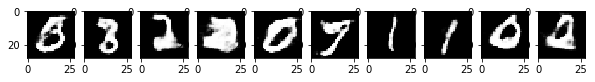

Epochs 10/10: Generator Loss: 1.212. Discriminator Loss: -0.18


Epochs 10/10: Generator Loss: 1.203. Discriminator Loss: -0.216


Epochs 10/10: Generator Loss: 1.235. Discriminator Loss: -0.239


Epochs 10/10: Generator Loss: 1.347. Discriminator Loss: -0.216


Epochs 10/10: Generator Loss: 1.652. Discriminator Loss: -0.294


Epochs 10/10: Generator Loss: 1.786. Discriminator Loss: -0.244


Epochs 10/10: Generator Loss: 1.711. Discriminator Loss: -0.221


Epochs 10/10: Generator Loss: 1.701. Discriminator Loss: -0.224


Epochs 10/10: Generator Loss: 1.642. Discriminator Loss: -0.182


Epochs 10/10: Generator Loss: 1.717. Discriminator Loss: -0.227


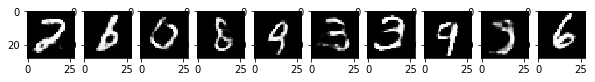

Epochs 10/10: Generator Loss: 1.993. Discriminator Loss: -0.246


Epochs 10/10: Generator Loss: 1.636. Discriminator Loss: -0.258


Epochs 10/10: Generator Loss: 1.771. Discriminator Loss: -0.231


Epochs 10/10: Generator Loss: 1.454. Discriminator Loss: -0.244


Epochs 10/10: Generator Loss: 1.367. Discriminator Loss: -0.242


Epochs 10/10: Generator Loss: 1.222. Discriminator Loss: -0.184


Epochs 10/10: Generator Loss: 1.027. Discriminator Loss: -0.235


Epochs 10/10: Generator Loss: 1.085. Discriminator Loss: -0.261


Epochs 10/10: Generator Loss: 1.155. Discriminator Loss: -0.293


Epochs 10/10: Generator Loss: 1.134. Discriminator Loss: -0.197


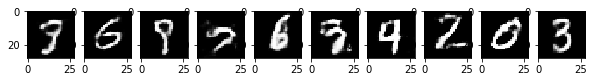

Epochs 10/10: Generator Loss: 1.333. Discriminator Loss: -0.198


Epochs 10/10: Generator Loss: 1.202. Discriminator Loss: -0.206


Epochs 10/10: Generator Loss: 1.065. Discriminator Loss: -0.197


Epochs 10/10: Generator Loss: 0.863. Discriminator Loss: -0.271


Epochs 10/10: Generator Loss: 1.17. Discriminator Loss: -0.277


Epochs 10/10: Generator Loss: 1.045. Discriminator Loss: -0.304


Epochs 10/10: Generator Loss: 1.213. Discriminator Loss: -0.265


Epochs 10/10: Generator Loss: 1.278. Discriminator Loss: -0.273


Epochs 10/10: Generator Loss: 1.009. Discriminator Loss: -0.251


Epochs 10/10: Generator Loss: 1.141. Discriminator Loss: -0.251


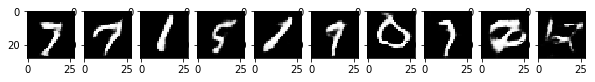

Epochs 10/10: Generator Loss: 0.91. Discriminator Loss: -0.152


Epochs 10/10: Generator Loss: 0.815. Discriminator Loss: -0.221


Epochs 10/10: Generator Loss: 0.855. Discriminator Loss: -0.223


Epochs 10/10: Generator Loss: 1.218. Discriminator Loss: -0.193


Epochs 10/10: Generator Loss: 1.349. Discriminator Loss: -0.265


Epochs 10/10: Generator Loss: 1.347. Discriminator Loss: -0.274


Epochs 10/10: Generator Loss: 1.24. Discriminator Loss: -0.264


Epochs 10/10: Generator Loss: 1.297. Discriminator Loss: -0.26


Epochs 10/10: Generator Loss: 1.275. Discriminator Loss: -0.232


Epochs 10/10: Generator Loss: 1.07. Discriminator Loss: -0.195


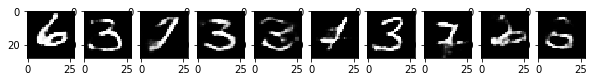

Epochs 10/10: Generator Loss: 0.933. Discriminator Loss: -0.21


Epochs 10/10: Generator Loss: 1.26. Discriminator Loss: -0.301


Epochs 10/10: Generator Loss: 1.391. Discriminator Loss: -0.312


Epochs 10/10: Generator Loss: 1.437. Discriminator Loss: -0.193


Epochs 10/10: Generator Loss: 1.403. Discriminator Loss: -0.251


Epochs 10/10: Generator Loss: 0.959. Discriminator Loss: -0.212


Epochs 10/10: Generator Loss: 1.238. Discriminator Loss: -0.234


Epochs 10/10: Generator Loss: 1.06. Discriminator Loss: -0.26


Epochs 10/10: Generator Loss: 1.259. Discriminator Loss: -0.303


Epochs 10/10: Generator Loss: 1.2. Discriminator Loss: -0.297


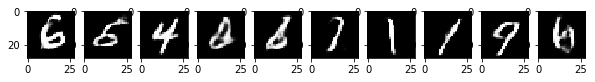

Epochs 10/10: Generator Loss: 1.25. Discriminator Loss: -0.367


Epochs 10/10: Generator Loss: 1.276. Discriminator Loss: -0.224


Epochs 10/10: Generator Loss: 1.084. Discriminator Loss: -0.225


Epochs 10/10: Generator Loss: 0.862. Discriminator Loss: -0.243


Epochs 10/10: Generator Loss: 0.709. Discriminator Loss: -0.256


Epochs 10/10: Generator Loss: 0.628. Discriminator Loss: -0.277


Epochs 10/10: Generator Loss: 0.925. Discriminator Loss: -0.257


Epochs 10/10: Generator Loss: 0.718. Discriminator Loss: -0.219


Epochs 10/10: Generator Loss: 1.024. Discriminator Loss: -0.23


Epochs 10/10: Generator Loss: 1.124. Discriminator Loss: -0.182


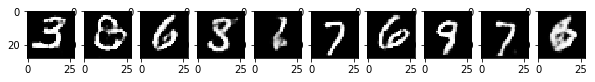

Epochs 10/10: Generator Loss: 1.427. Discriminator Loss: -0.144


Epochs 10/10: Generator Loss: 1.501. Discriminator Loss: -0.308


Epochs 10/10: Generator Loss: 1.57. Discriminator Loss: -0.307


Epochs 10/10: Generator Loss: 1.578. Discriminator Loss: -0.297


Epochs 10/10: Generator Loss: 1.493. Discriminator Loss: -0.261


Epochs 10/10: Generator Loss: 1.261. Discriminator Loss: -0.303


Epochs 10/10: Generator Loss: 1.423. Discriminator Loss: -0.241


Epochs 10/10: Generator Loss: 1.615. Discriminator Loss: -0.182


Epochs 10/10: Generator Loss: 1.621. Discriminator Loss: -0.195


Epochs 10/10: Generator Loss: 1.406. Discriminator Loss: -0.218


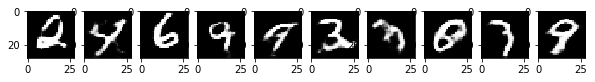

Epochs 10/10: Generator Loss: 1.387. Discriminator Loss: -0.241


Epochs 10/10: Generator Loss: 1.571. Discriminator Loss: -0.295


Epochs 10/10: Generator Loss: 1.609. Discriminator Loss: -0.259


Epochs 10/10: Generator Loss: 1.51. Discriminator Loss: -0.259


Epochs 10/10: Generator Loss: 1.445. Discriminator Loss: -0.236


Epochs 10/10: Generator Loss: 1.357. Discriminator Loss: -0.258


Epochs 10/10: Generator Loss: 1.183. Discriminator Loss: -0.238


Epochs 10/10: Generator Loss: 1.202. Discriminator Loss: -0.228


Epochs 10/10: Generator Loss: 1.281. Discriminator Loss: -0.322


Epochs 10/10: Generator Loss: 1.401. Discriminator Loss: -0.31


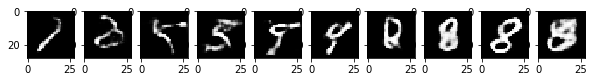

Epochs 10/10: Generator Loss: 1.639. Discriminator Loss: -0.313


Epochs 10/10: Generator Loss: 1.392. Discriminator Loss: -0.325


Epochs 10/10: Generator Loss: 1.257. Discriminator Loss: -0.265


Epochs 10/10: Generator Loss: 1.731. Discriminator Loss: -0.245


Epochs 10/10: Generator Loss: 1.406. Discriminator Loss: -0.237


Epochs 10/10: Generator Loss: 1.877. Discriminator Loss: -0.169


Epochs 10/10: Generator Loss: 1.769. Discriminator Loss: -0.149


Epochs 10/10: Generator Loss: 1.544. Discriminator Loss: -0.162


Epochs 10/10: Generator Loss: 1.435. Discriminator Loss: -0.285


Epochs 10/10: Generator Loss: 1.276. Discriminator Loss: -0.341


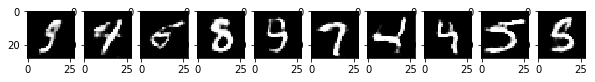

Epochs 10/10: Generator Loss: 0.902. Discriminator Loss: -0.222


Epochs 10/10: Generator Loss: 0.97. Discriminator Loss: -0.284


Epochs 10/10: Generator Loss: 0.842. Discriminator Loss: -0.232


Epochs 10/10: Generator Loss: 1.302. Discriminator Loss: -0.225


Epochs 10/10: Generator Loss: 1.144. Discriminator Loss: -0.268


Epochs 10/10: Generator Loss: 1.282. Discriminator Loss: -0.27


Epochs 10/10: Generator Loss: 1.278. Discriminator Loss: -0.251


Epochs 10/10: Generator Loss: 1.421. Discriminator Loss: -0.214


Epochs 10/10: Generator Loss: 1.016. Discriminator Loss: -0.265


Epochs 10/10: Generator Loss: 1.048. Discriminator Loss: -0.257


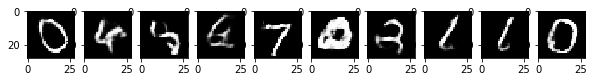

Epochs 10/10: Generator Loss: 1.375. Discriminator Loss: -0.334


Epochs 10/10: Generator Loss: 1.574. Discriminator Loss: -0.308


Epochs 10/10: Generator Loss: 1.782. Discriminator Loss: -0.289


Epochs 10/10: Generator Loss: 1.692. Discriminator Loss: -0.208


Epochs 10/10: Generator Loss: 1.719. Discriminator Loss: -0.23


Epochs 10/10: Generator Loss: 1.525. Discriminator Loss: -0.239


Epochs 10/10: Generator Loss: 1.359. Discriminator Loss: -0.196


Epochs 10/10: Generator Loss: 1.554. Discriminator Loss: -0.222


Epochs 10/10: Generator Loss: 1.855. Discriminator Loss: -0.218


Epochs 10/10: Generator Loss: 2.02. Discriminator Loss: -0.295


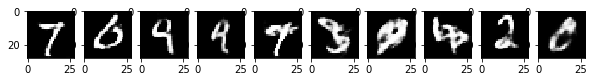

Epochs 10/10: Generator Loss: 1.844. Discriminator Loss: -0.298


Epochs 10/10: Generator Loss: 1.747. Discriminator Loss: -0.29


Epochs 10/10: Generator Loss: 1.246. Discriminator Loss: -0.276


Epochs 10/10: Generator Loss: 1.401. Discriminator Loss: -0.231


Epochs 10/10: Generator Loss: 1.593. Discriminator Loss: -0.29


Epochs 10/10: Generator Loss: 1.994. Discriminator Loss: -0.283


Epochs 10/10: Generator Loss: 1.947. Discriminator Loss: -0.308


Epochs 10/10: Generator Loss: 1.785. Discriminator Loss: -0.284


Epochs 10/10: Generator Loss: 1.857. Discriminator Loss: -0.208


Epochs 10/10: Generator Loss: 1.919. Discriminator Loss: -0.251


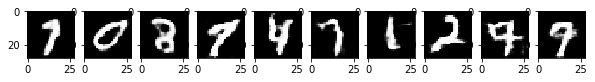

Epochs 10/10: Generator Loss: 1.557. Discriminator Loss: -0.396


Epochs 10/10: Generator Loss: 1.361. Discriminator Loss: -0.273


Epochs 10/10: Generator Loss: 1.329. Discriminator Loss: -0.213


Epochs 10/10: Generator Loss: 1.172. Discriminator Loss: -0.19


Epochs 10/10: Generator Loss: 1.144. Discriminator Loss: -0.221


Epochs 10/10: Generator Loss: 1.275. Discriminator Loss: -0.246


Epochs 10/10: Generator Loss: 1.48. Discriminator Loss: -0.258


Epochs 10/10: Generator Loss: 2.09. Discriminator Loss: -0.152


Epochs 10/10: Generator Loss: 1.689. Discriminator Loss: -0.158


Epochs 10/10: Generator Loss: 1.614. Discriminator Loss: -0.172


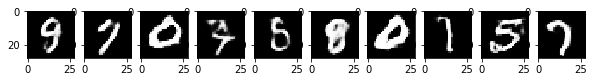

Epochs 10/10: Generator Loss: 1.244. Discriminator Loss: -0.181


Epochs 10/10: Generator Loss: 1.581. Discriminator Loss: -0.294


Epochs 10/10: Generator Loss: 1.797. Discriminator Loss: -0.239


Epochs 10/10: Generator Loss: 1.436. Discriminator Loss: -0.21


Epochs 10/10: Generator Loss: 1.438. Discriminator Loss: -0.225


Epochs 10/10: Generator Loss: 1.559. Discriminator Loss: -0.24


Epochs 10/10: Generator Loss: 1.477. Discriminator Loss: -0.258


Epochs 10/10: Generator Loss: 1.345. Discriminator Loss: -0.249


Epochs 10/10: Generator Loss: 1.57. Discriminator Loss: -0.232


Epochs 10/10: Generator Loss: 1.668. Discriminator Loss: -0.212


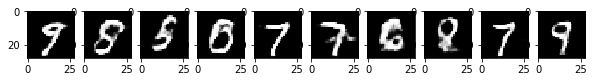

Epochs 10/10: Generator Loss: 1.809. Discriminator Loss: -0.279


Epochs 10/10: Generator Loss: 1.914. Discriminator Loss: -0.256


In [60]:
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
dataset = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

epochs = 10
batch_size = 32
z_dim = 100
learning_rate = 1e-4
image_type = 'gray'
alpha = 0.2
beta_1 = 0.5
beta_2 = 0.9

# WGAN specific parameters
# Gradient clipping value and number of updates in critic per generator.
n_critic = 5
gp_coeff = 10.0
use_bn = False


with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, dataset, image_type, alpha, beta_1, beta_2, n_critic, gp_coeff, use_bn)